# Steps
1. Choose data scenario.
2. Generate the dataset accordingly.
5. Choose 'fixed' configuration.
6. For each 'fixed' configuration, optimize the other parameters based on RMSE.
7. Given optimal setting, run popularity bias analysis for every version of the 'fixed' configuration.

## Libraries

In [1]:
import os

os.environ["MKL_THREADING_LAYER"] = "TBB"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
# for random generation


# basic functions
import pandas as pd

pd.options.display.max_rows = 100
import pickle

# custom-made functions
import modelling_mf
from data_generation import generate_data
from optimize_hp import optimize_lkpy, optimize_cornac

# lenskit RS library
from lenskit.algorithms import als


# cornac RS library
from cornac.models import MF

## Fairbook data and parameters

In [2]:
data = "fairbook"
# user-item interactions
fairbook_ratings = pd.read_csv("data/" + data + "_events.csv")

In [3]:
user_col = "user"  # the name of the column that includes the users
item_col = "item"  # the name of the column that includes the items
predict_col = "rating"  # the name of the column that includes the interaction

## Scenarios

1. There is no general relation between popularity and rating: uniformly_random
2. Popular items are rated higher by the users.: popularity_good
3. Popular items are rated lower by the users.: popilarity_bad
4. Popular items are rated higher by users with big profiles.: popularity_good_for_bp_ur
5. Popular items are rated lower by users with big profiles.: popularity_bad_for_bp_ur

In [4]:
data_strategies = [
    "uniformly_random",
    "popularity_good",
    "popularity_bad",
    "popularity_good_for_bp_ur",
    "popularity_bad_for_bp_ur",
]

## Optimize, train, evaluate LKPY
- **Algorithm**
- **Fixed parameters**
- **To-optimize parameters**

In [5]:
algo_versions = {"MF": [{"bias": True}, {"bias": False}]}

In [6]:
evaluation_way = "cross_validation"
verbose = False
plot = True
save_plot = True  # save the plots
fallback = False
nr_recs = 10
sampling_strategy = "frac"
partition_way = "user"

uniformly_random {'bias': True}
We got them already
nr of longtail 5073
3.9882075471698113
nr of longtail 5327
4.187893081761007
nr of longtail 5571
4.379716981132075
nr of longtail 5410
4.256490952006295
nr of longtail 5423
4.266719118804091


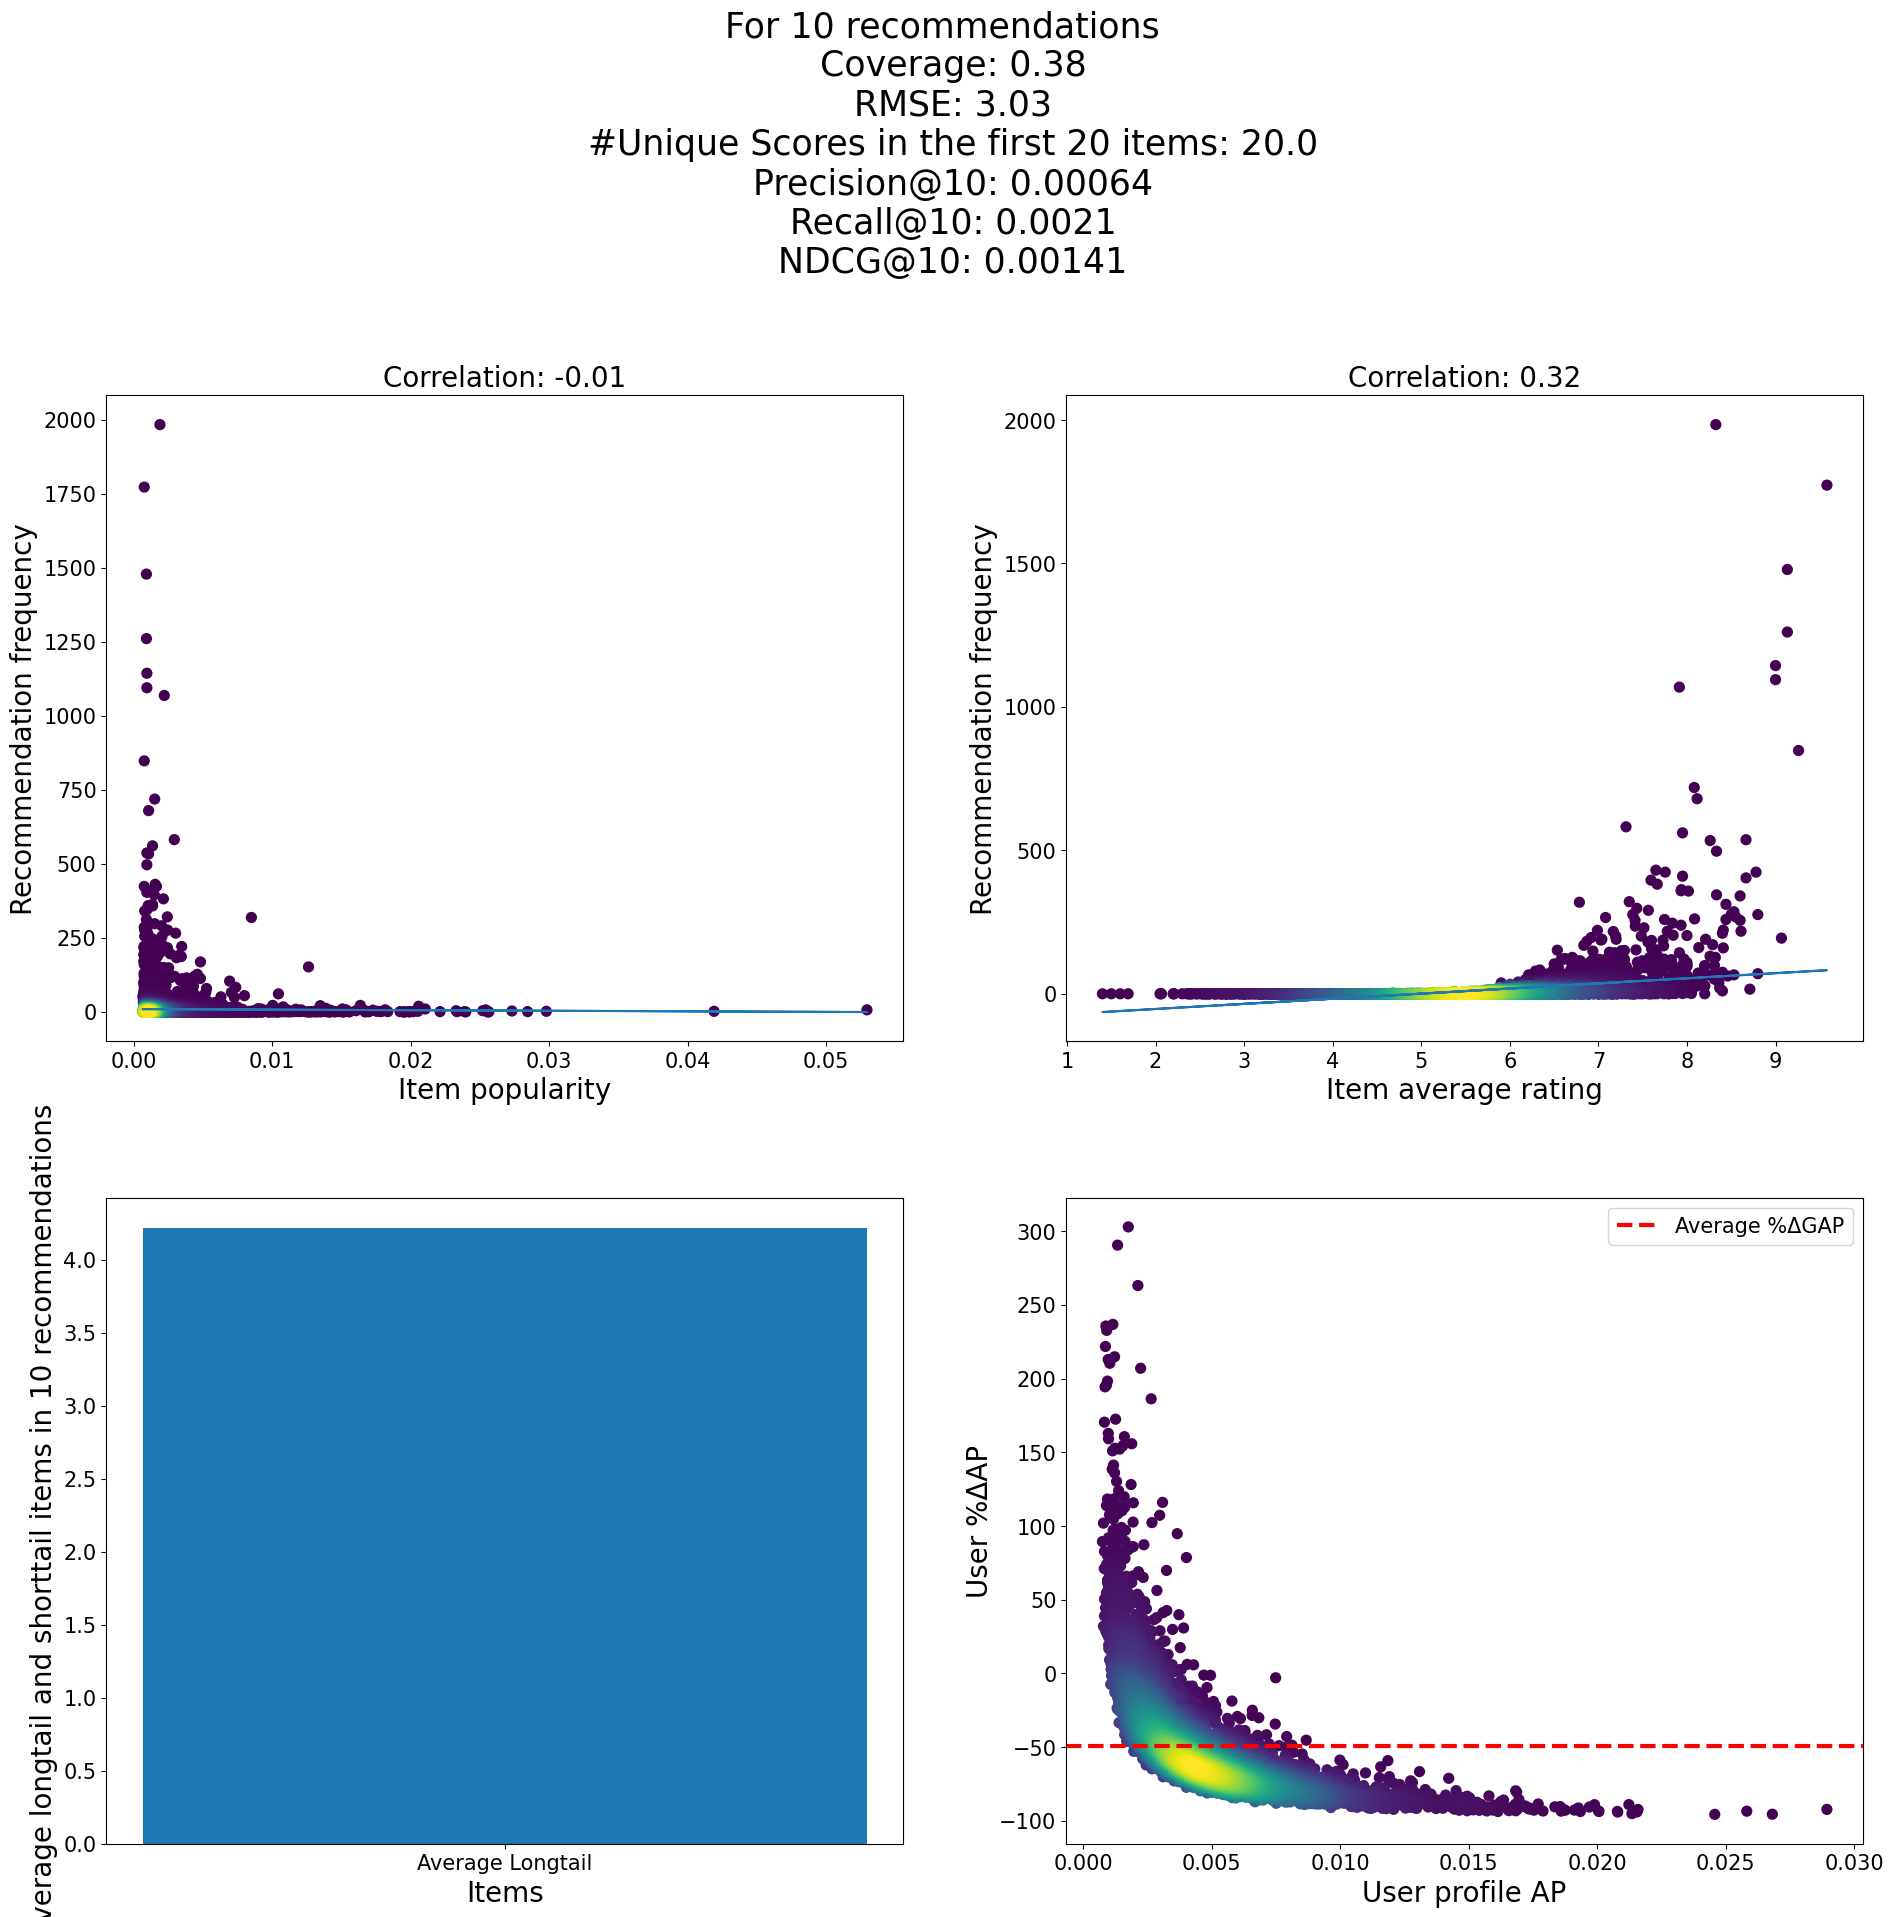

uniformly_random {'bias': False}
We got them already
nr of longtail 5915
4.6501572327044025
nr of longtail 6423
5.0495283018867925
nr of longtail 6706
5.272012578616352
nr of longtail 6575
5.17309205350118
nr of longtail 6639
5.223446105428796


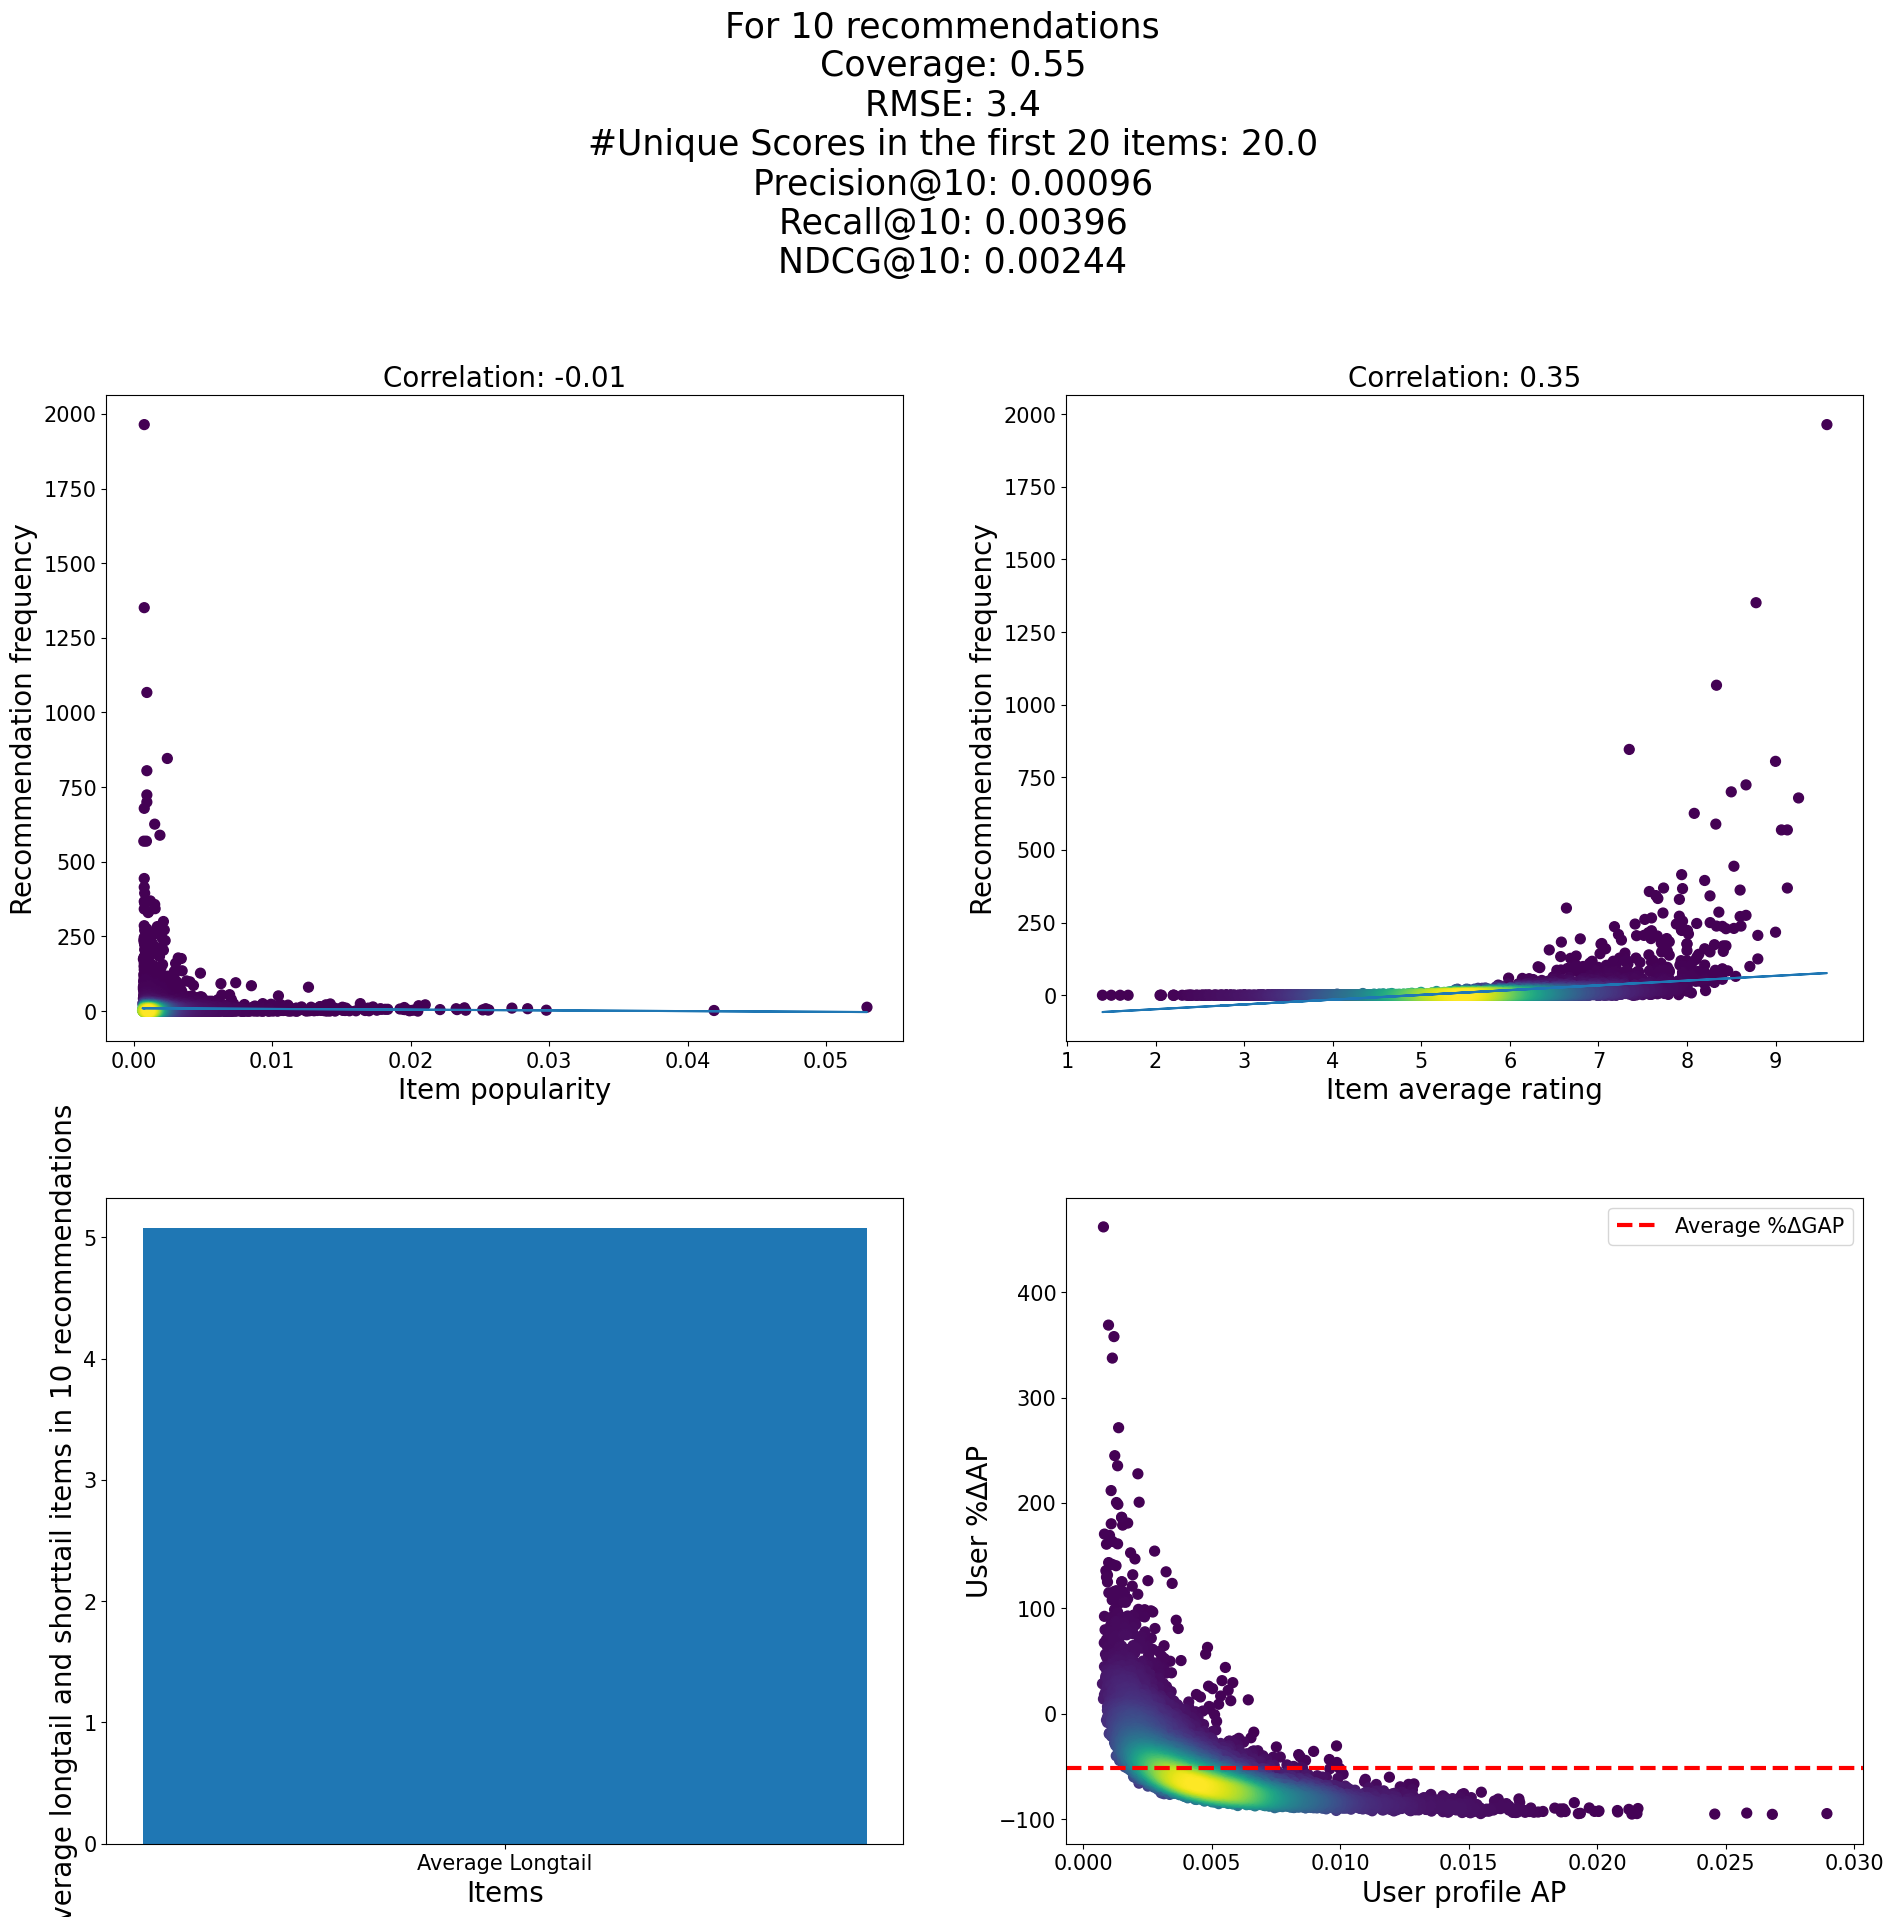

popularity_good {'bias': True}
We got them already
nr of longtail 0
0.0
nr of longtail 0
0.0
nr of longtail 0
0.0
nr of longtail 0
0.0
nr of longtail 0
0.0


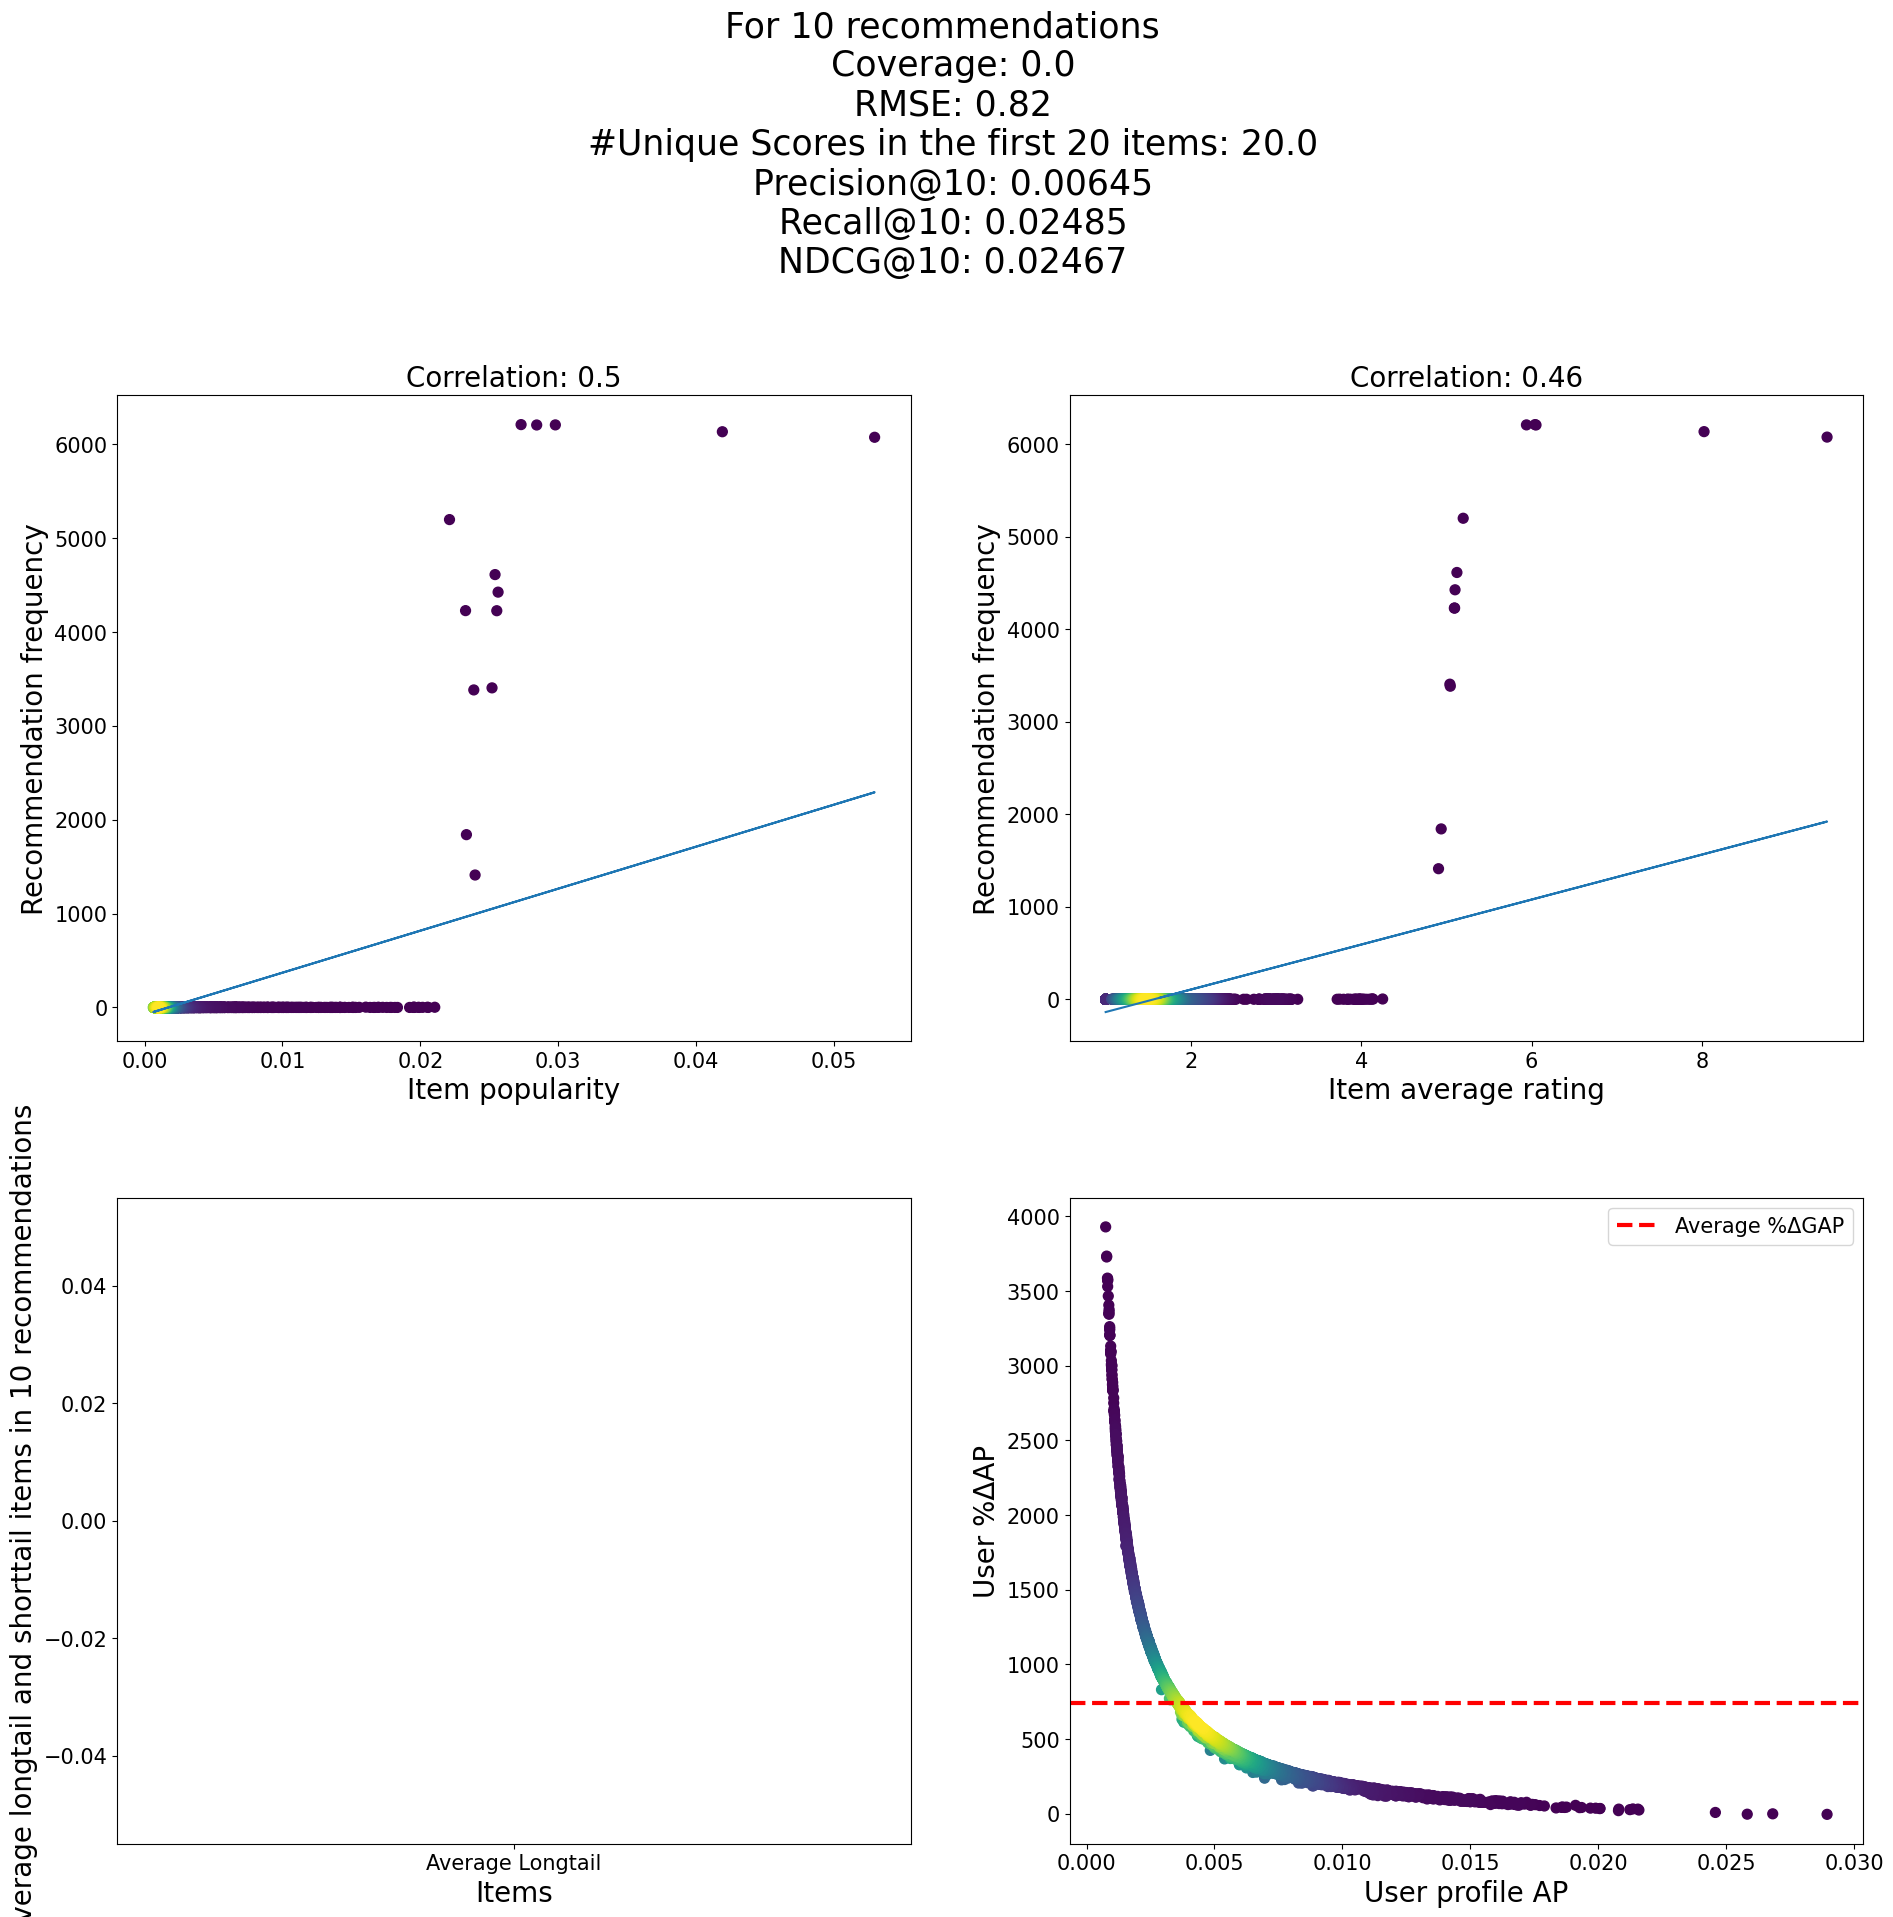

popularity_good {'bias': False}
We got them already
nr of longtail 1
0.0007861635220125787
nr of longtail 1
0.0007861635220125787
nr of longtail 0
0.0
nr of longtail 0
0.0
nr of longtail 1
0.0007867820613690008


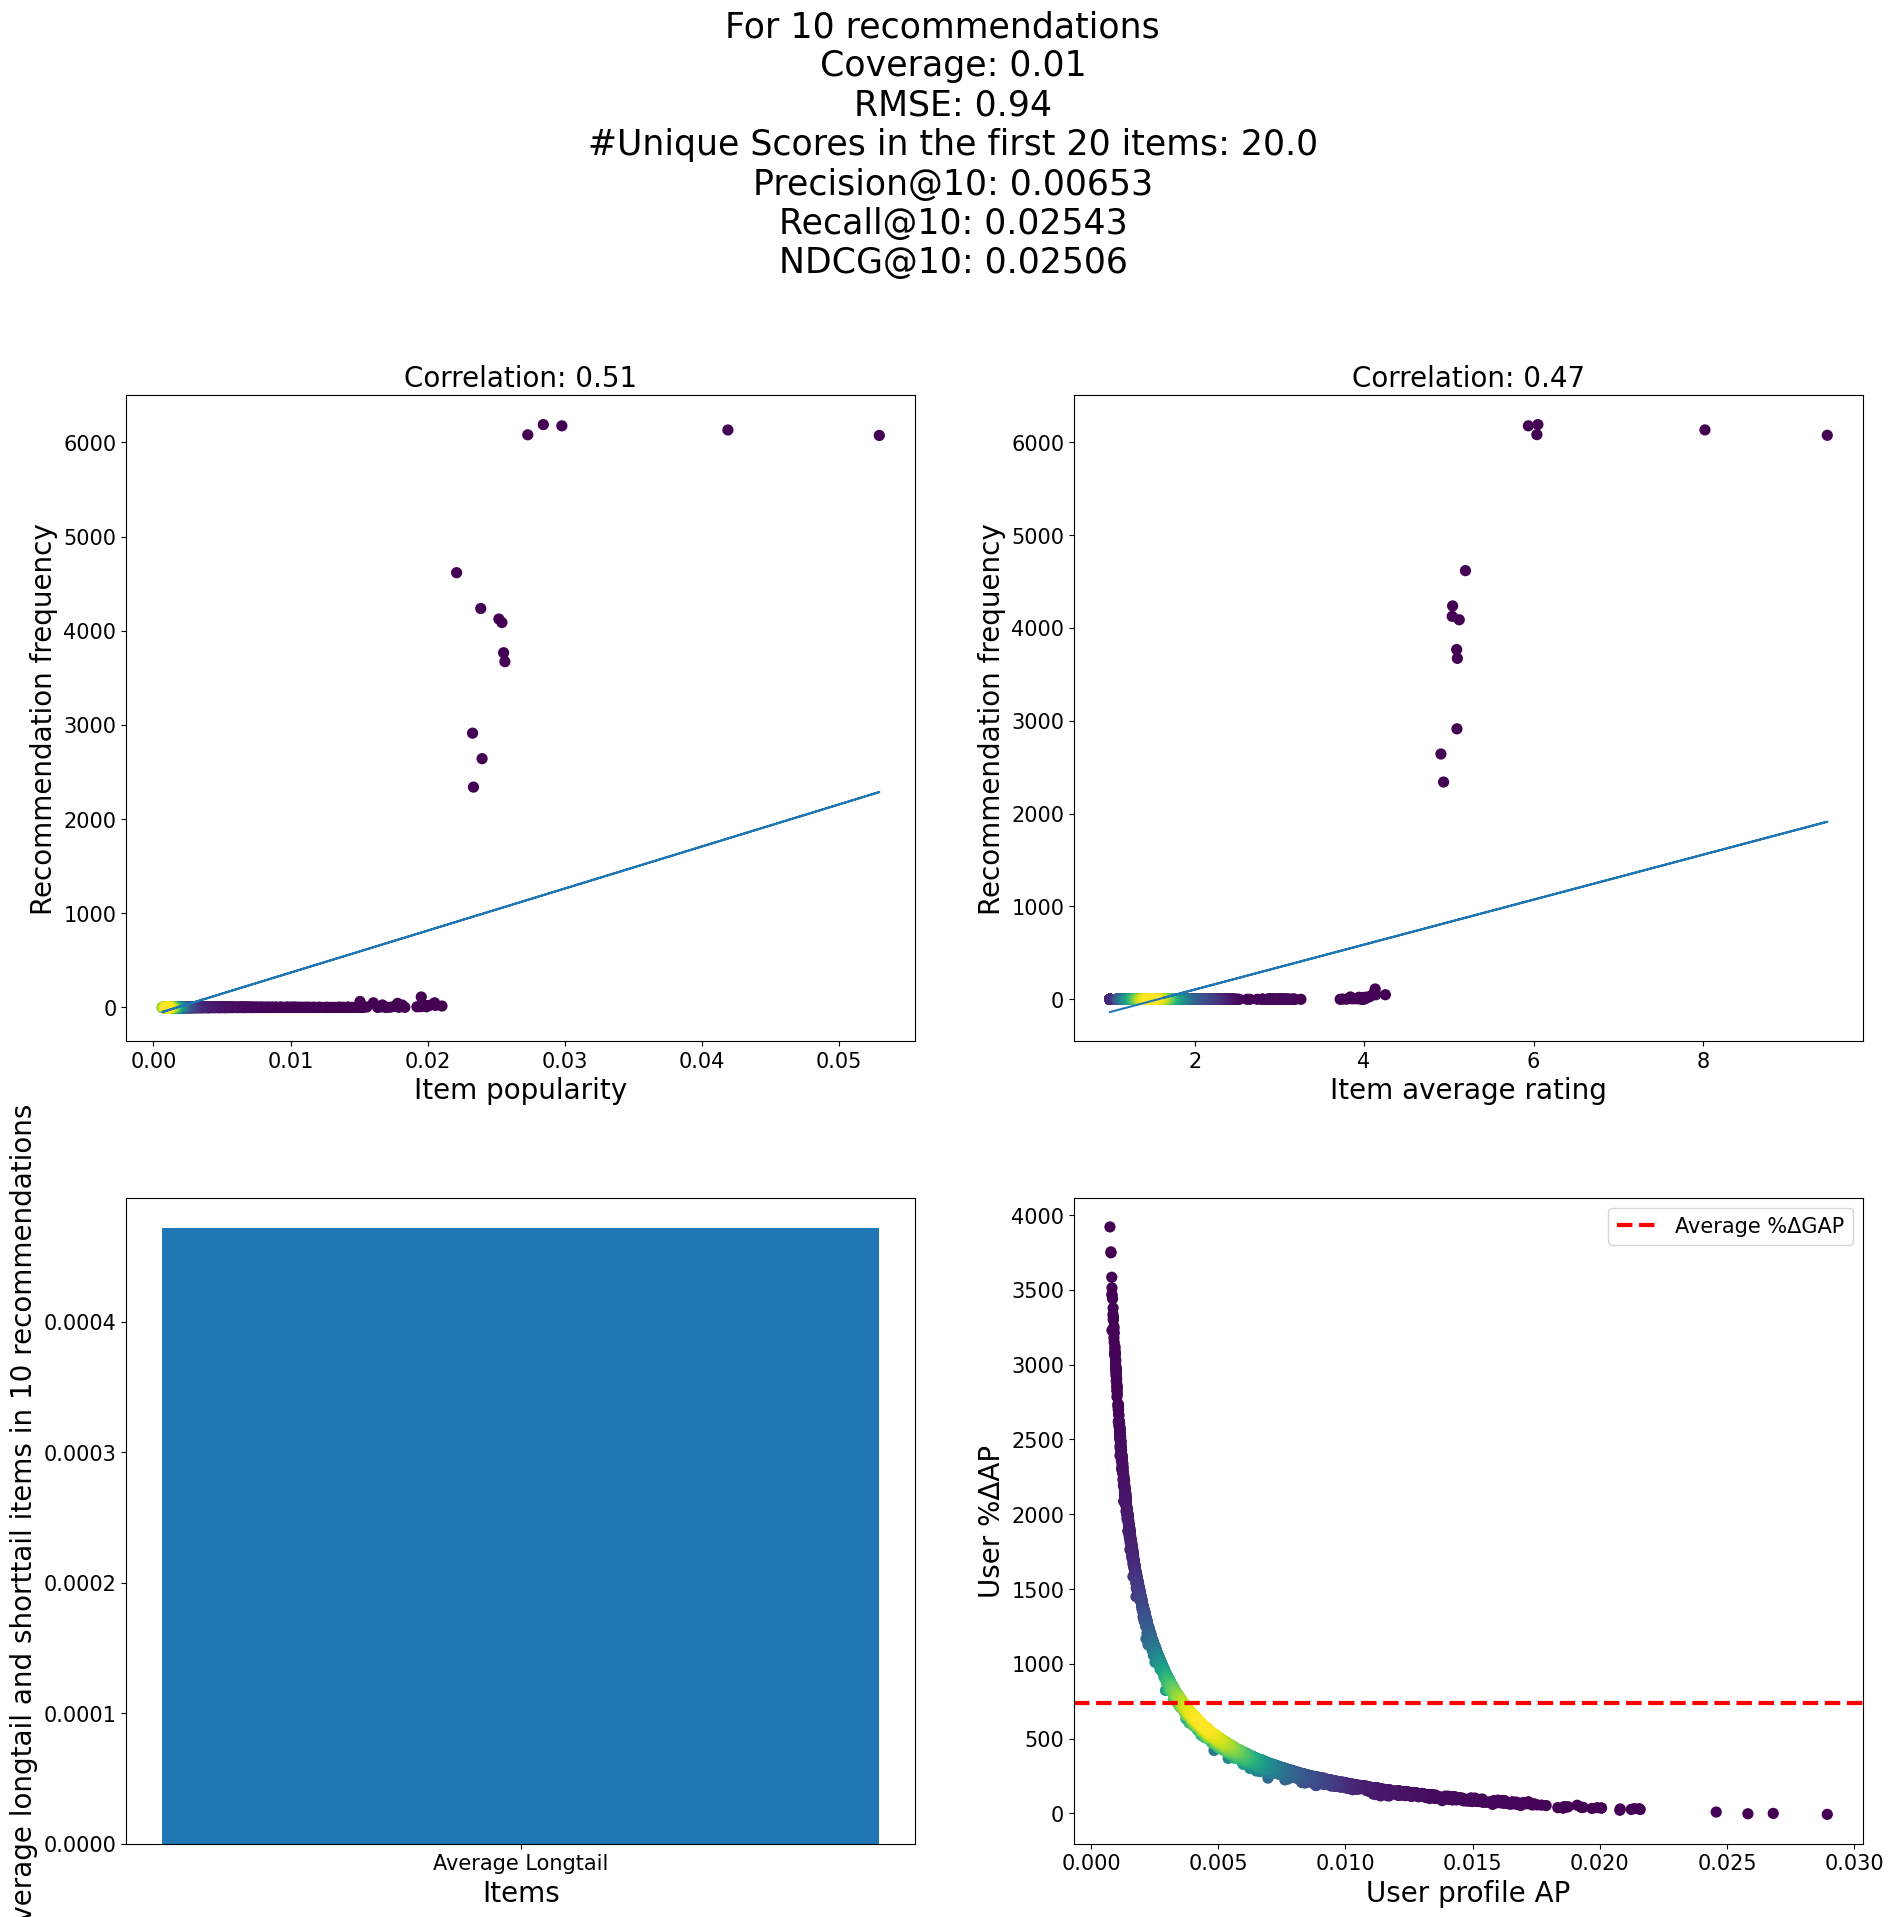

popularity_bad {'bias': True}
We got them already
nr of longtail 740
0.5817610062893082
nr of longtail 755
0.5935534591194969
nr of longtail 678
0.5330188679245284
nr of longtail 740
0.5822187254130606
nr of longtail 733
0.5767112509834775


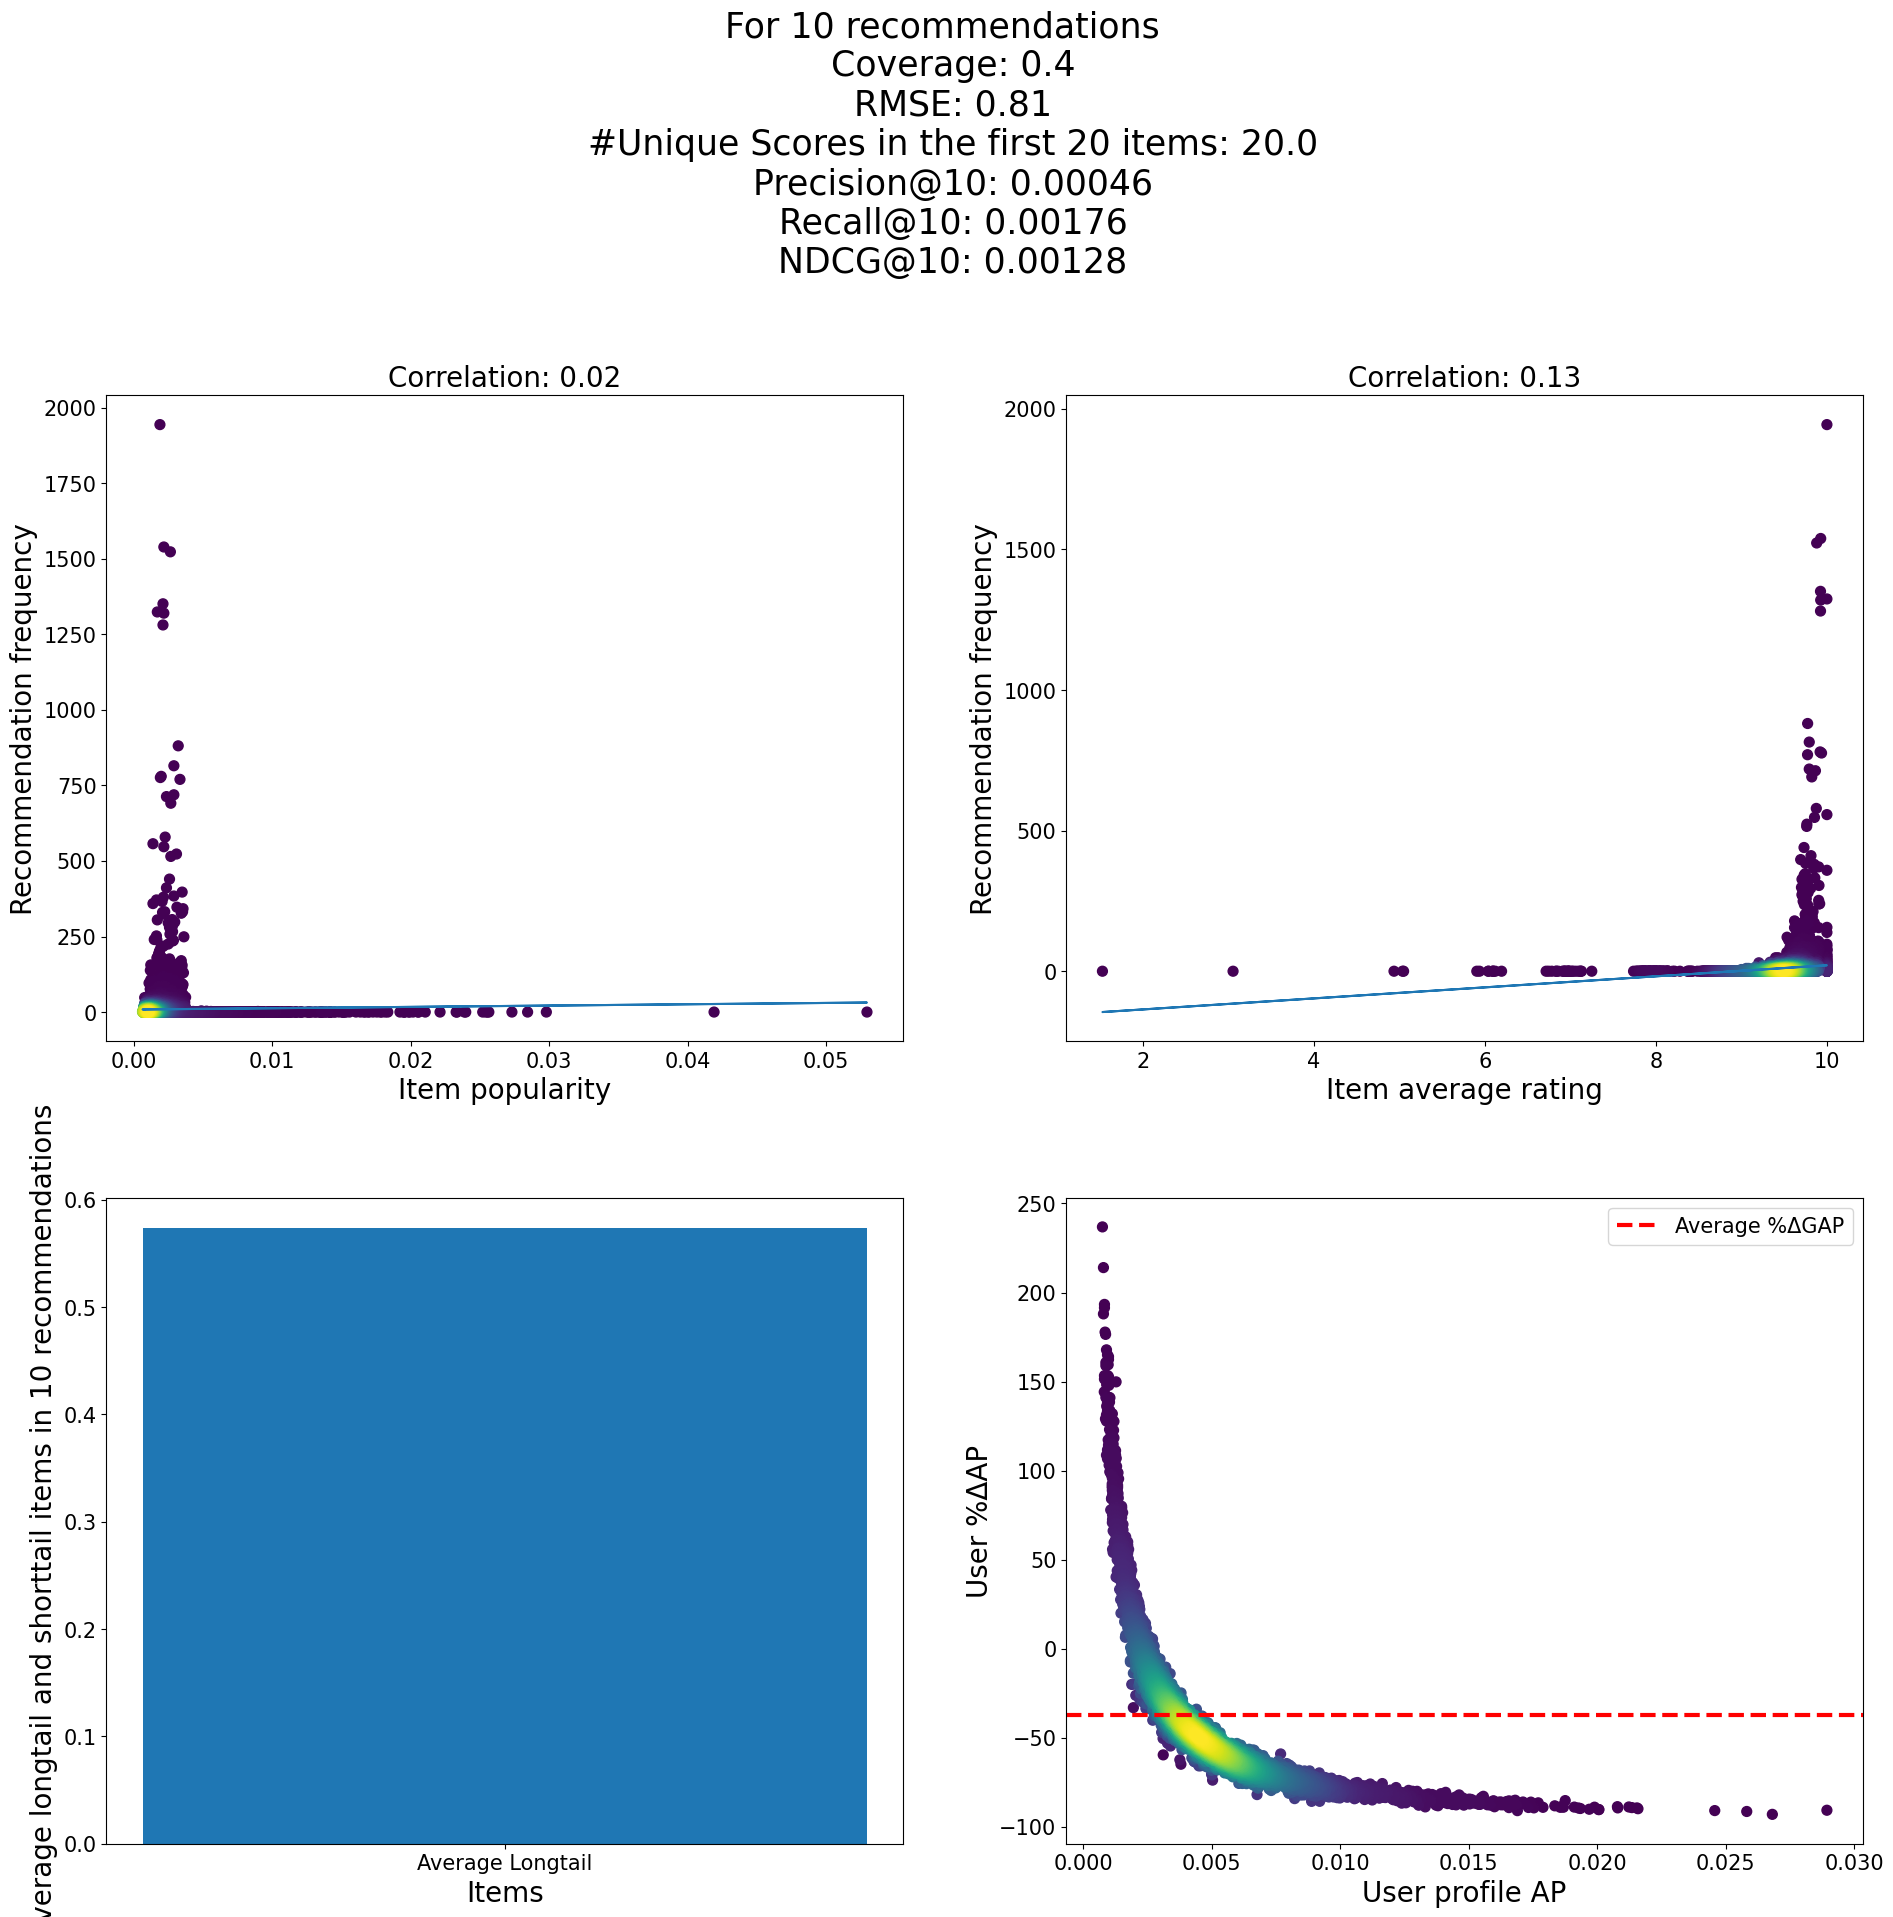

popularity_bad {'bias': False}
We got them already
nr of longtail 10224
8.037735849056604
nr of longtail 10106
7.94496855345912
nr of longtail 9738
7.65566037735849
nr of longtail 9333
7.343036978756884
nr of longtail 10034
7.894571203776554


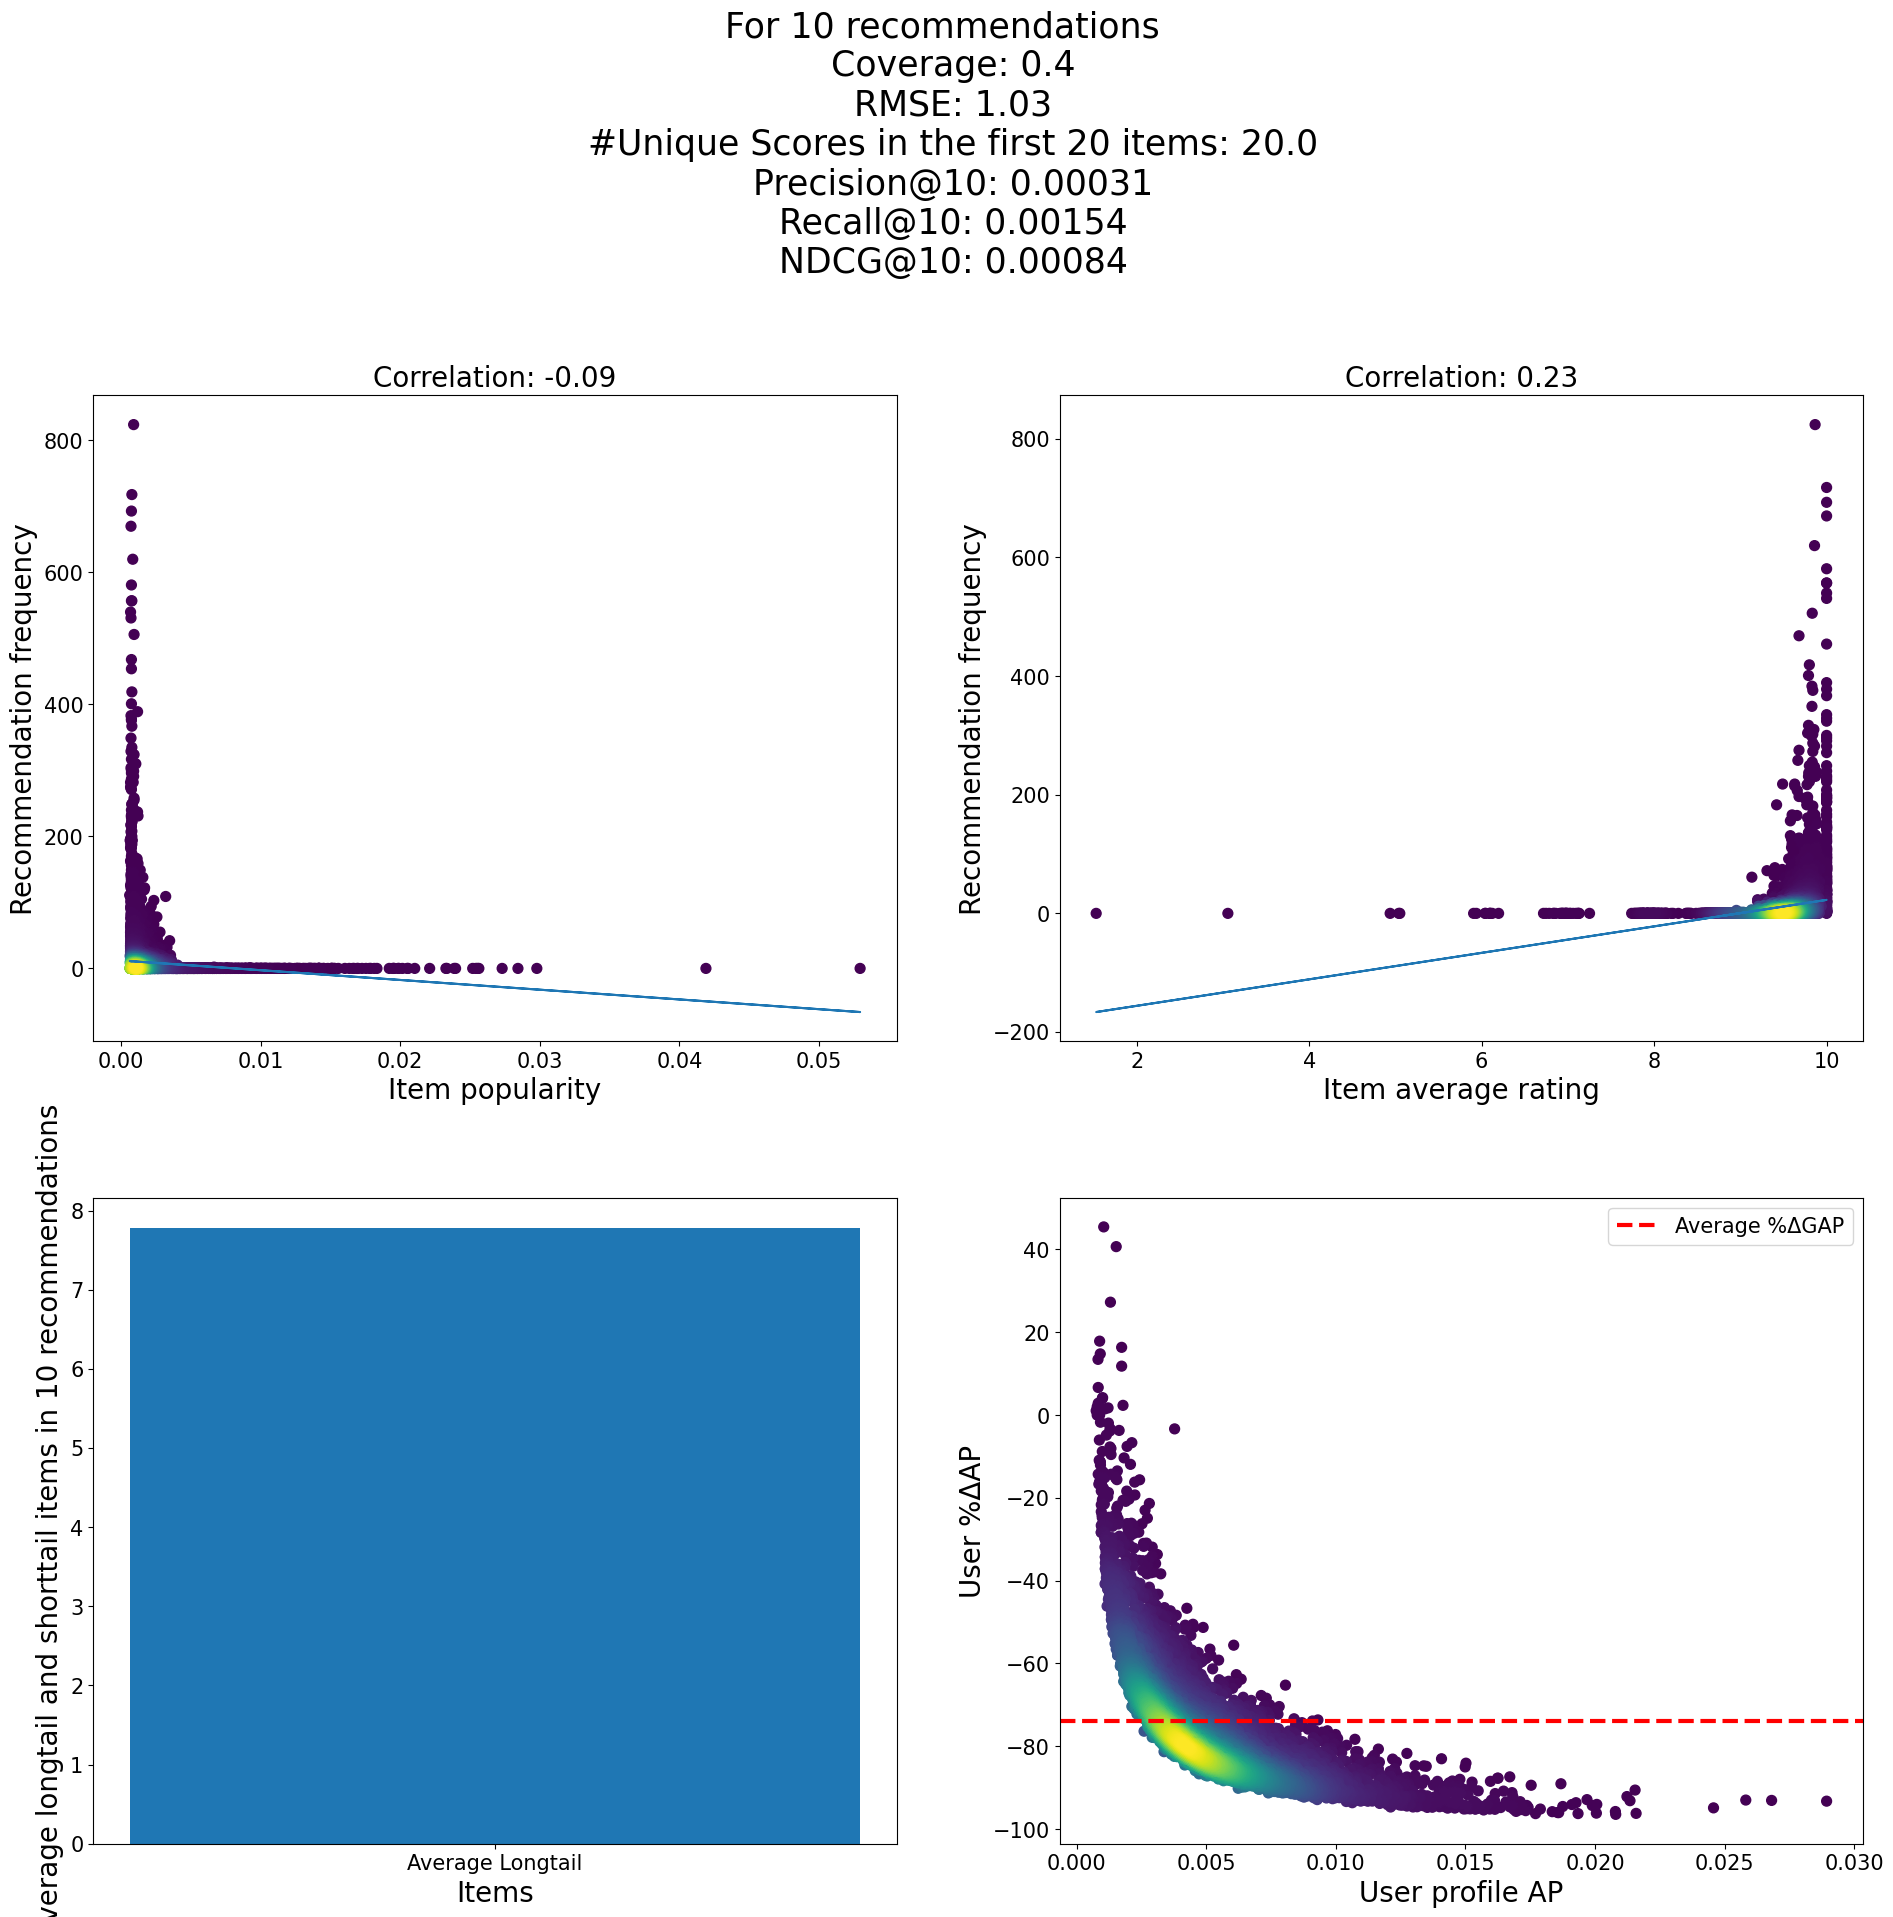

popularity_good_for_bp_ur {'bias': True}
We got them already
nr of longtail 5737
4.510220125786163
nr of longtail 6159
4.841981132075472
nr of longtail 6151
4.835691823899371
nr of longtail 6622
5.210070810385523
nr of longtail 6113
4.809598741148702


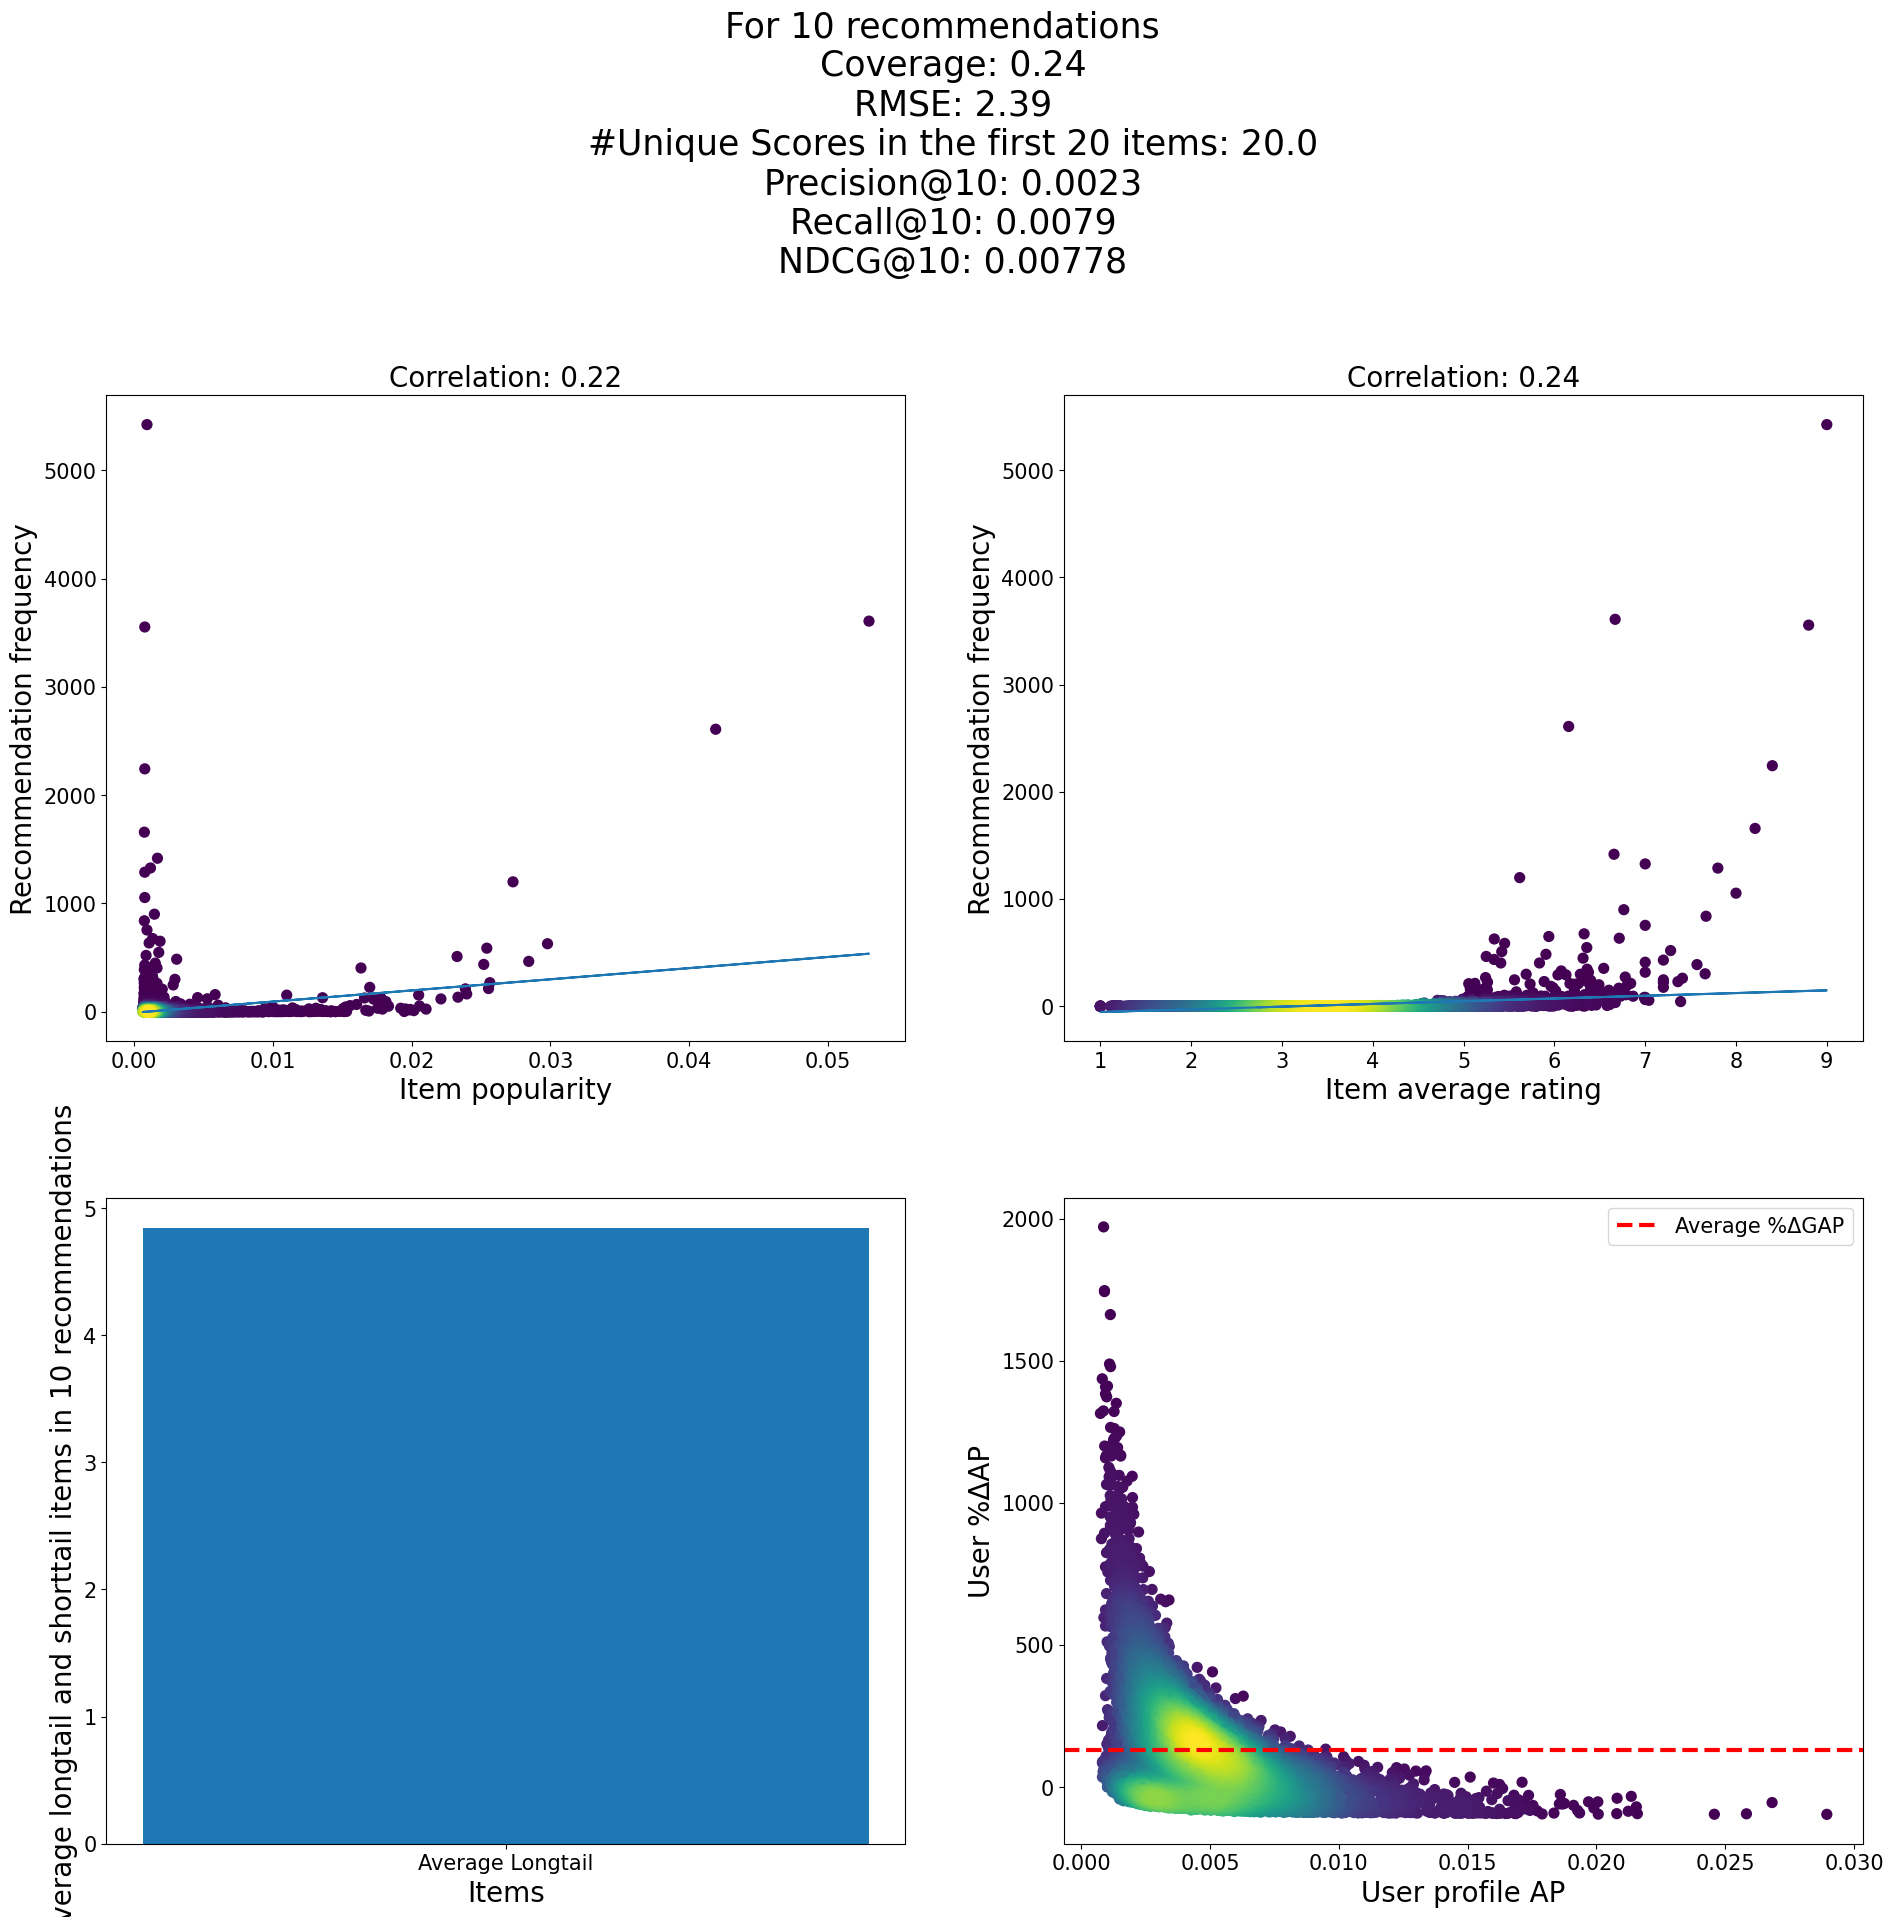

popularity_good_for_bp_ur {'bias': False}
We got them already
nr of longtail 5472
4.30188679245283
nr of longtail 5358
4.212264150943396
nr of longtail 5654
4.44496855345912
nr of longtail 5472
4.305271439811173
nr of longtail 5361
4.217938630999213


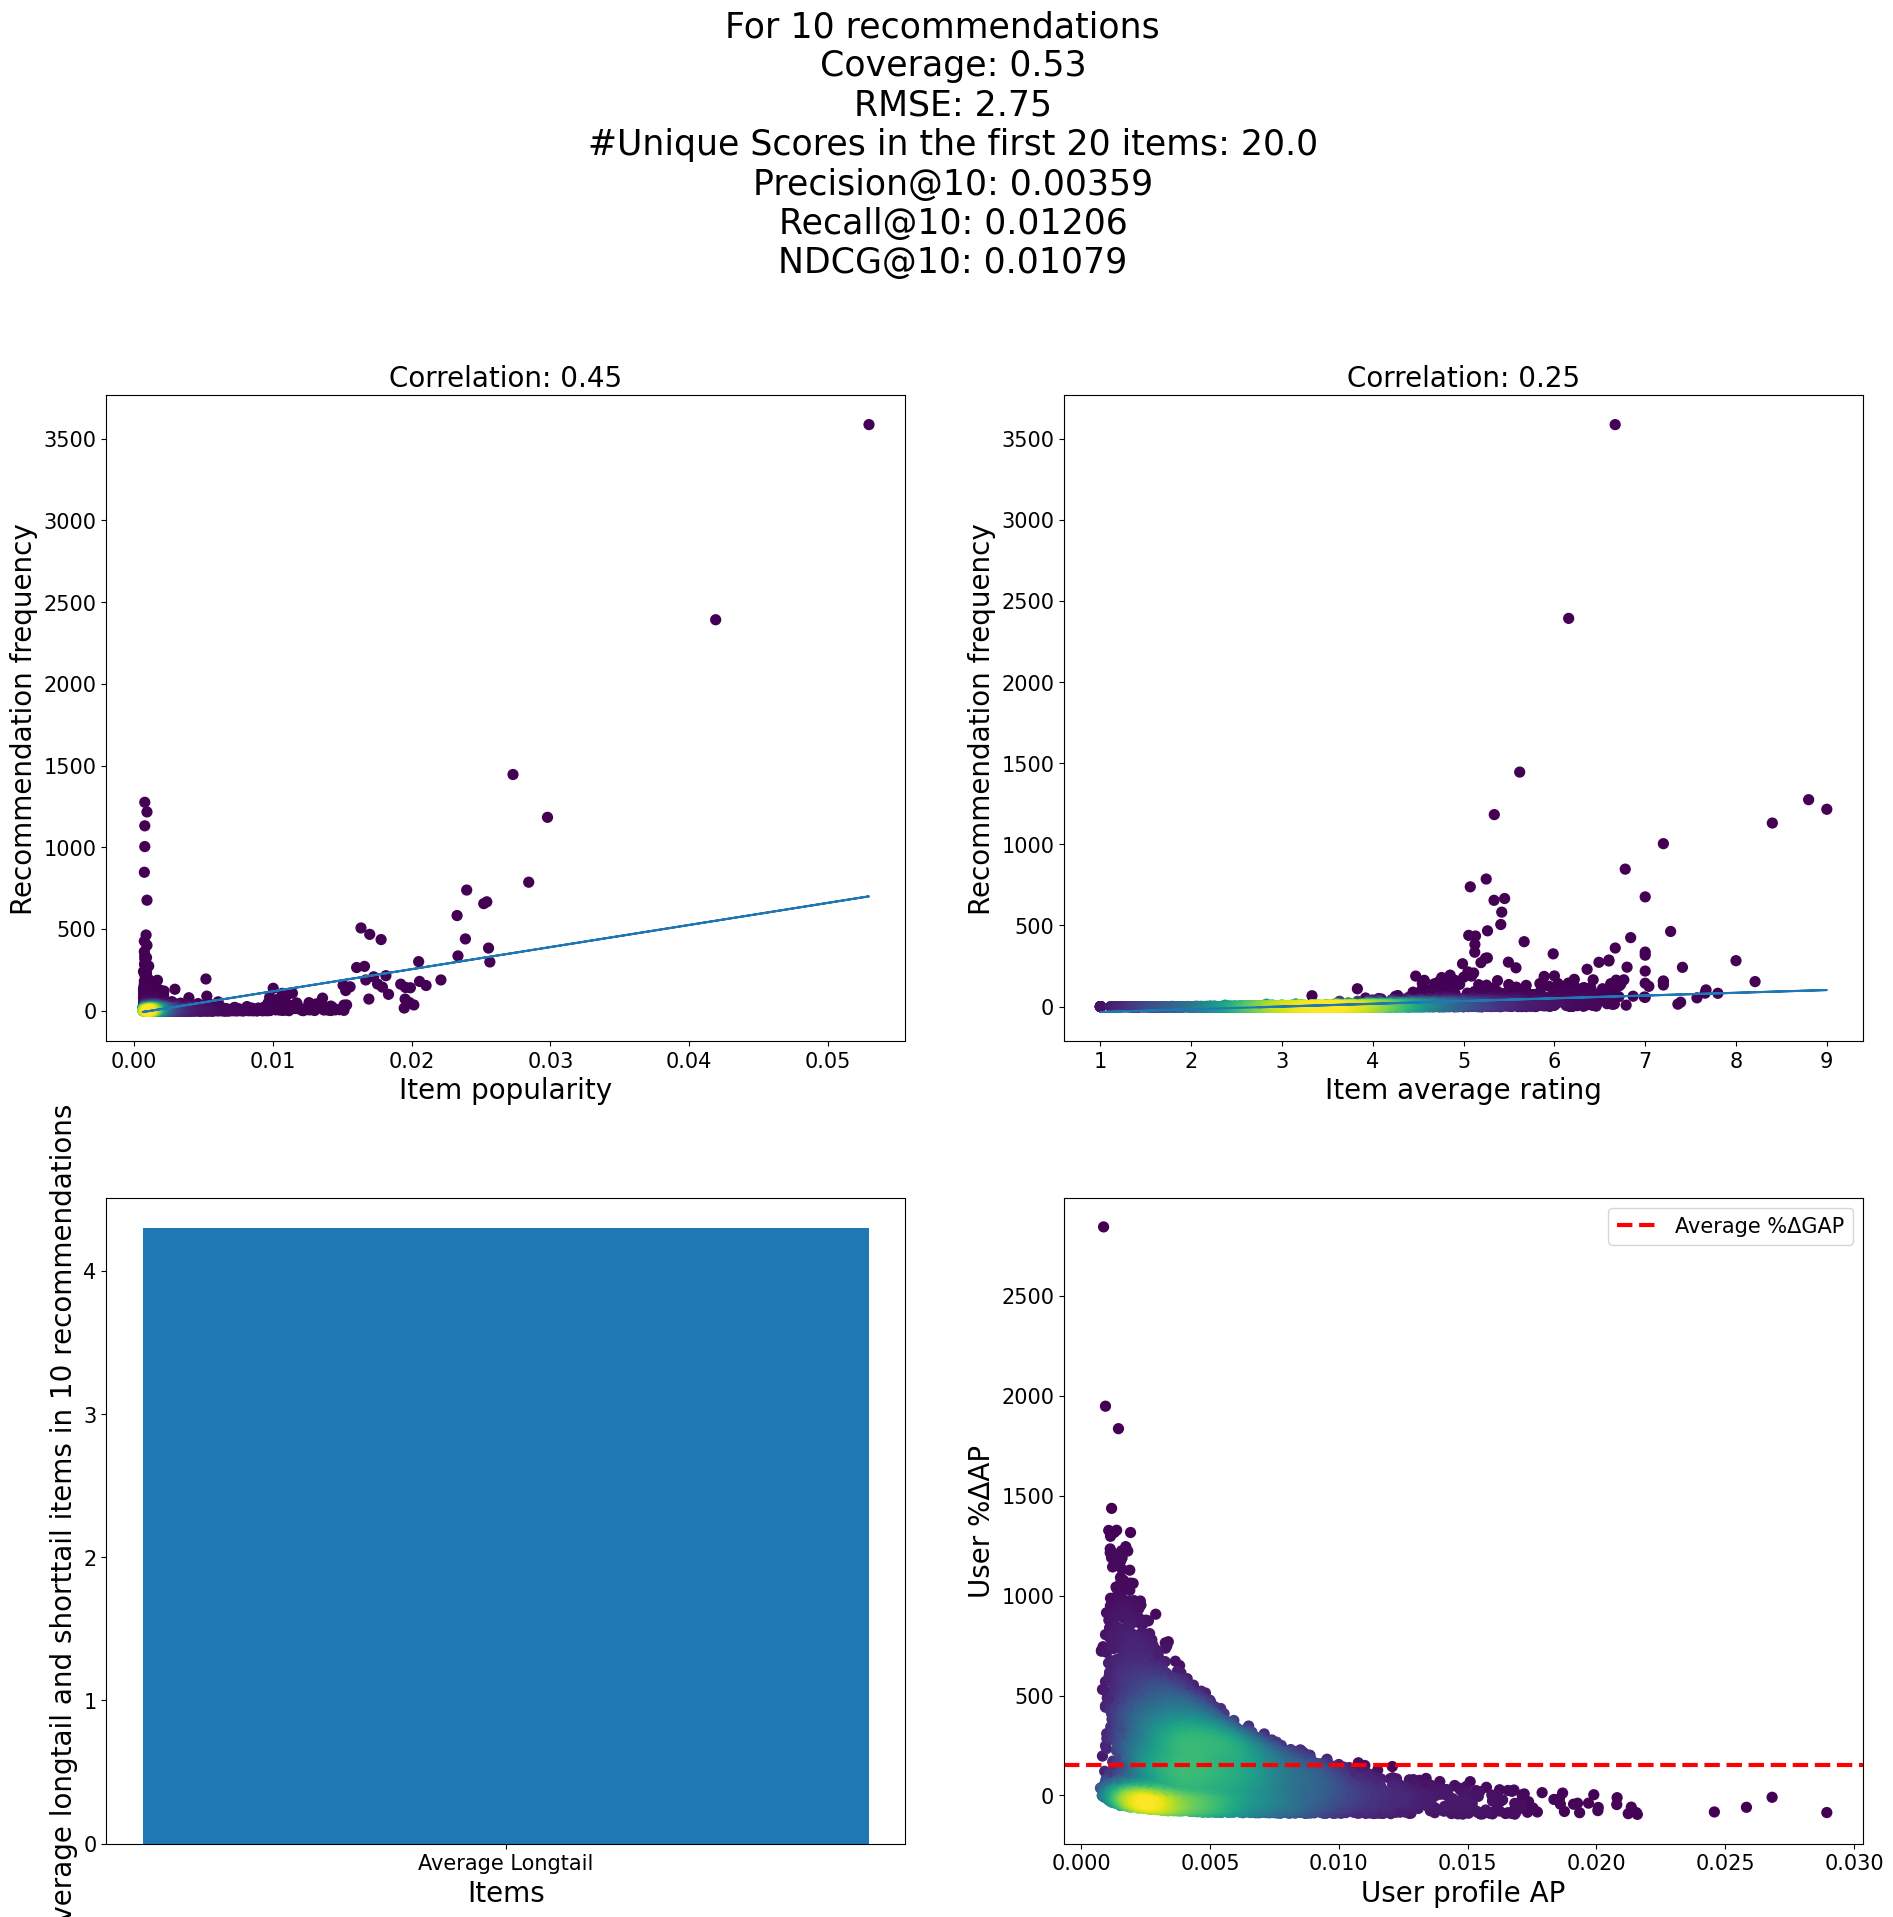

popularity_bad_for_bp_ur {'bias': True}
We got them already
nr of longtail 3574
2.809748427672956
nr of longtail 3848
3.0251572327044025
nr of longtail 3885
3.0542452830188678
nr of longtail 4356
3.4272226593233674
nr of longtail 3912
3.0778914240755313


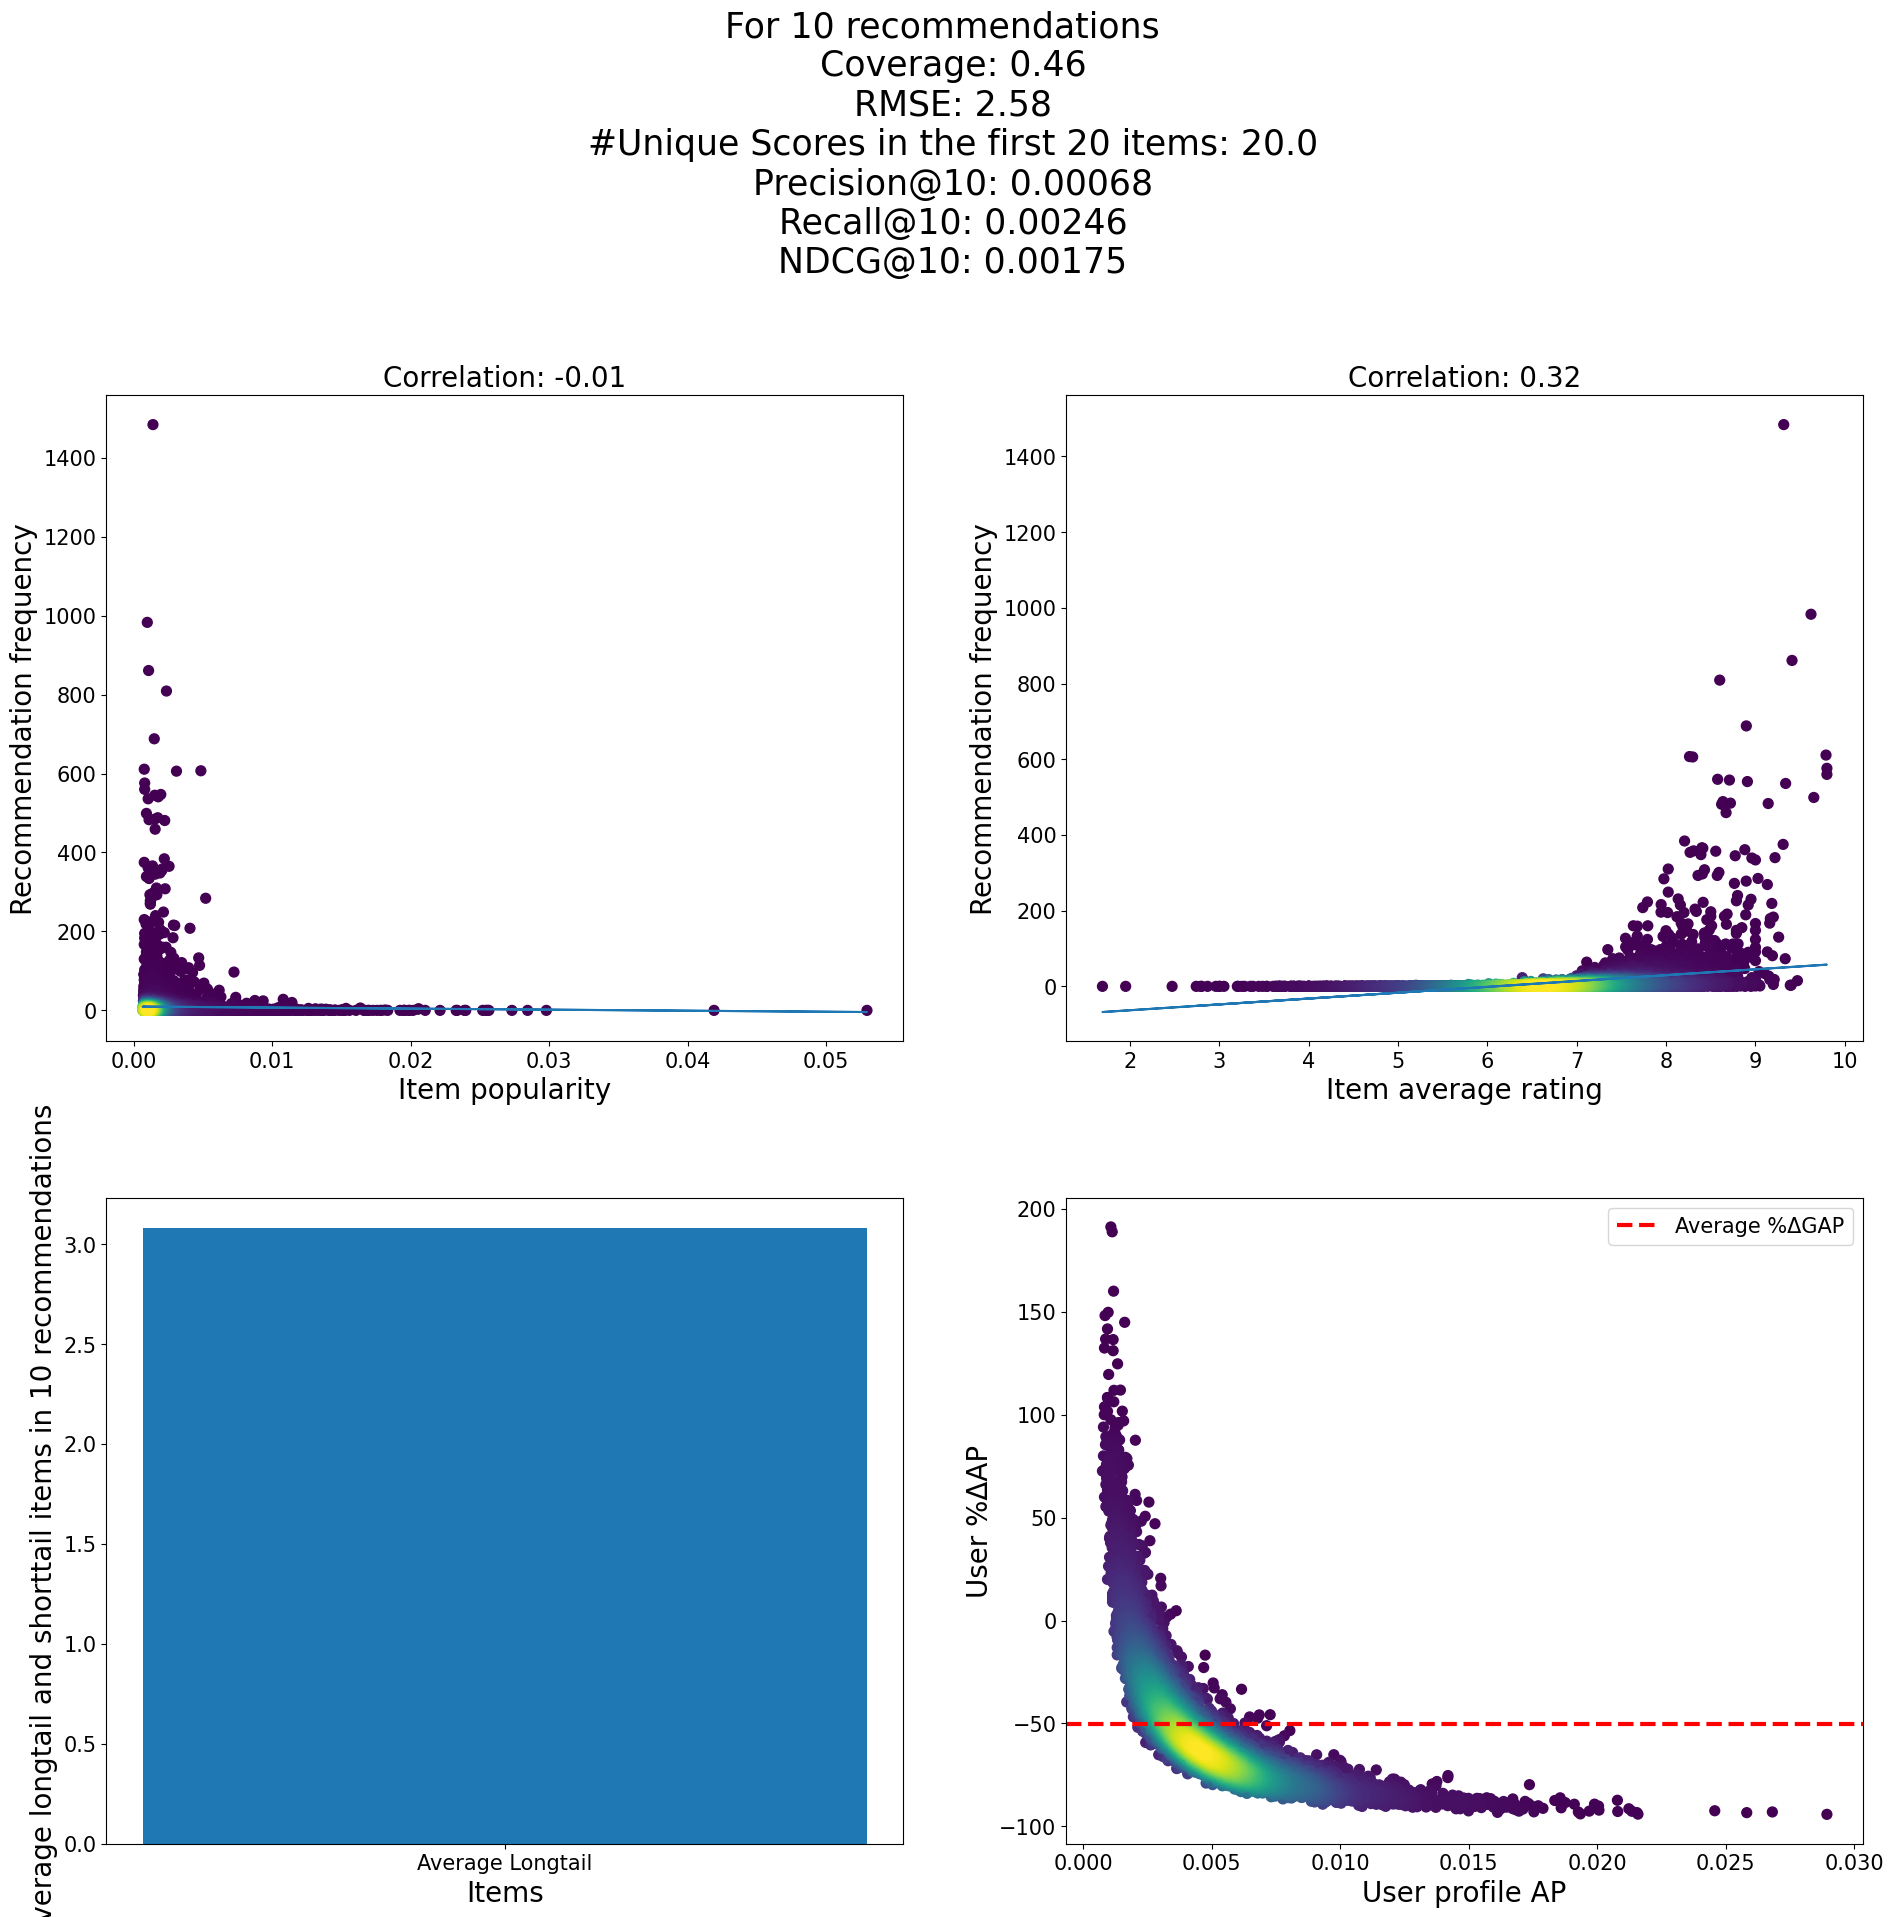

popularity_bad_for_bp_ur {'bias': False}
We got them already
nr of longtail 6652
5.229559748427673
nr of longtail 6898
5.422955974842767
nr of longtail 6955
5.4677672955974845
nr of longtail 6204
4.881195908733281
nr of longtail 6634
5.219512195121951


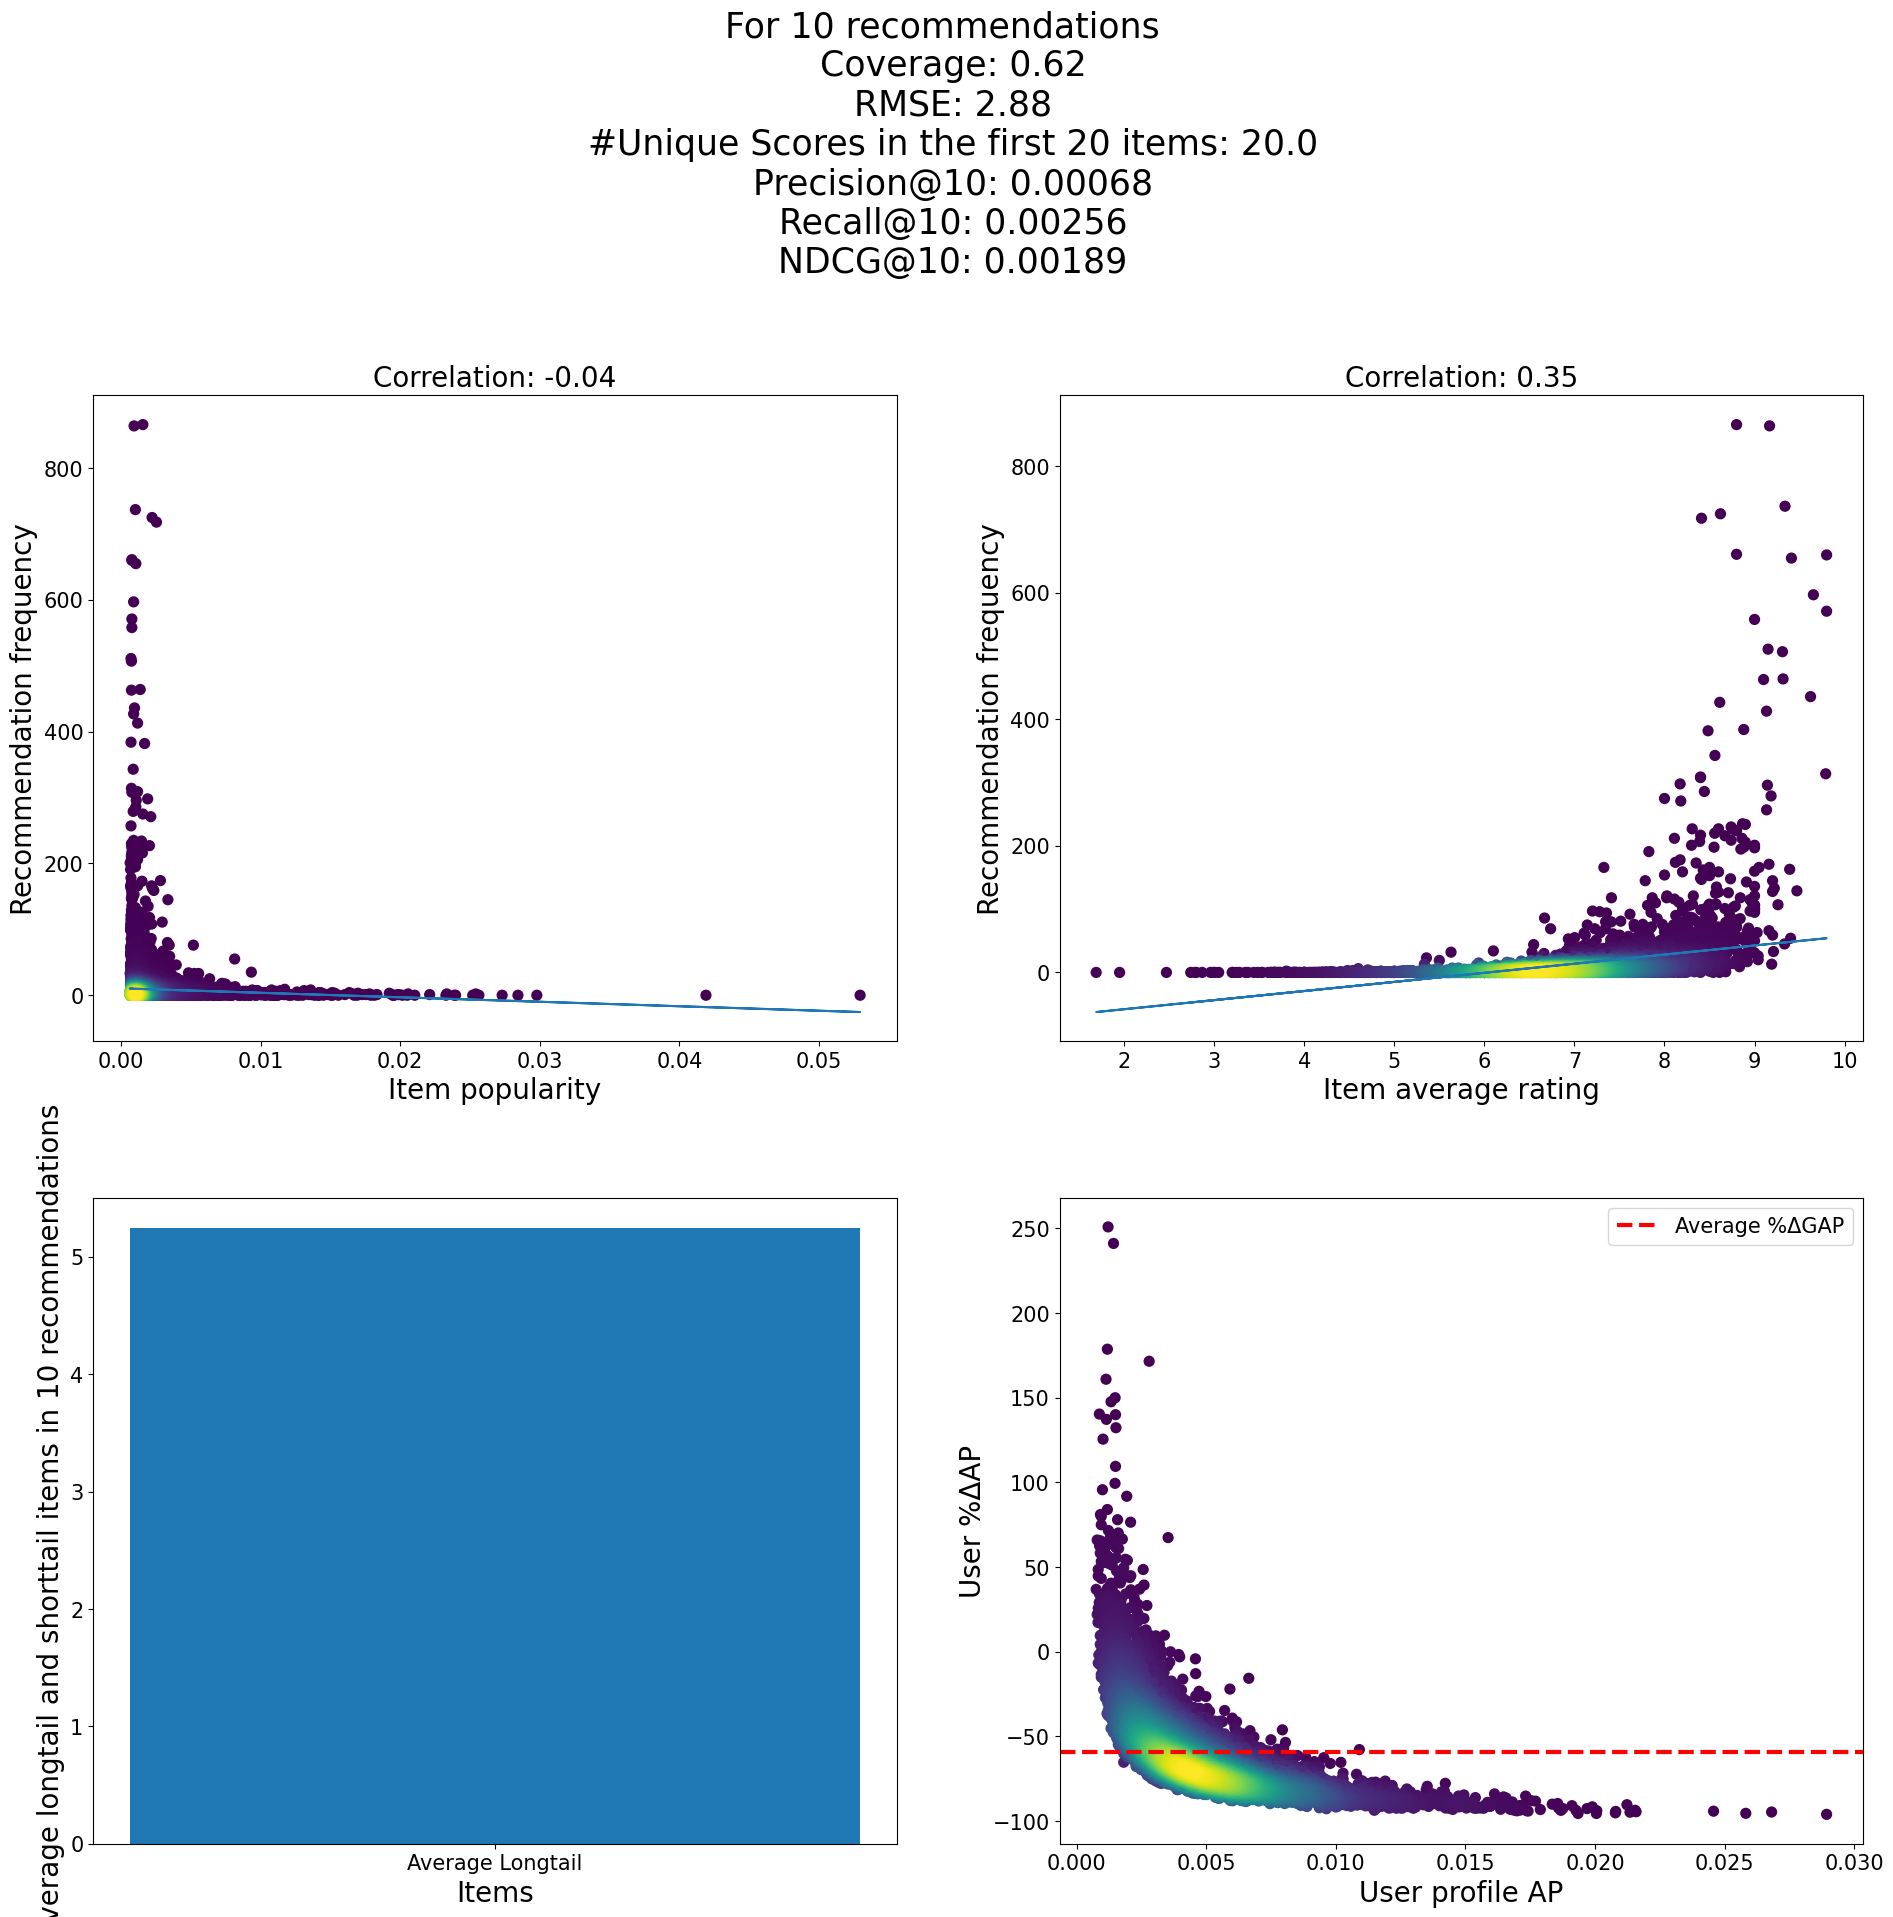

In [8]:
# choose algorithm
algorithm_lkpy = als.BiasedMF
algo_name = "MF"
versions = algo_versions[algo_name]

# for every data strategy
for i in range(len(data_strategies)):
    data_strategy = data_strategies[i]
    # generate the data
    ratings = generate_data(
        strategy=data_strategy, copying_dataset=fairbook_ratings, user_perc=0.2
    )

    # for every 'fixed' version of the algorithm
    for args in versions:
        print(data_strategy, args)

        p = "best_parameters/" + algo_name + "/" + data_strategy + "_" + str(args) + ".pkl"
        if os.path.isfile(p):
            print("We got them already")
            with open(p, "rb") as f:
                best_params = pickle.load(f)
        else:
            print("We have to compute them now")
            # optimize for this fixed version
            best_params = optimize_lkpy(
                ratings=ratings, algorithm_name=algo_name, args=args, max_evals=20, partition_way = 'row'
            )
    
            # save the best parameters for this fixed version
    
            with open(
                "best_parameters/"
                + algo_name
                + "/"
                + data_strategy
                + "_"
                + str(args)
                + ".pkl",
                "wb",
            ) as f:
                pickle.dump(best_params, f)

        
        # # optimize for this fixed version
        # best_params = optimize_lkpy(
        #     ratings=ratings,
        #     algorithm_name=algo_name,
        #     args=args,
        #     partition_way="row",
        #     max_evals=20,
        # )

        # # save the best parameters for this fixed version

        # with open(
        #     "best_parameters/"
        #     + algo_name
        #     + "/"
        #     + data_strategy
        #     + "_"
        #     + str(args)
        #     + ".pkl",
        #     "wb",
        # ) as f:
        #     pickle.dump(best_params, f)

        reg_list = [0, 0.001, 0.01, 0.1]
        features_list = [10, 50, 100]
        optimal_reg = reg_list[best_params["reg"]]
        optimal_features = features_list[best_params["features"]]

        # run the training and evaluation for the fixed version + the best other parameters
        pop_biases_lkpy, metrics_dict_lkpy = modelling_mf.train_algorithm(
            algorithm=lambda: algorithm_lkpy(
                features=optimal_features, reg=optimal_reg, bias=args["bias"]
            ),
            algo_name=algo_name,
            ratings=ratings,
            evaluation_way=evaluation_way,
            verbose=verbose,
            n=nr_recs,
            sampling_strategy=sampling_strategy,
            partition_way=partition_way,
            plot=plot,
            data_strategy=data_strategy,
            args=args,
            save_plot=save_plot,
        )

        # Save metrics!
        with open(
            "experimental_results/"
            + algo_name
            + "/"
            + data_strategy
            + "_"
            + str(args)
            + ".pkl",
            "wb",
        ) as f:
            pickle.dump(metrics_dict_lkpy, f)
        with open('experimental_results/'+algo_name+'/detailed_per_item_'+data_strategy+'_'+str(args)+'.pkl', 'wb') as f:
            pickle.dump(pop_biases_lkpy, f)

## Optimize, train, evaluate Cornac
- **Algorithm**
- **Fixed parameters**
- **To-optimize parameters**

In [12]:
algo_versions = {"CornacMF": [{"bias": True}, {"bias": False}]}

uniformly_random {'bias': True}
We got them already

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.8802 |    0.2489 |   0.0535

nr of longtail 0
0.0

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.8526 |    0.2733 |   0.0526

nr of longtail 0
0.0

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.8464 |    0.2786 |   0.0701

nr of longtail 0
0.0

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.8685 |    0.2658 |   0.0542

nr of longtail 0
0.0

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.9099 |    0.2619 |   0.0511

nr of longtail 0
0.0


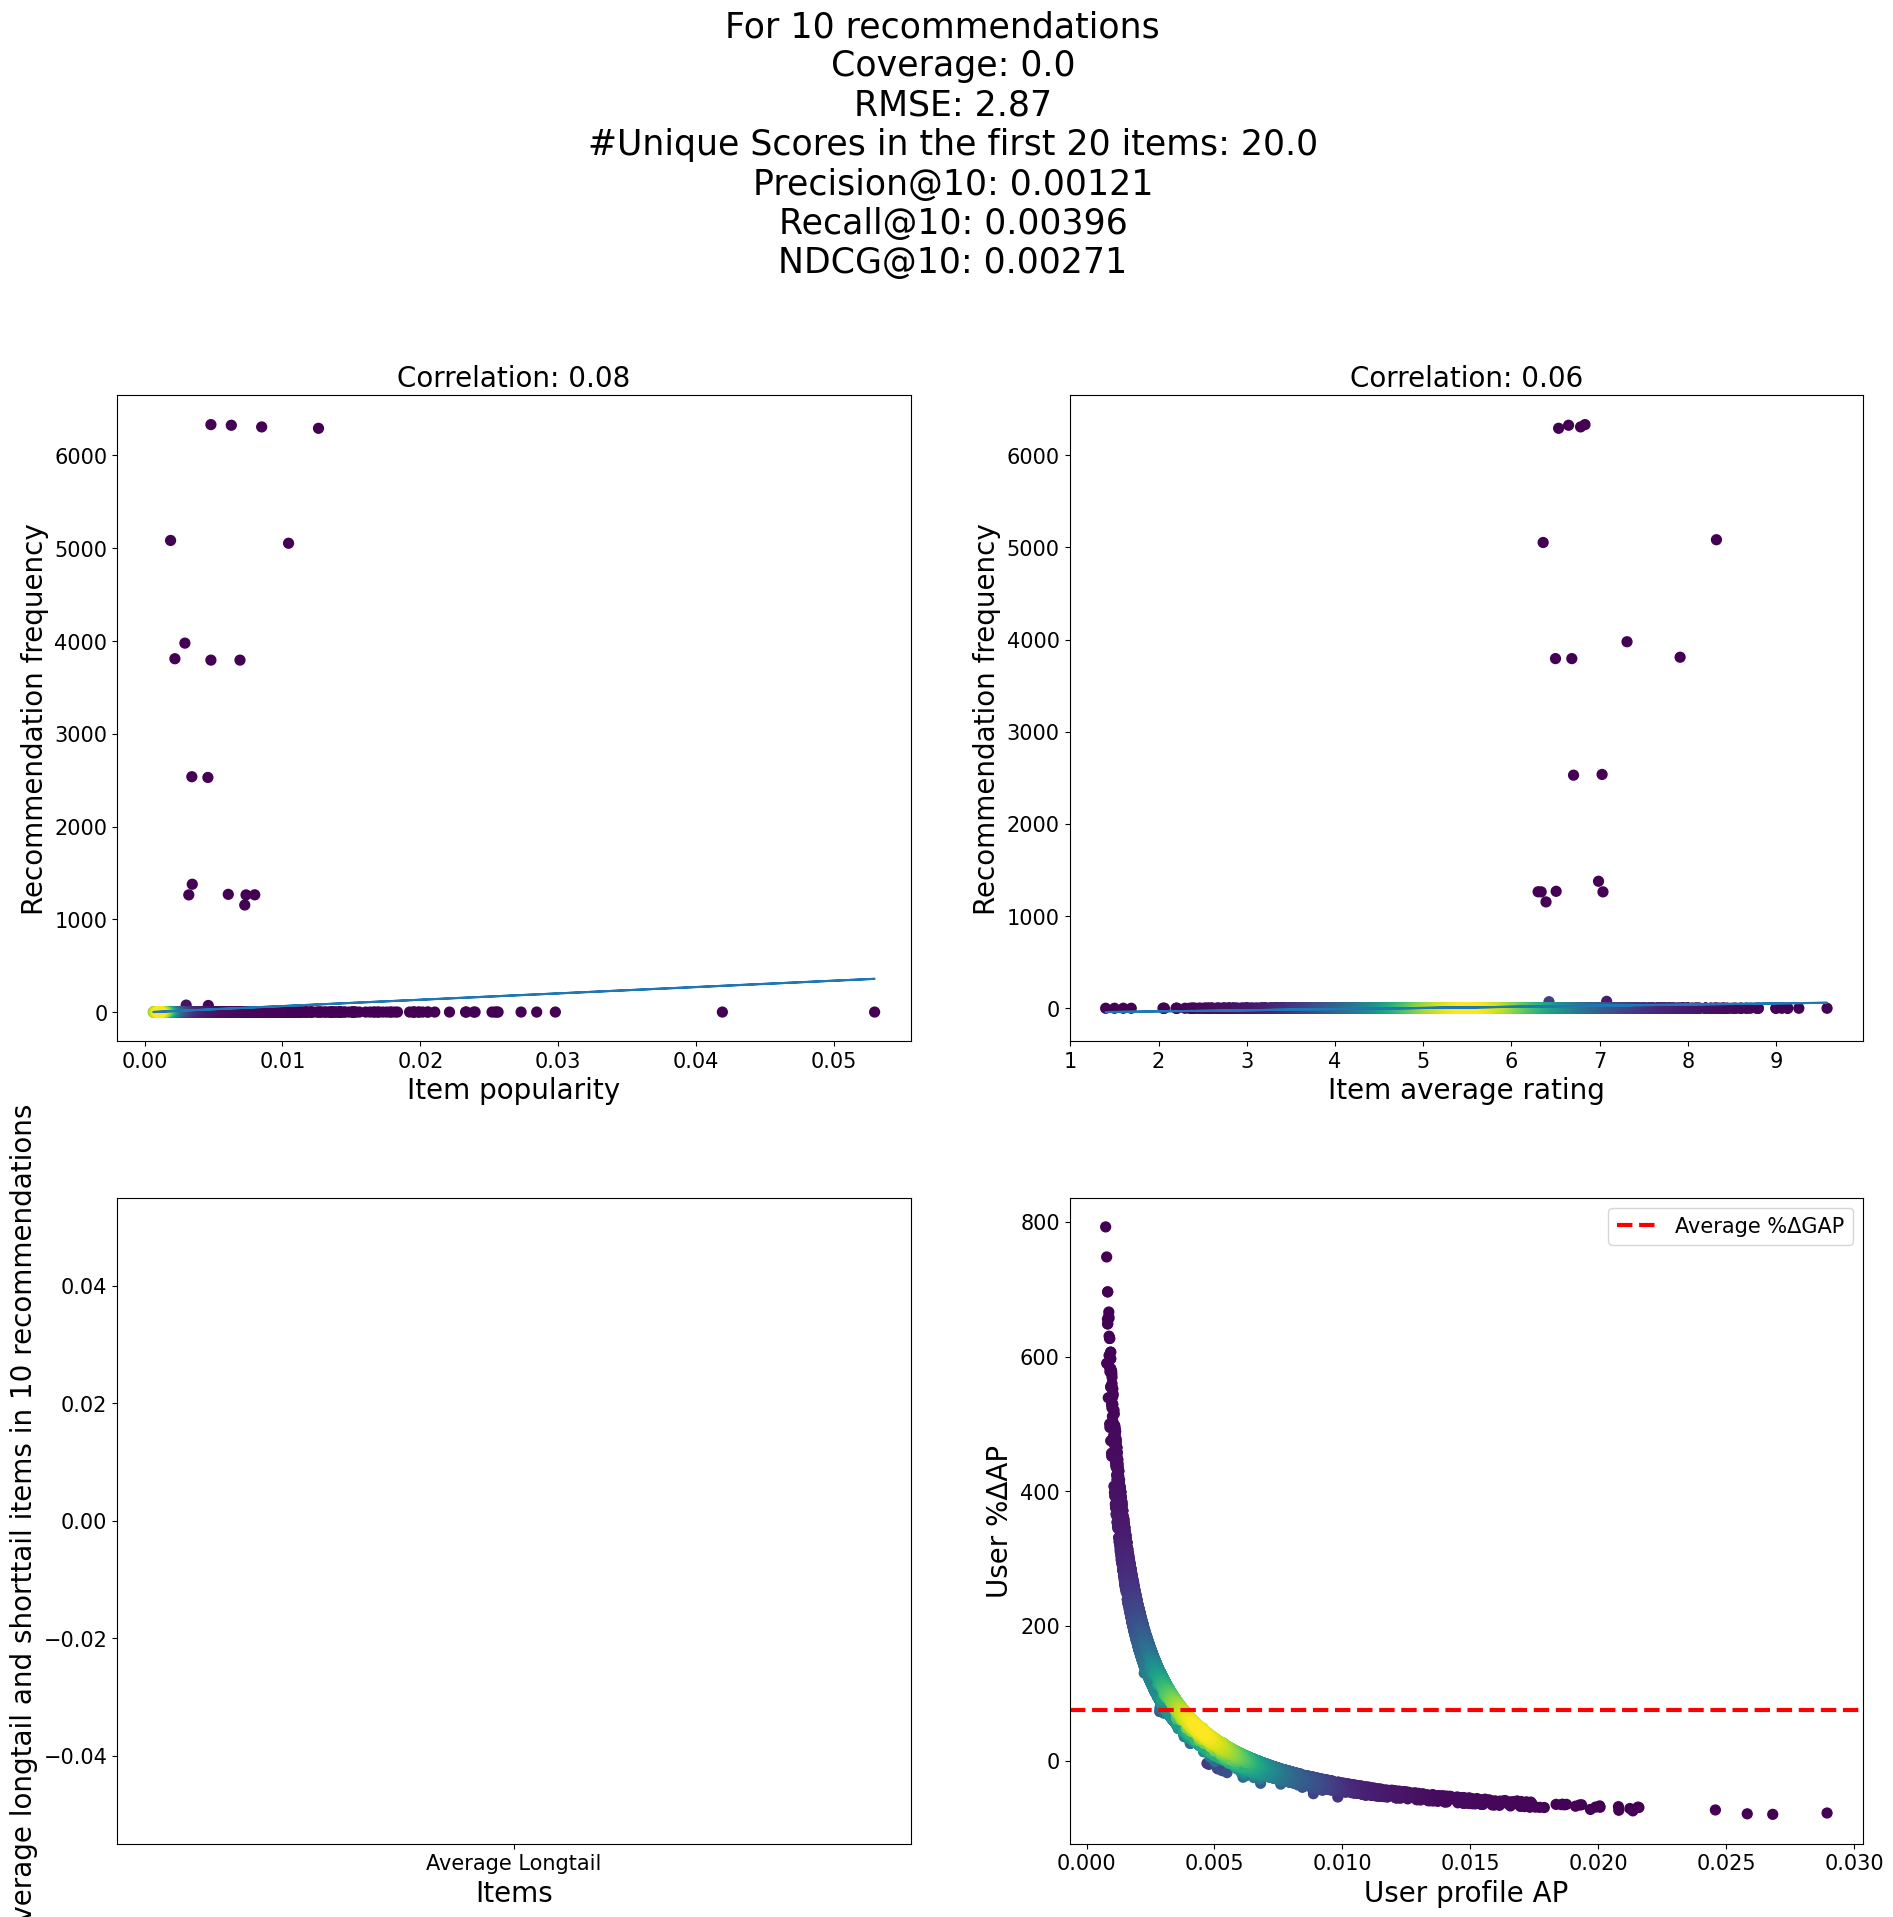

uniformly_random {'bias': False}
We got them already

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 3.2085 |    0.1048 |   0.0520

nr of longtail 11761
9.246069182389936

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 3.1629 |    0.1005 |   0.0495

nr of longtail 12104
9.515723270440251

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 3.1695 |    0.1047 |   0.0527

nr of longtail 10230
8.04245283018868

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 3.1891 |    0.1035 |   0.0517

nr of longtail 12103
9.522423288749016

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 3.2183 |    0.1025 |   0.0502

nr of longtail 12093
9.514555468135326


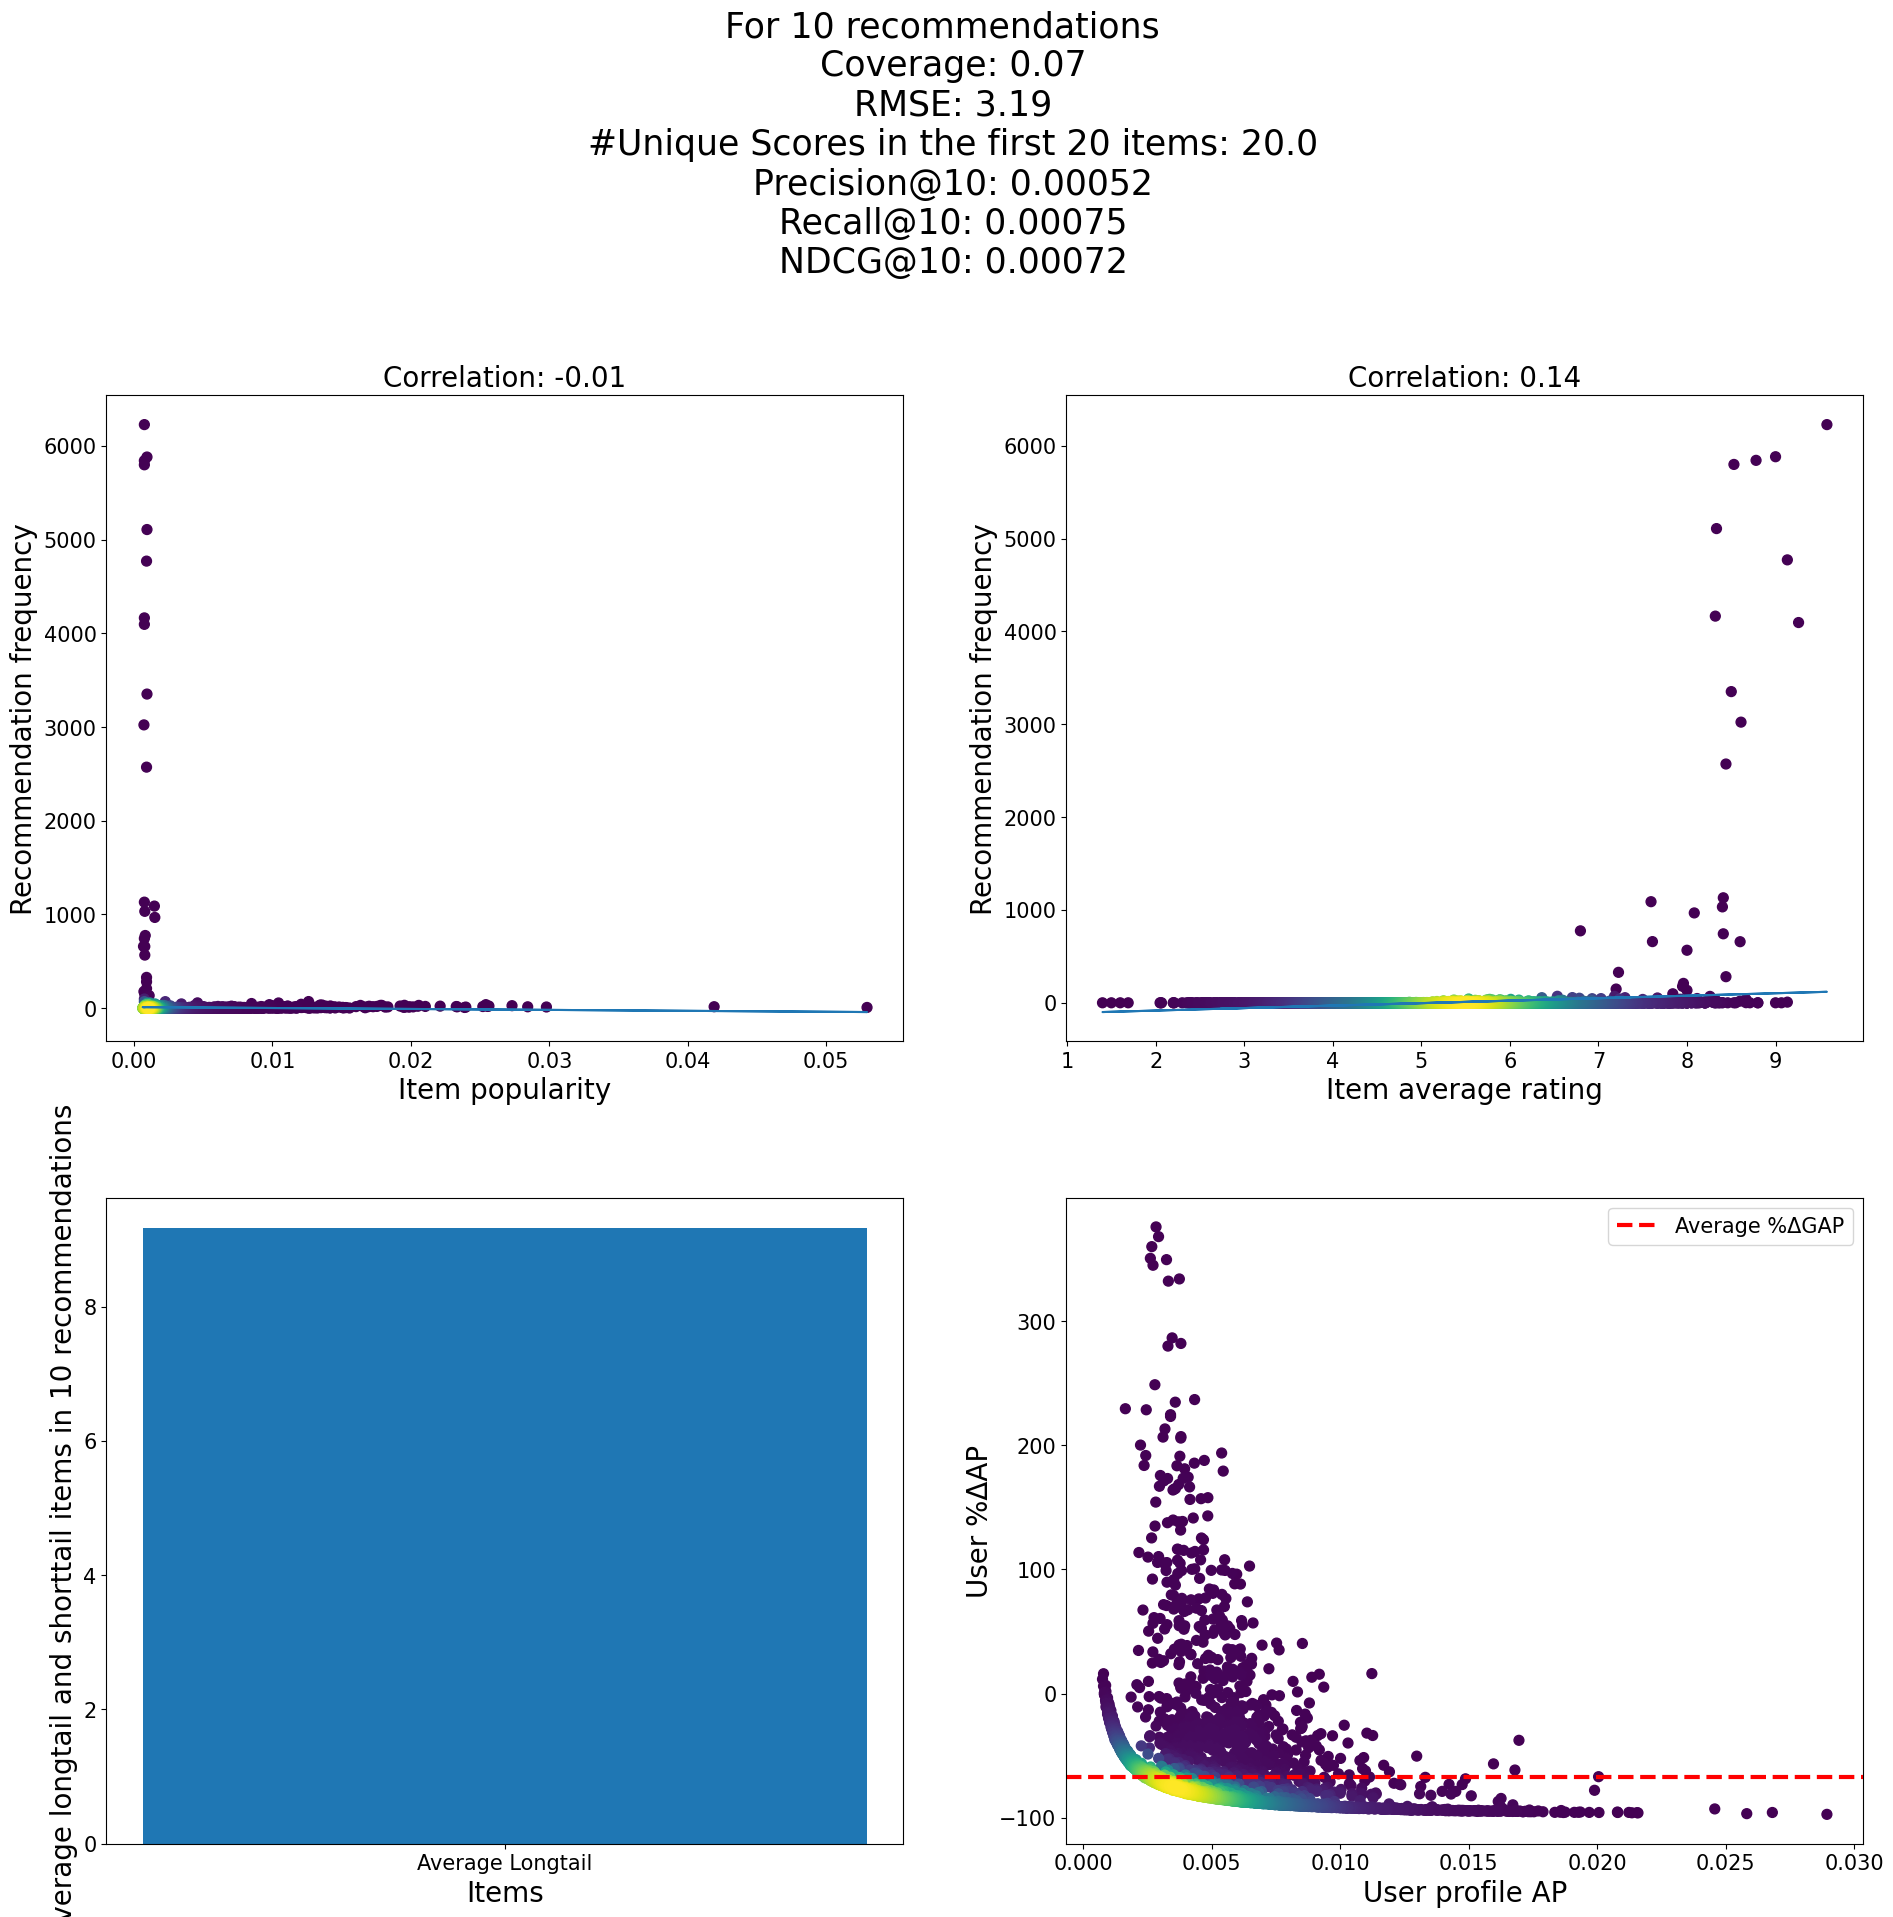

popularity_good {'bias': True}
We got them already

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 0.8131 |    0.1851 |   0.0530

nr of longtail 0
0.0

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 0.8146 |    0.1869 |   0.0506

nr of longtail 0
0.0

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 0.7982 |    0.1802 |   0.0554

nr of longtail 0
0.0

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 0.7913 |    0.2004 |   0.0680

nr of longtail 0
0.0

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 0.7934 |    0.1818 |   0.0512

nr of longtail 0
0.0


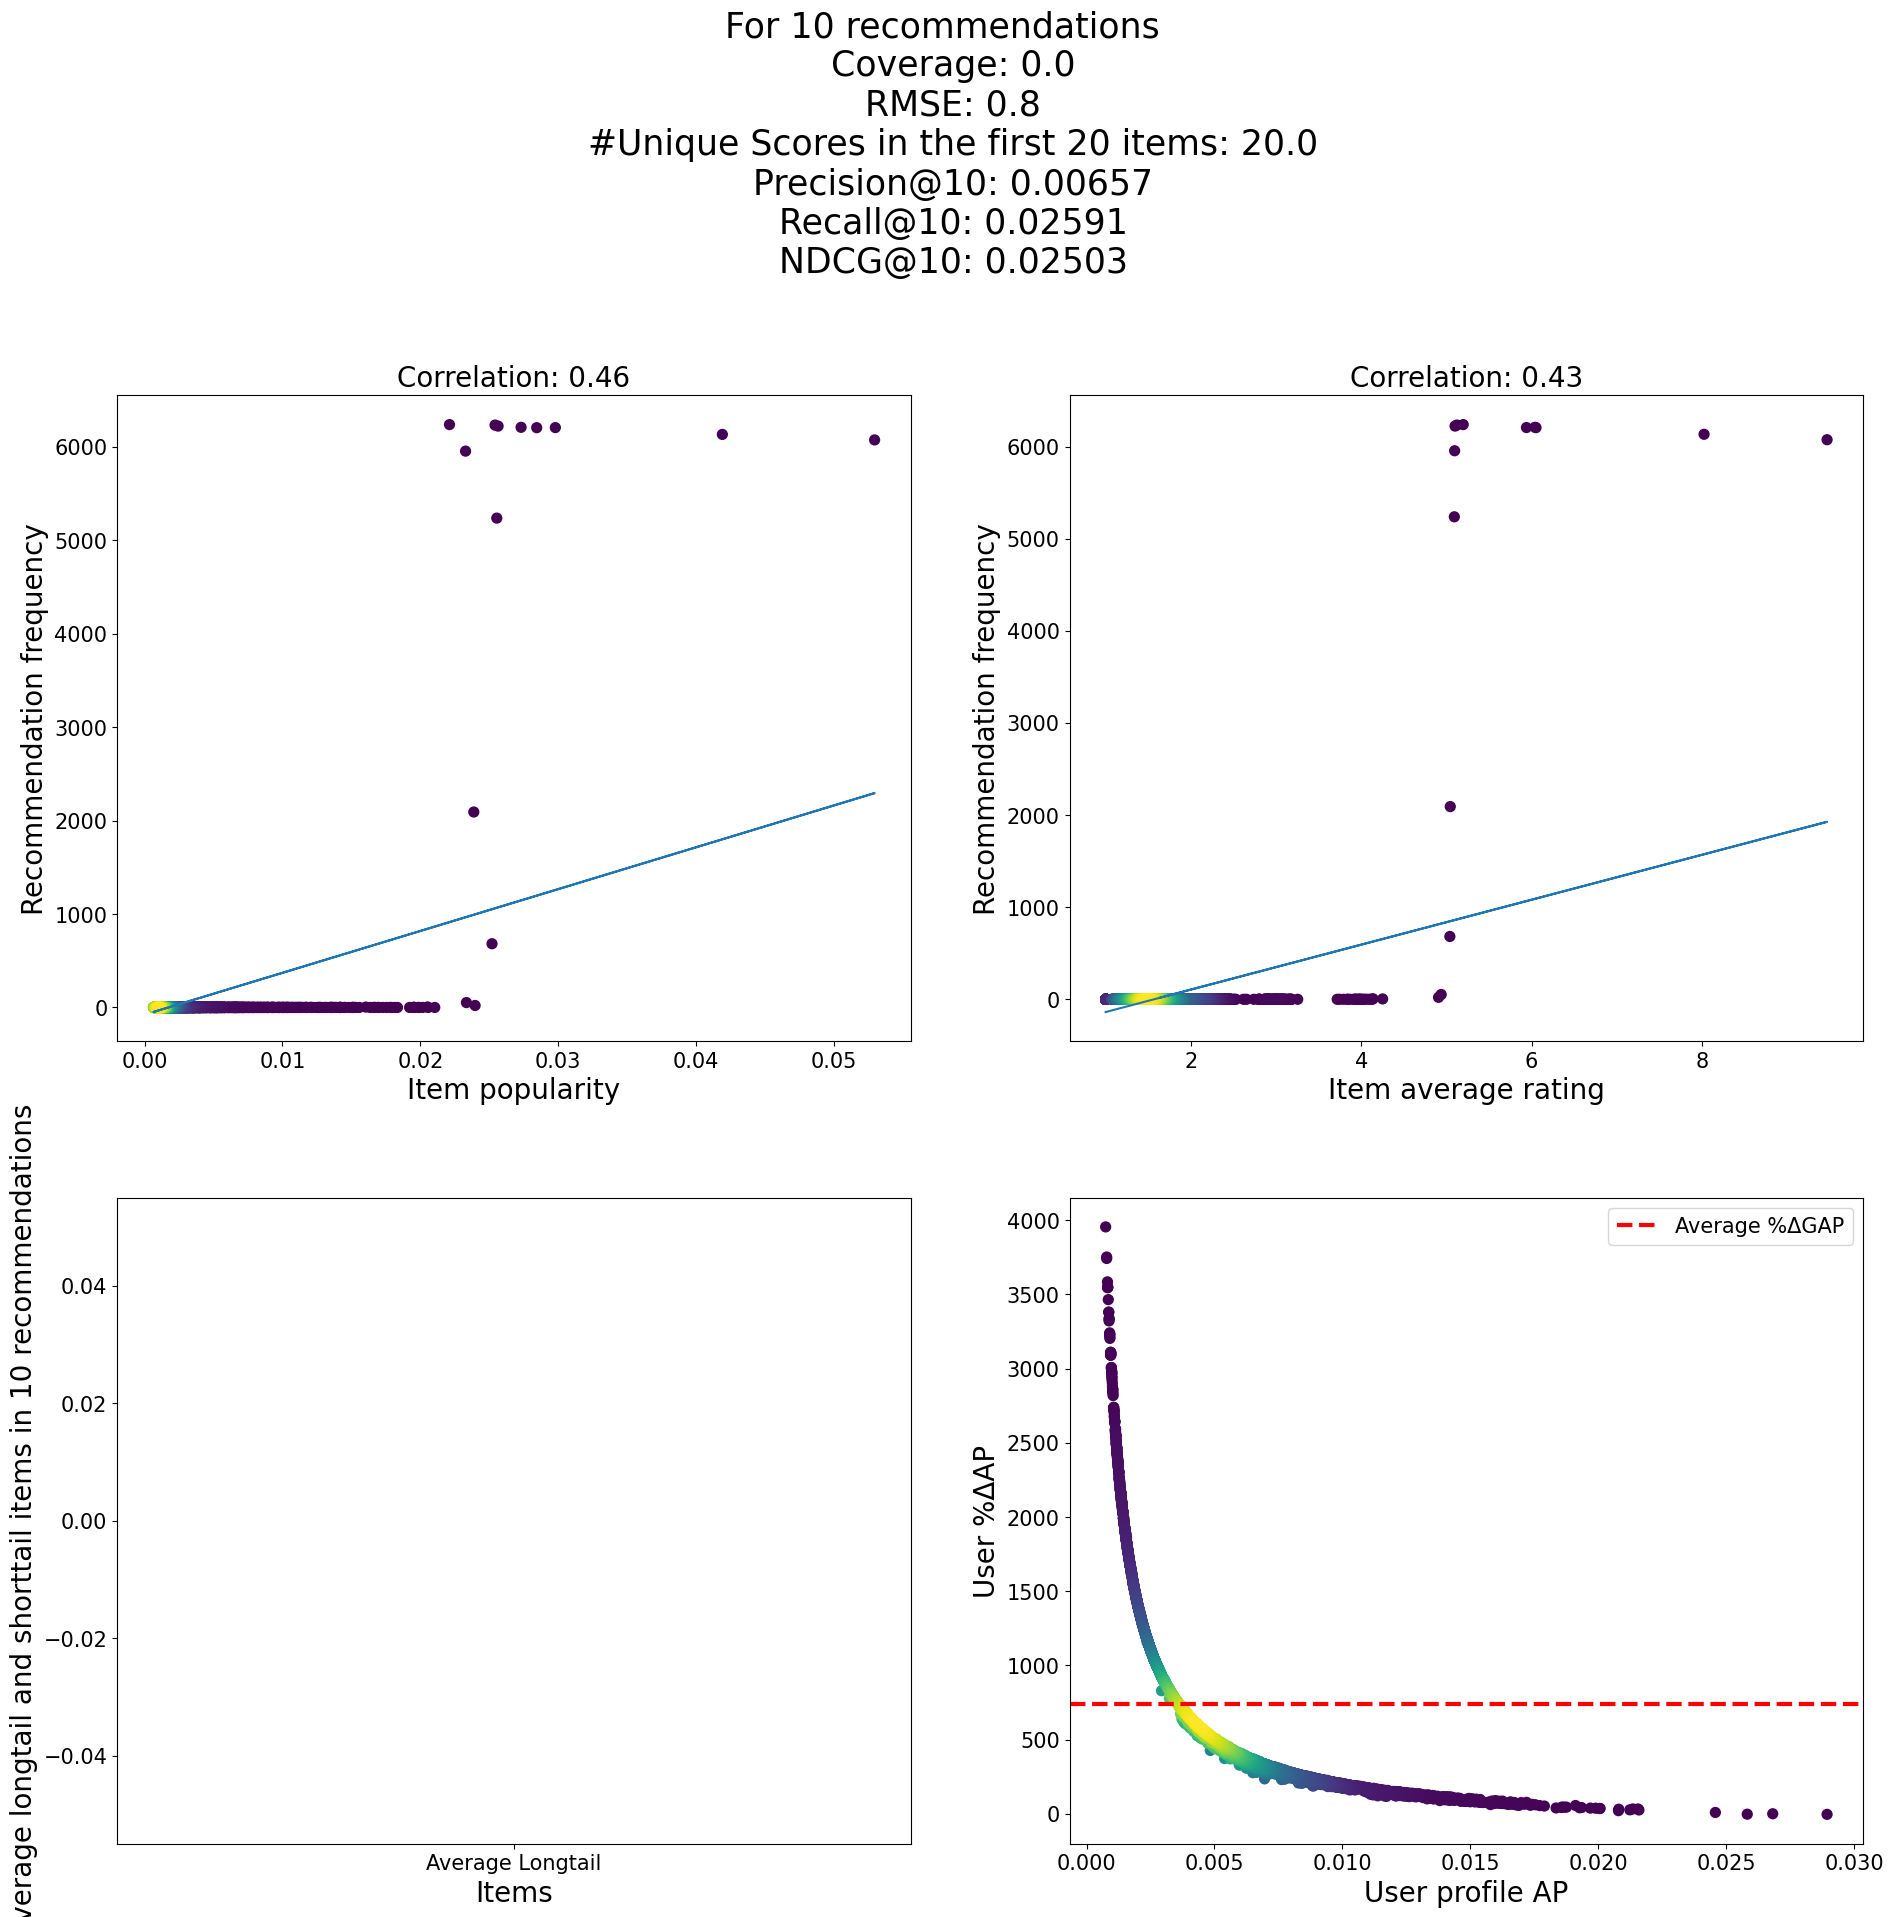

popularity_good {'bias': False}
We got them already

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 0.9411 |    0.2494 |   0.0519

nr of longtail 0
0.0

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 0.9454 |    0.2533 |   0.0499

nr of longtail 0
0.0

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 0.9312 |    0.2219 |   0.0528

nr of longtail 0
0.0

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 0.9512 |    0.2621 |   0.0529

nr of longtail 0
0.0

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 0.9300 |    0.2362 |   0.0499

nr of longtail 0
0.0


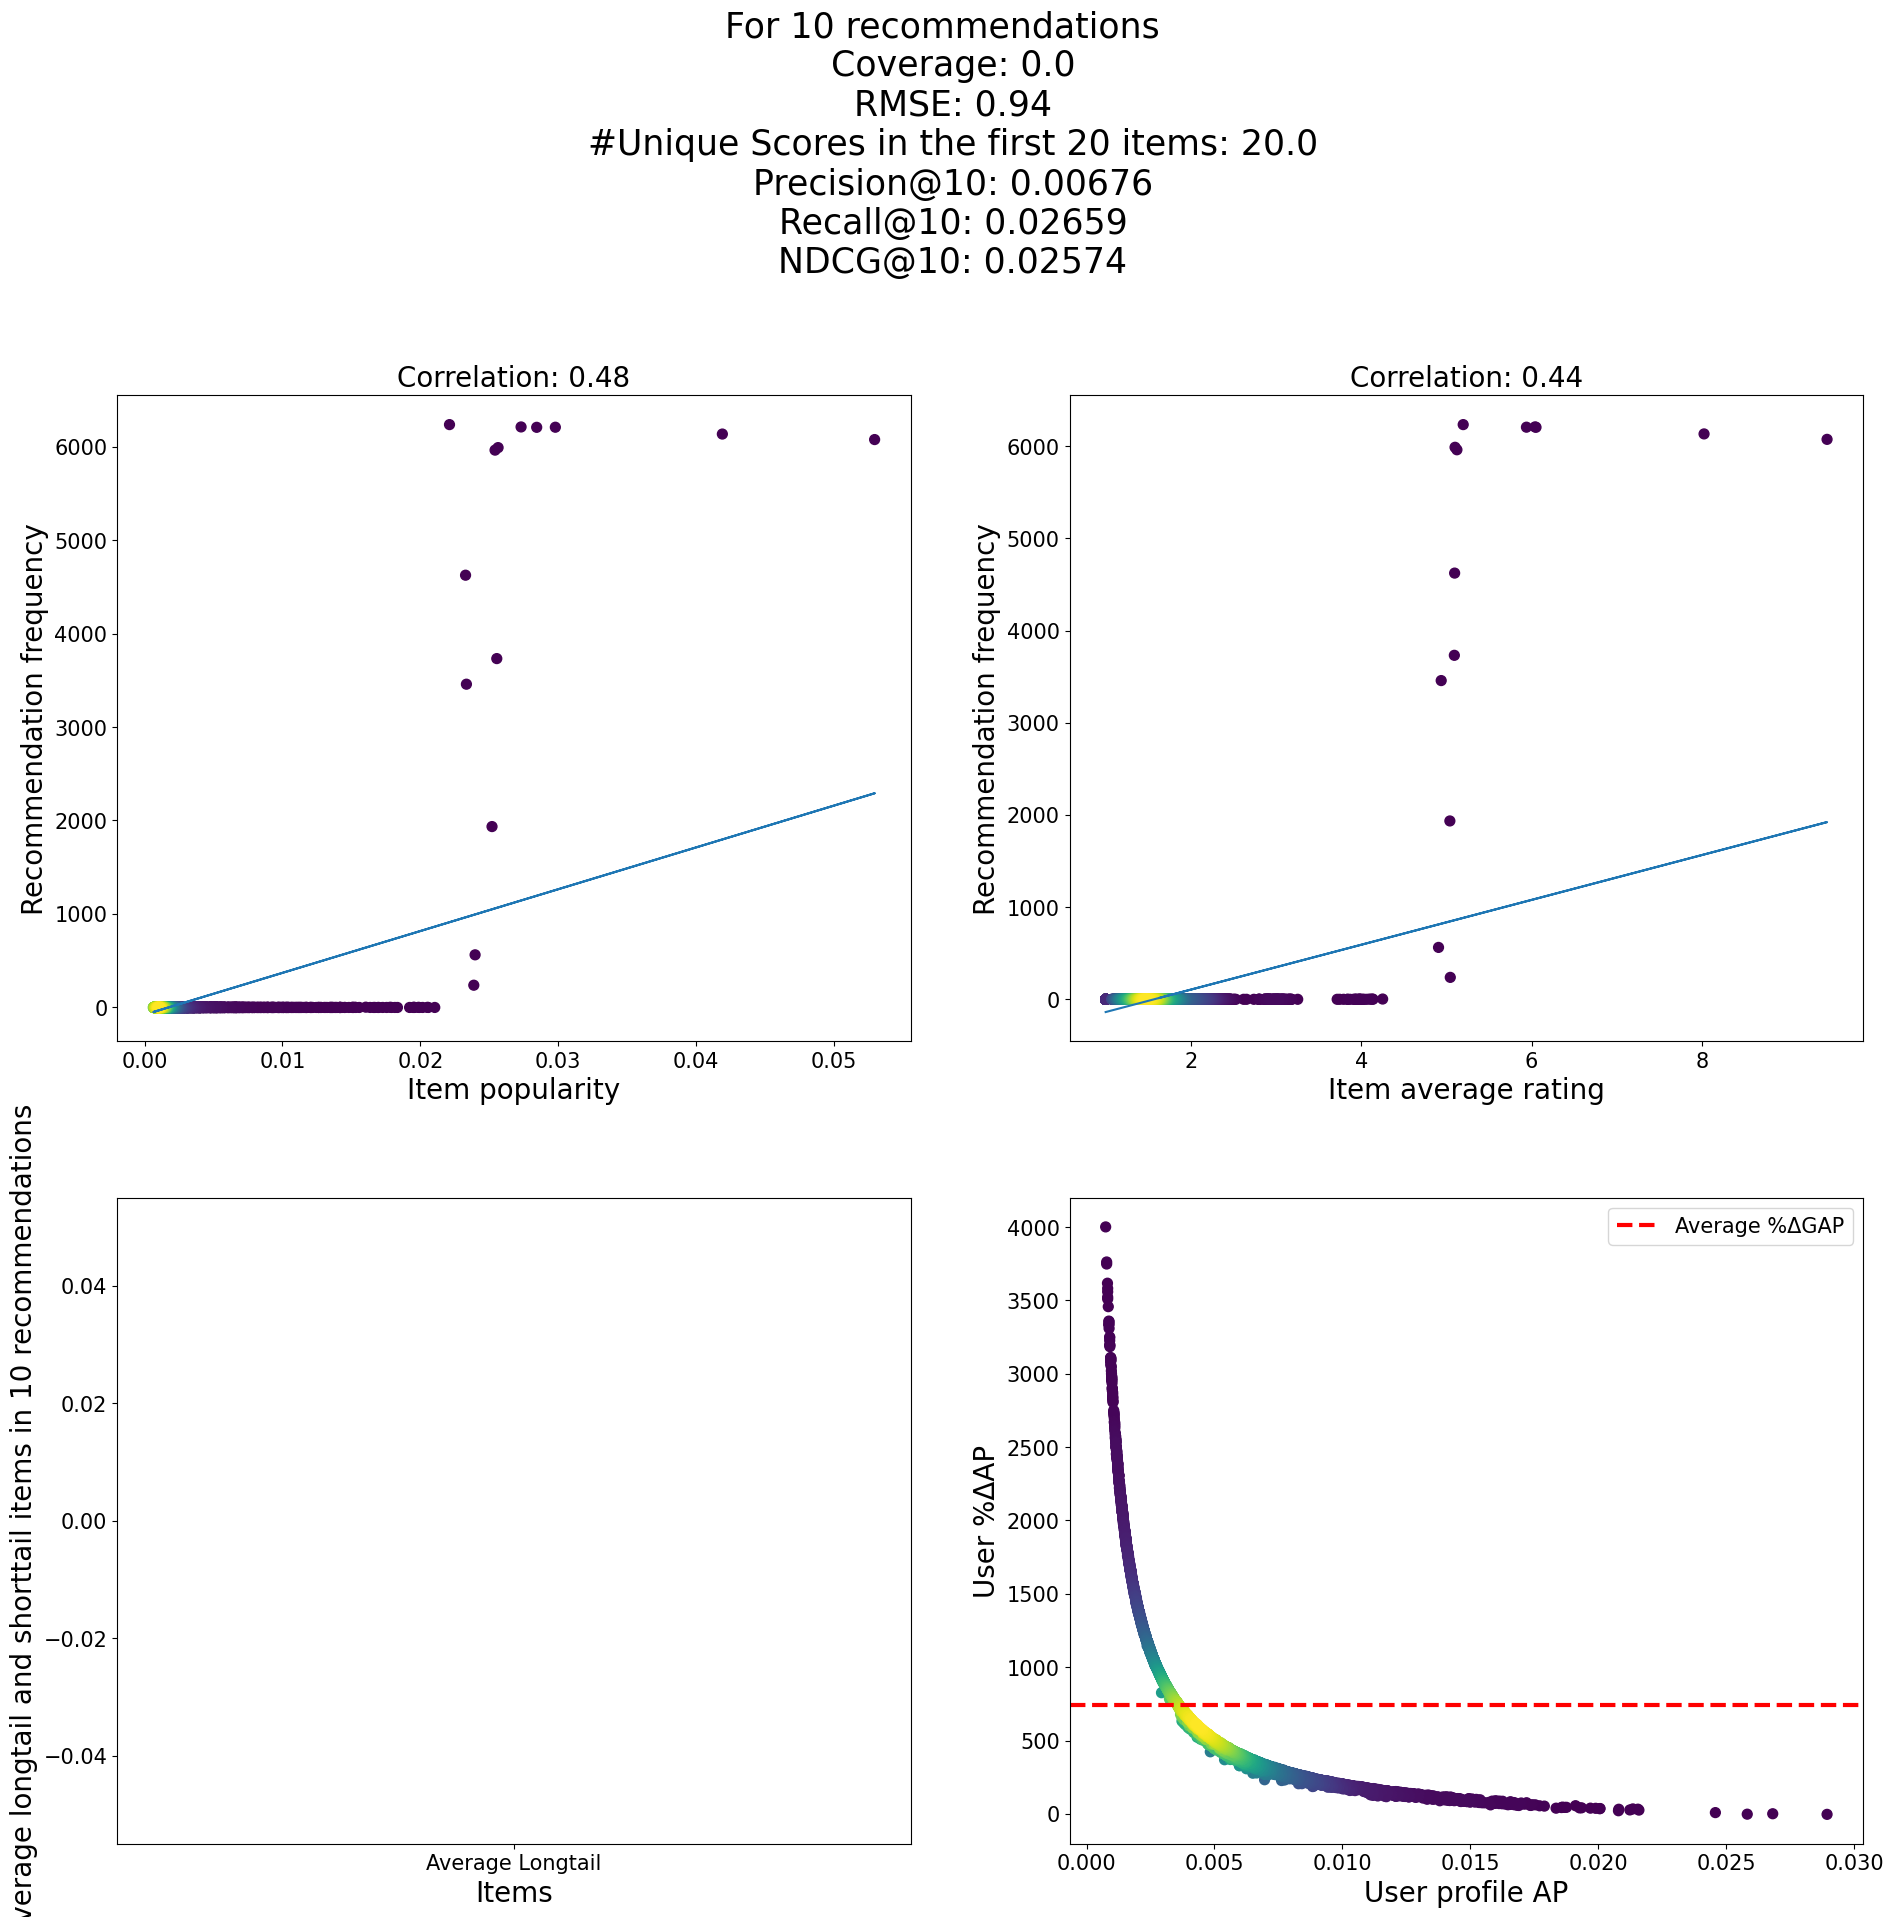

popularity_bad {'bias': True}
We got them already

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 0.7936 |    0.1782 |   0.0528

nr of longtail 0
0.0

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 0.8143 |    0.1950 |   0.0504

nr of longtail 0
0.0

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 0.7889 |    0.1791 |   0.0536

nr of longtail 0
0.0

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 0.7887 |    0.1778 |   0.0540

nr of longtail 0
0.0

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 0.7944 |    0.1755 |   0.0509

nr of longtail 0
0.0


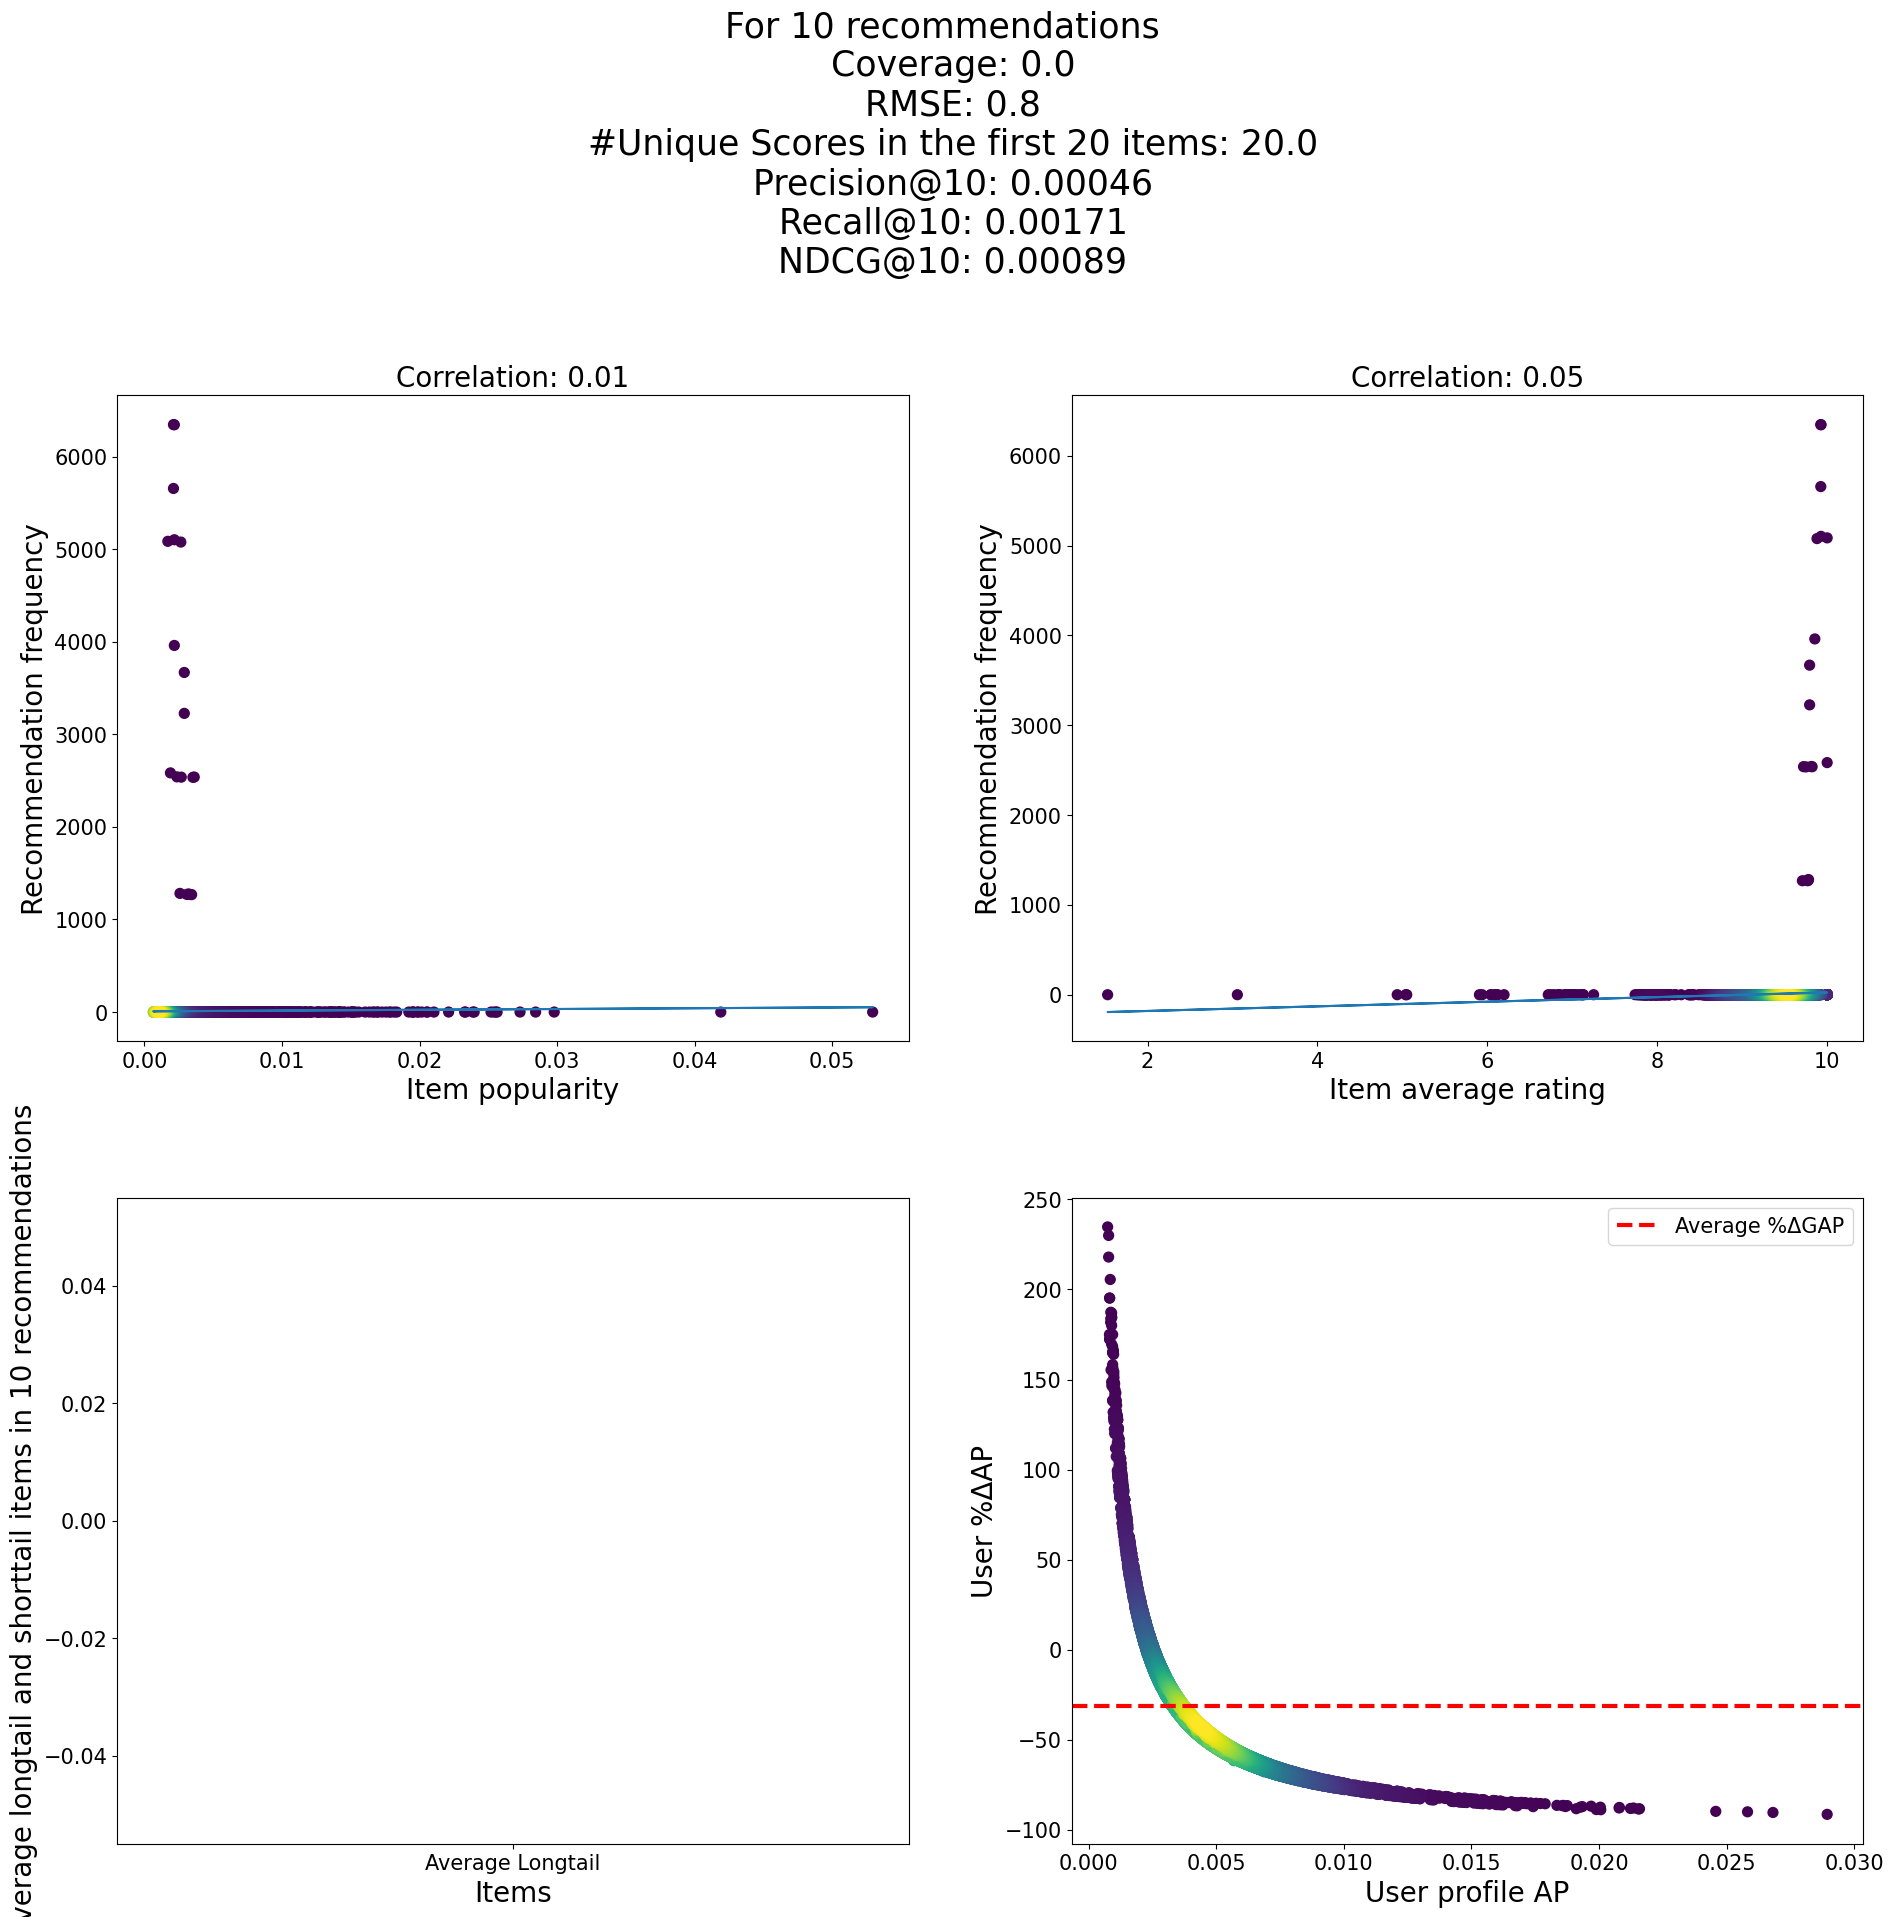

popularity_bad {'bias': False}
We got them already

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 0.8474 |    0.1092 |   0.0522

nr of longtail 11448
9.0

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 0.8672 |    0.1051 |   0.0510

nr of longtail 12421
9.76493710691824

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 0.8364 |    0.0979 |   0.0535

nr of longtail 11449
9.000786163522013

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 0.8525 |    0.1083 |   0.0530

nr of longtail 11267
8.864673485444532

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 0.8473 |    0.0985 |   0.0508

nr of longtail 11429
8.99213217938631


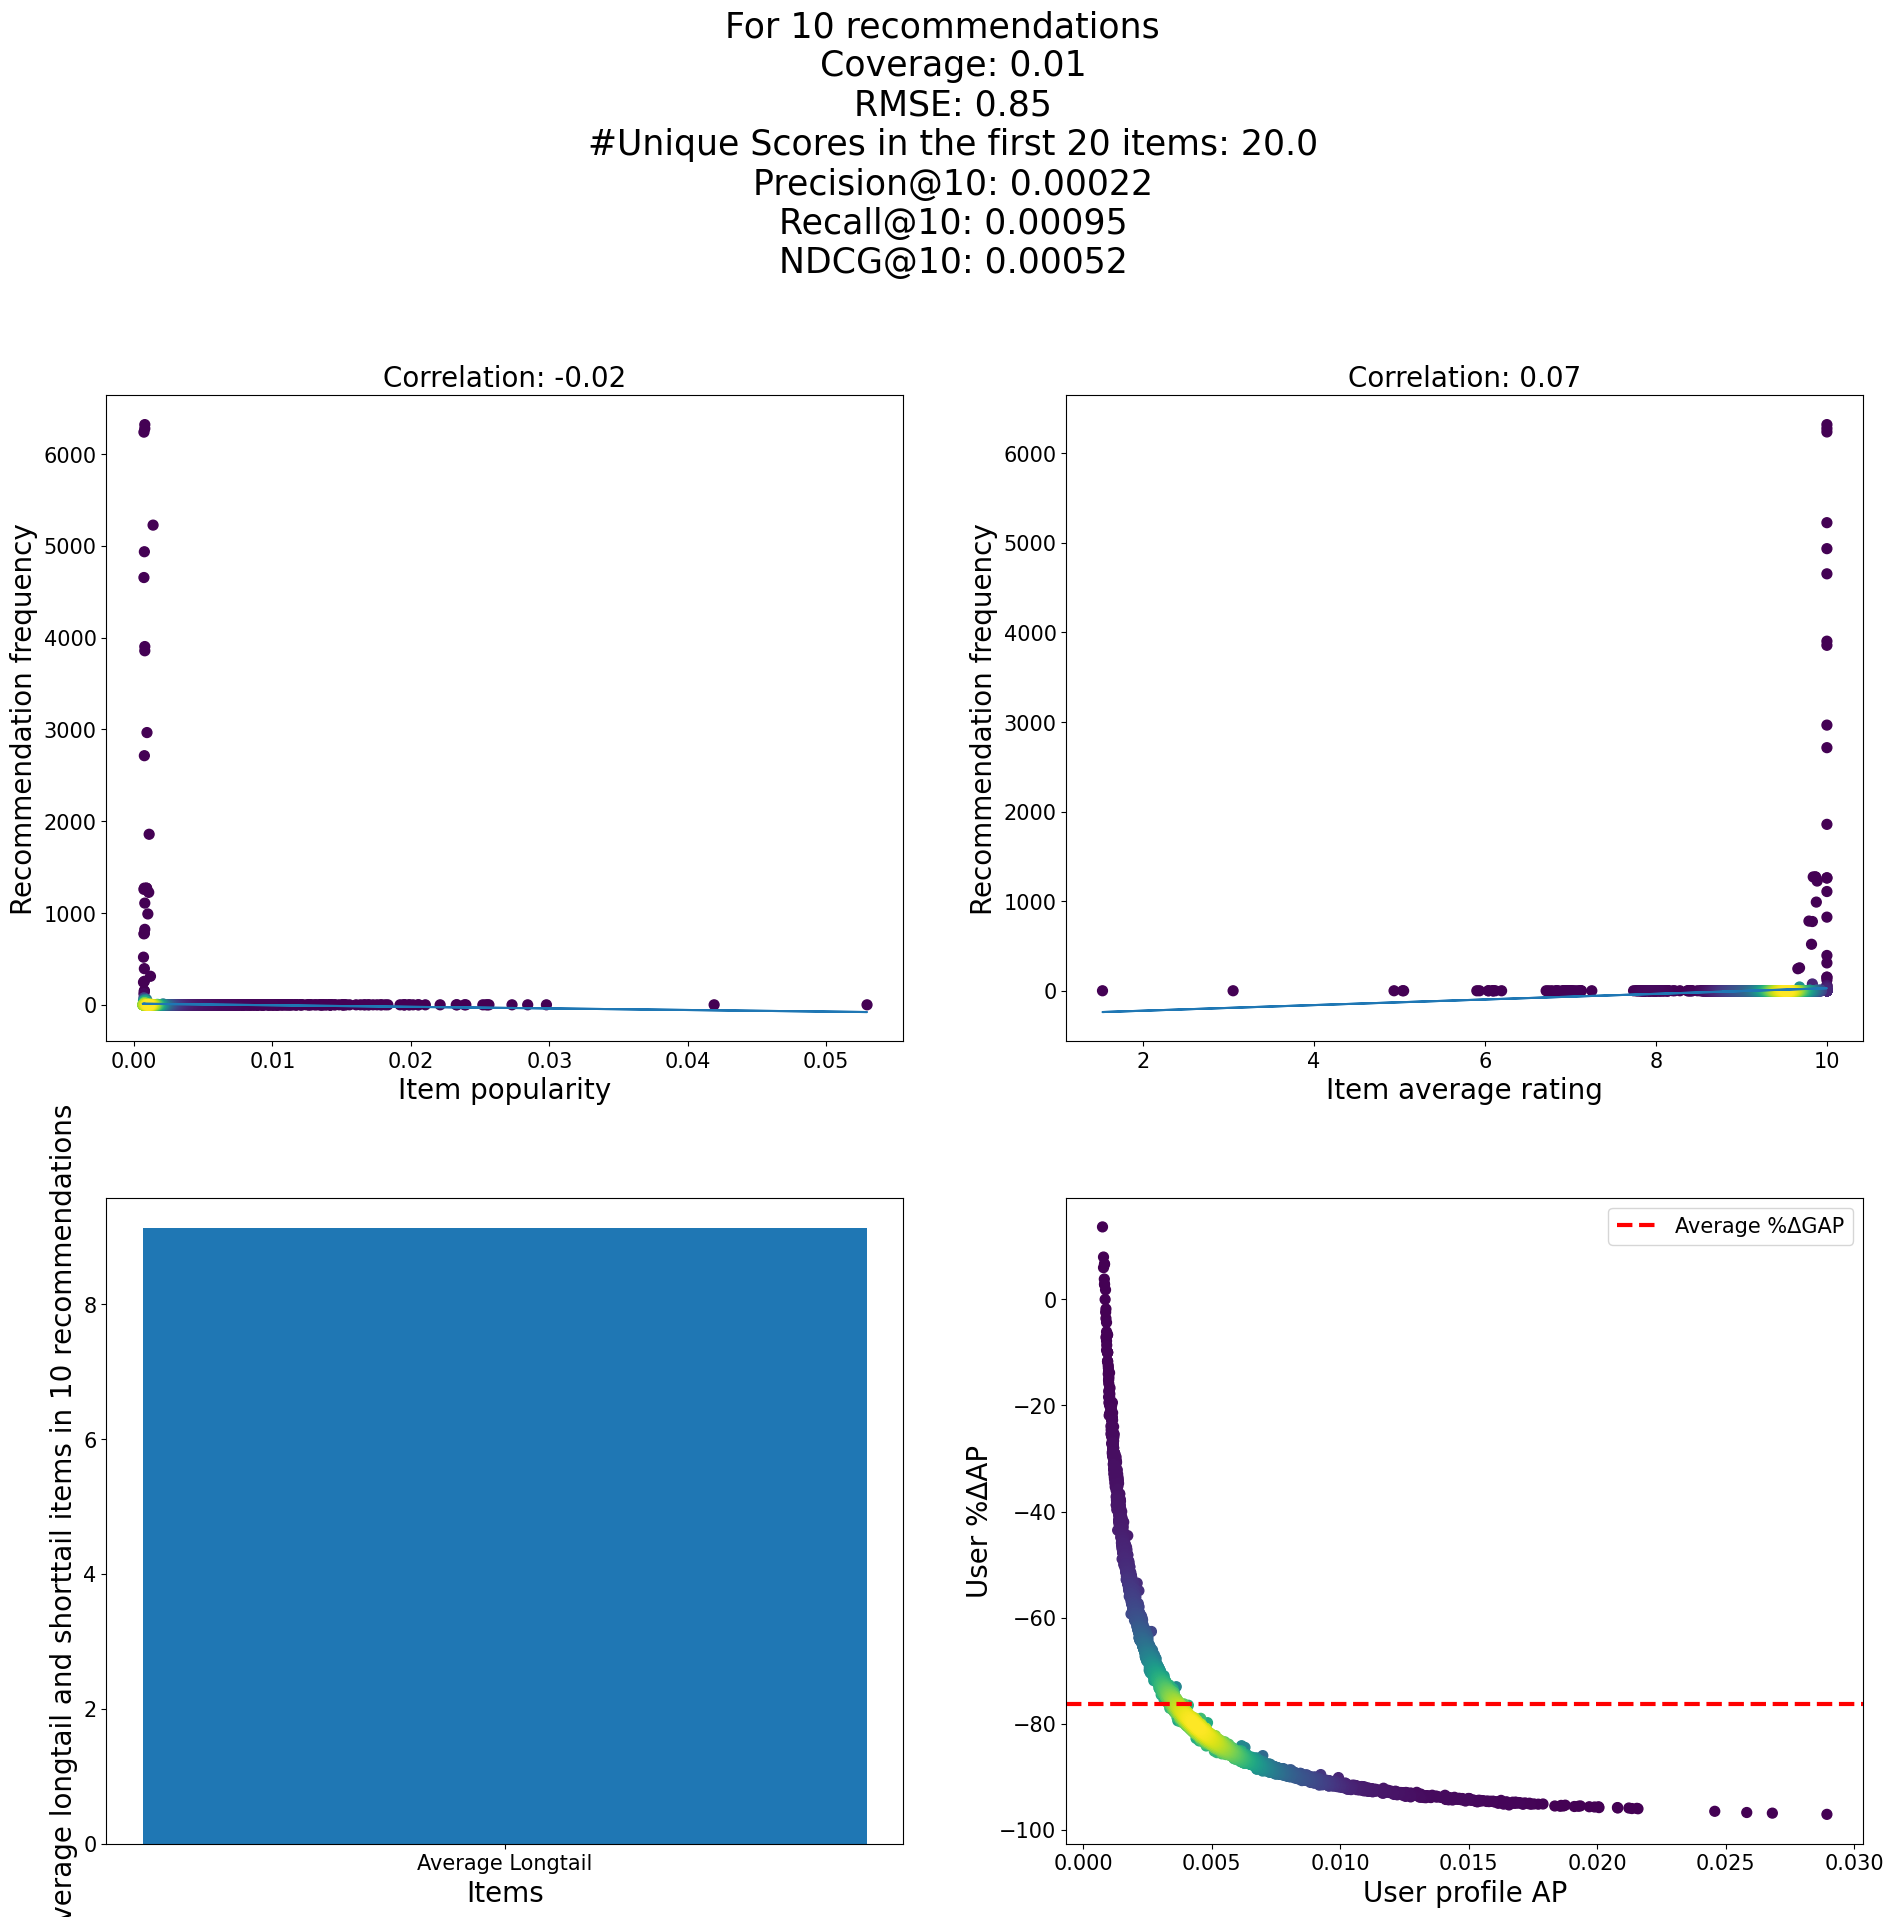

popularity_good_for_bp_ur {'bias': True}
We got them already

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.3402 |    0.1749 |   0.0634

nr of longtail 1271
0.9992138364779874

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.3206 |    0.1782 |   0.0511

nr of longtail 1269
0.9976415094339622

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.2184 |    0.1788 |   0.0539

nr of longtail 1256
0.9874213836477987

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.2696 |    0.2132 |   0.0649

nr of longtail 1263
0.993705743509048

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.3381 |    0.1977 |   0.0513

nr of longtail 181
0.14240755310778913


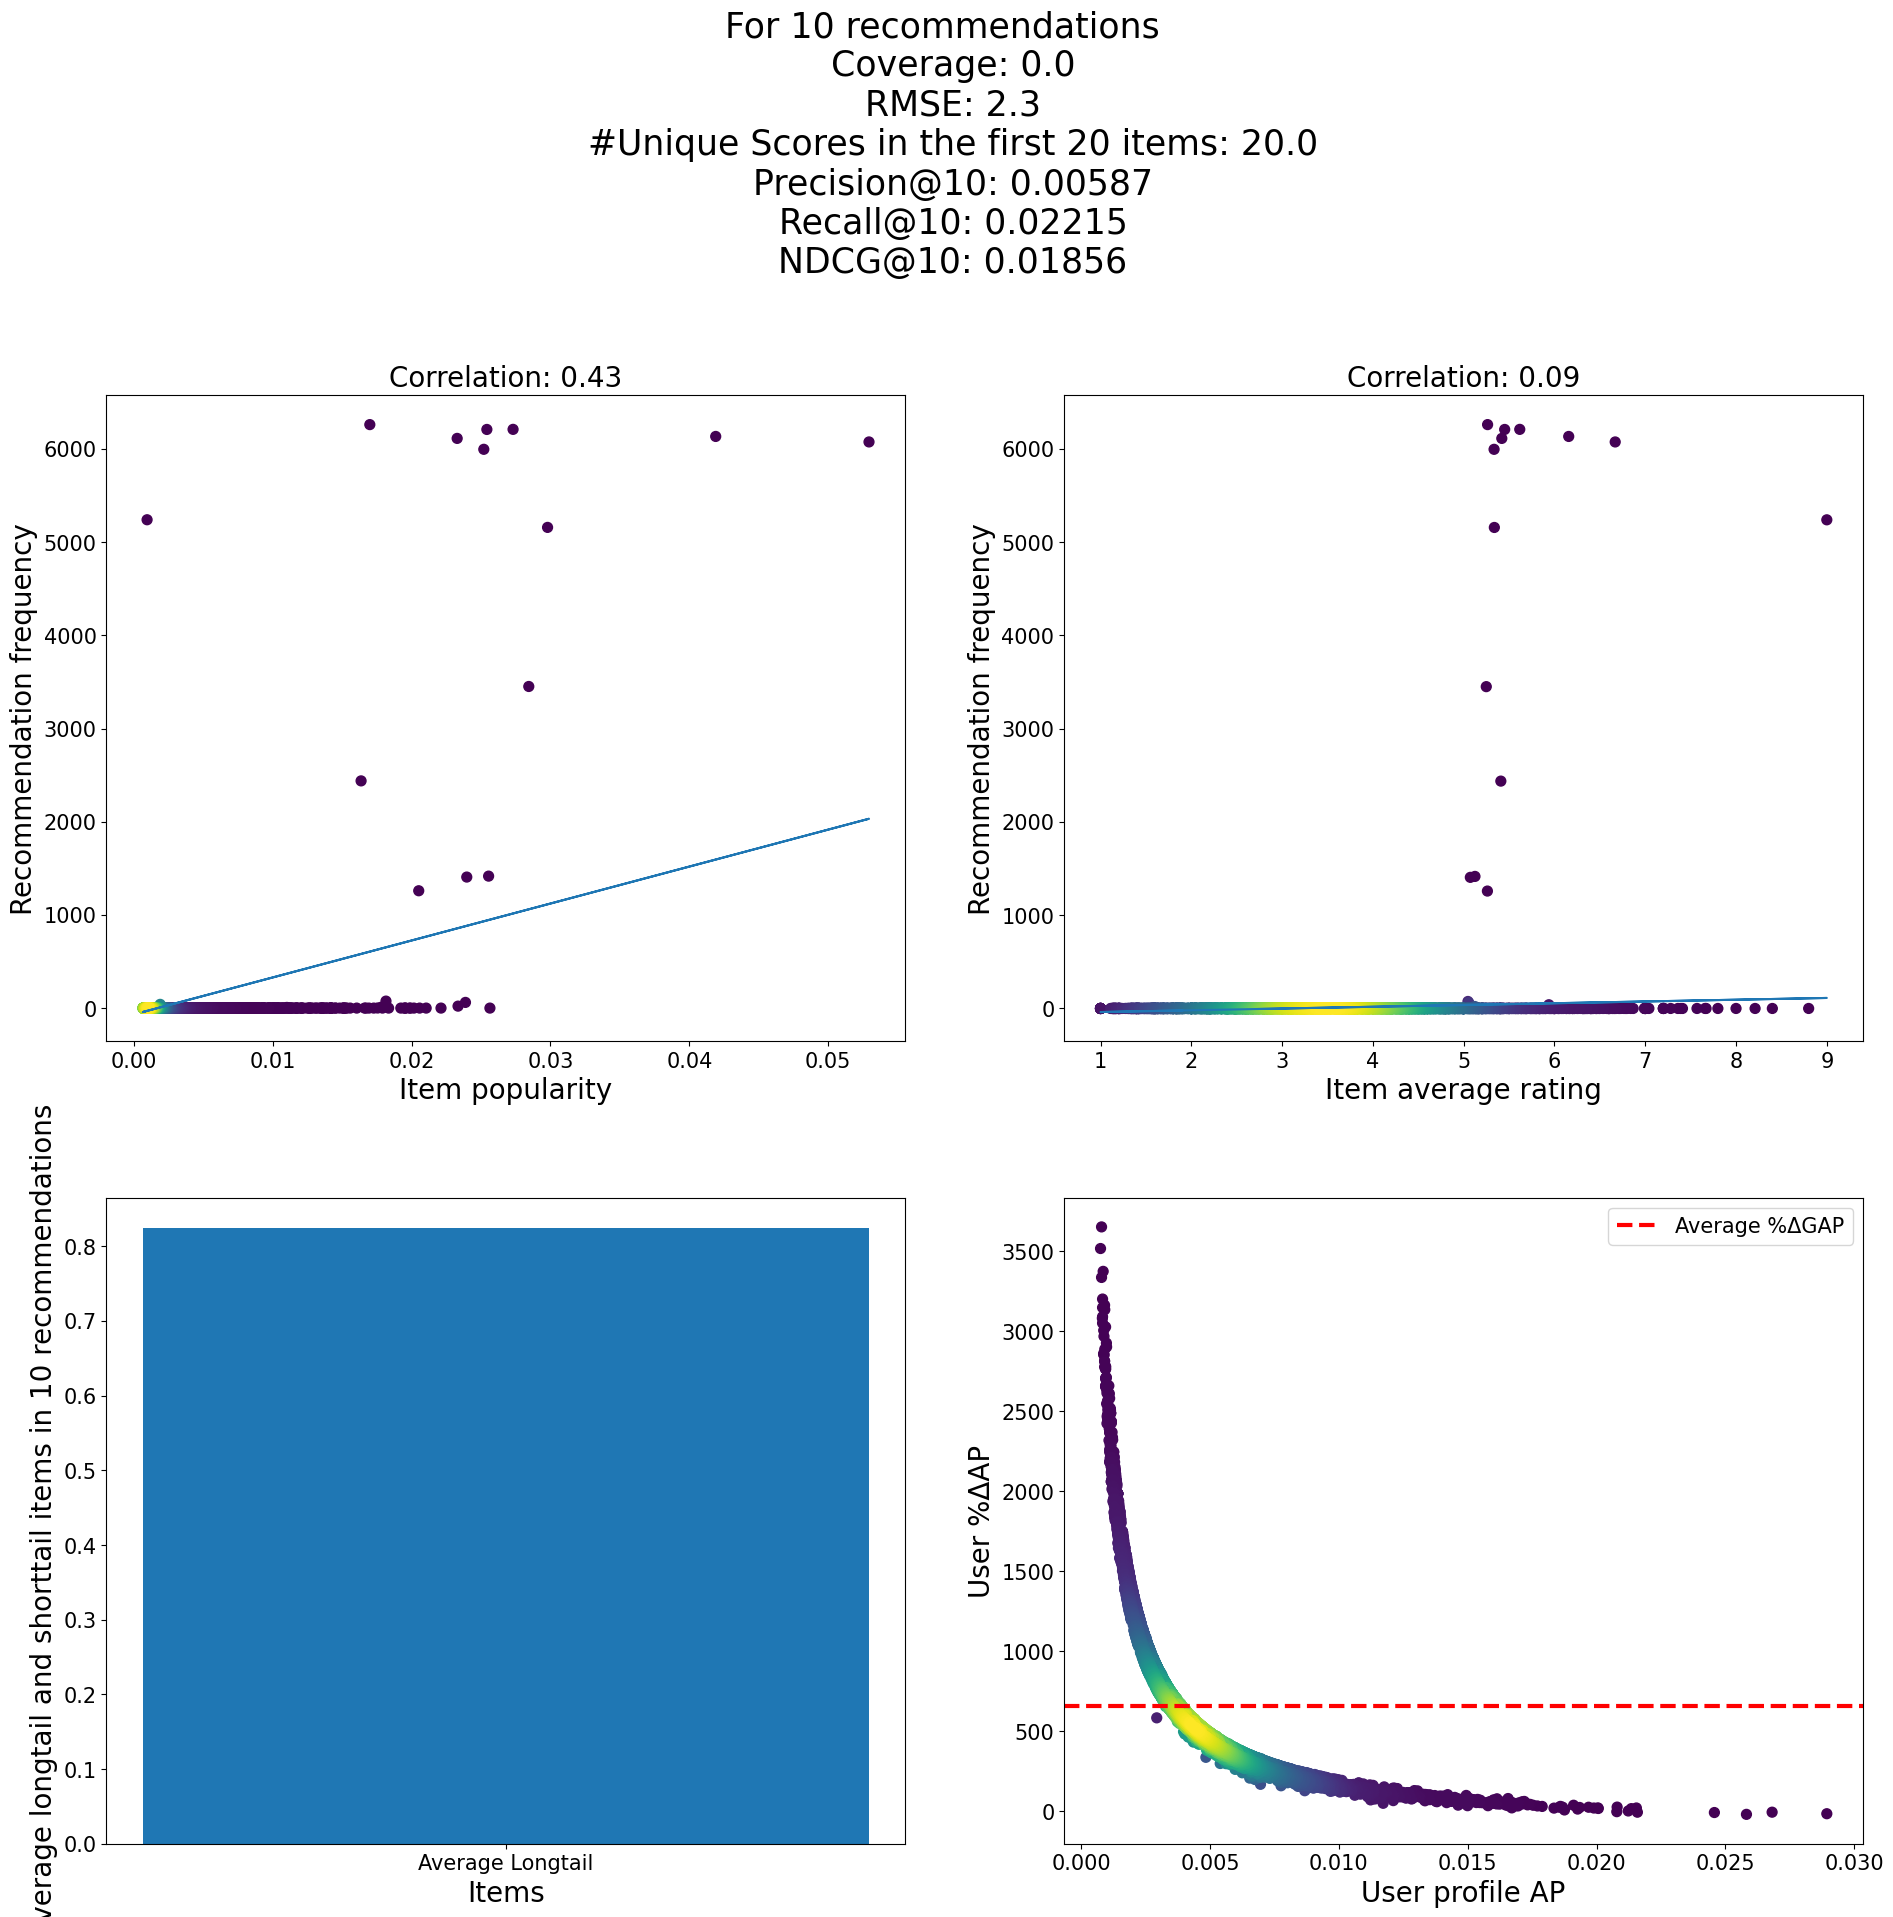

popularity_good_for_bp_ur {'bias': False}
We got them already

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.5486 |    0.1194 |   0.0531

nr of longtail 4923
3.8702830188679247

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.5538 |    0.1111 |   0.0501

nr of longtail 5588
4.3930817610062896

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.4288 |    0.1000 |   0.0529

nr of longtail 6367
5.005503144654088

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.4860 |    0.0978 |   0.0528

nr of longtail 4801
3.777340676632573

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.5416 |    0.0958 |   0.0499

nr of longtail 7902
6.217151848937844


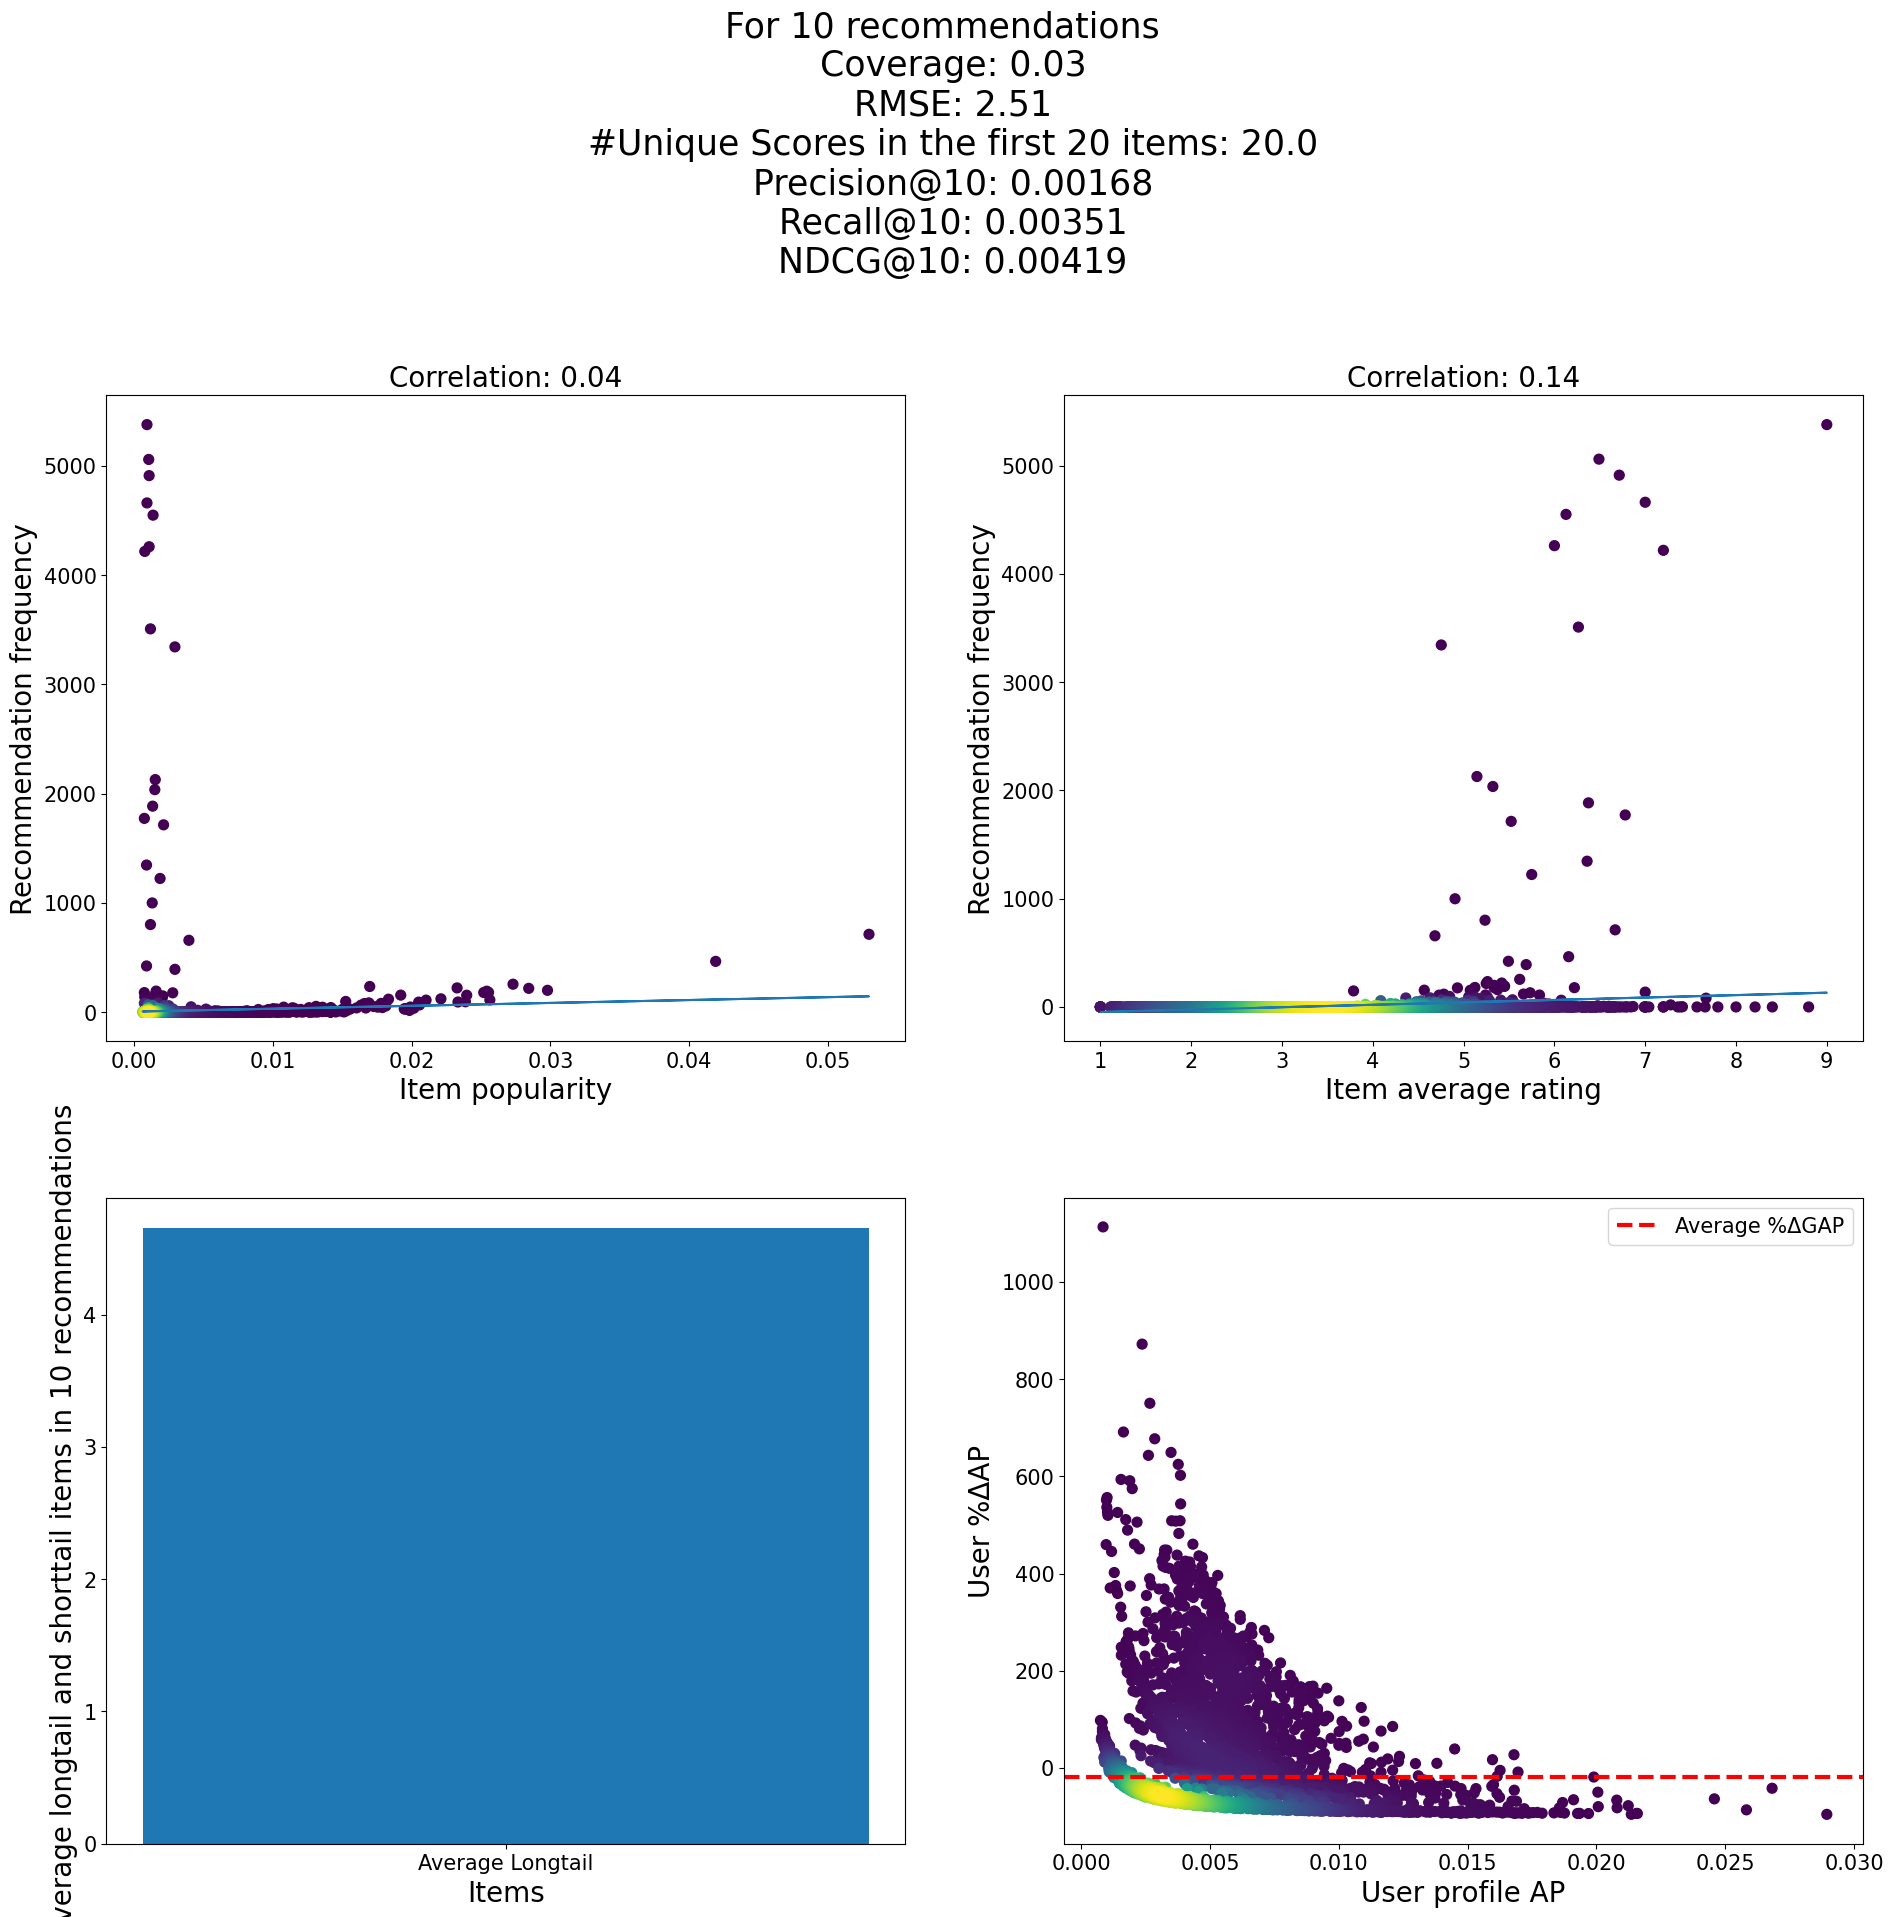

popularity_bad_for_bp_ur {'bias': True}
We got them already

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.4913 |    0.1869 |   0.0638

nr of longtail 2539
1.996069182389937

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.4932 |    0.1813 |   0.0503

nr of longtail 1272
1.0

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.4487 |    0.1862 |   0.0545

nr of longtail 1270
0.9984276729559748

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.4965 |    0.1805 |   0.0531

nr of longtail 3812
2.999213217938631

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.5694 |    0.1806 |   0.0512

nr of longtail 2542
2.0


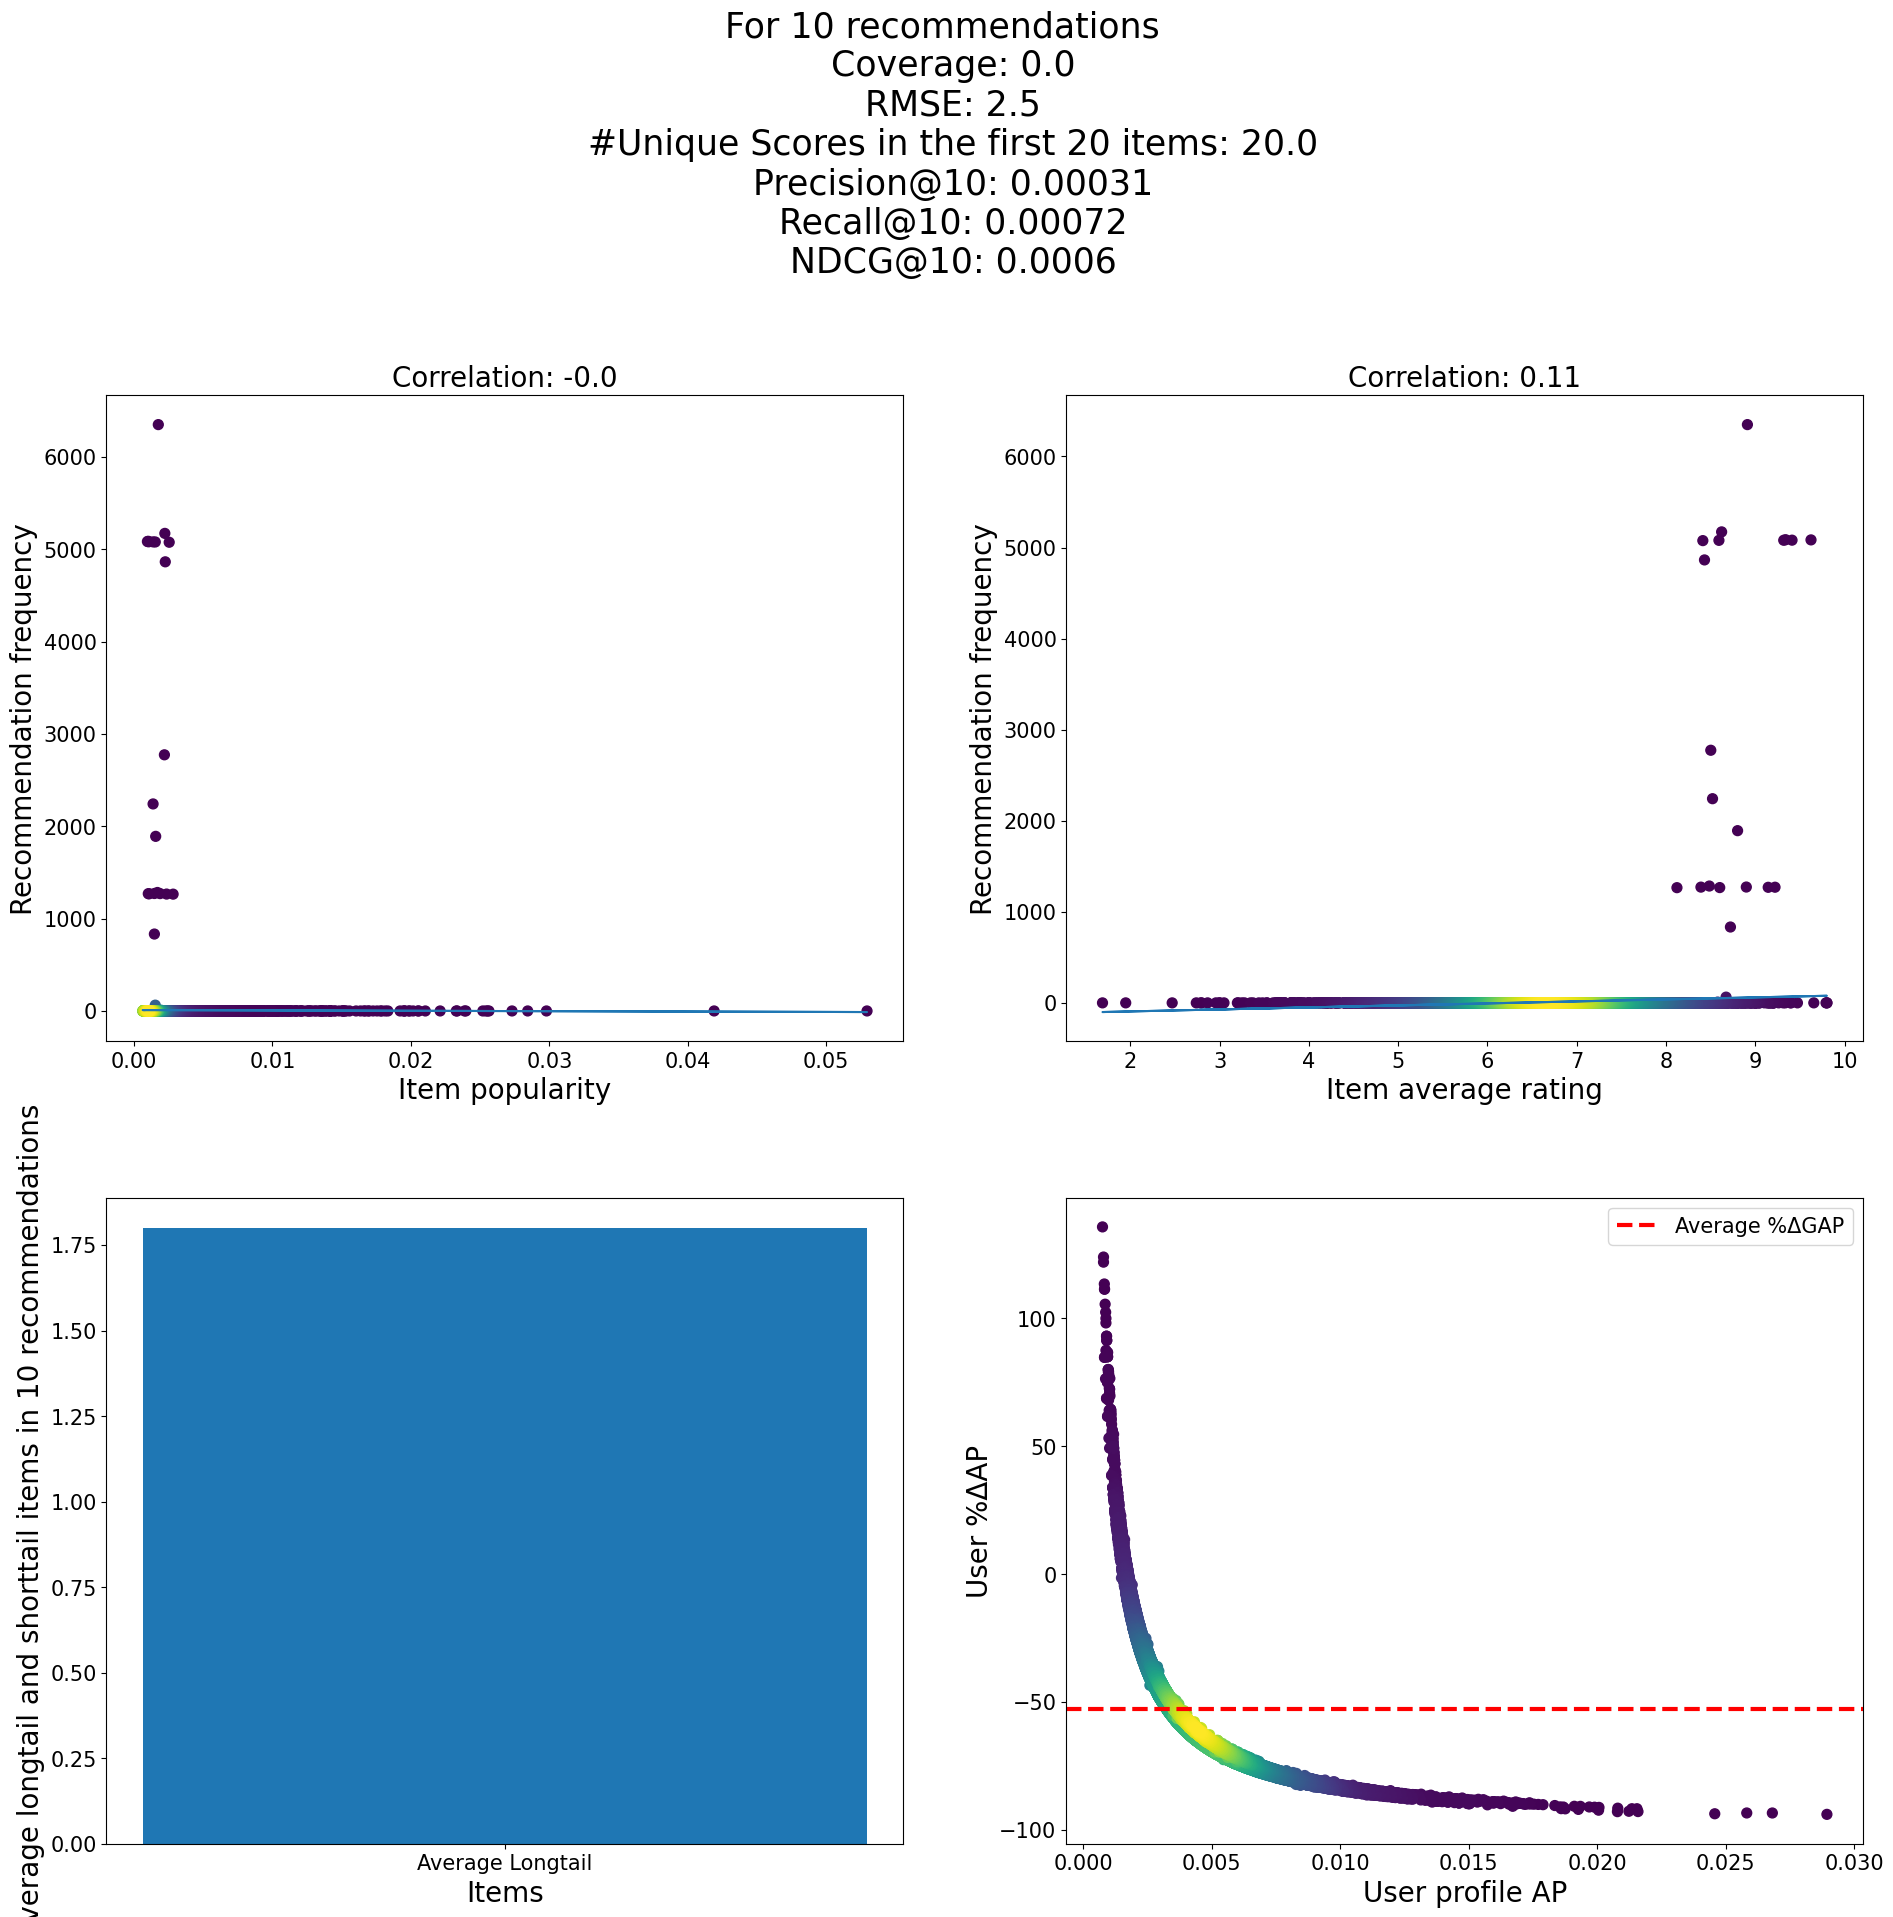

popularity_bad_for_bp_ur {'bias': False}
We got them already

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.6514 |    0.1106 |   0.0521

nr of longtail 10864
8.540880503144654

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.6869 |    0.1242 |   0.0495

nr of longtail 10950
8.608490566037736

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.6324 |    0.1095 |   0.0529

nr of longtail 12605
9.909591194968554

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.6781 |    0.1063 |   0.0528

nr of longtail 12056
9.485444531864674

TEST:
...
   |   RMSE | Train (s) | Test (s)
-- + ------ + --------- + --------
MF | 2.7097 |    0.1023 |   0.0499

nr of longtail 11176
8.793076317859953


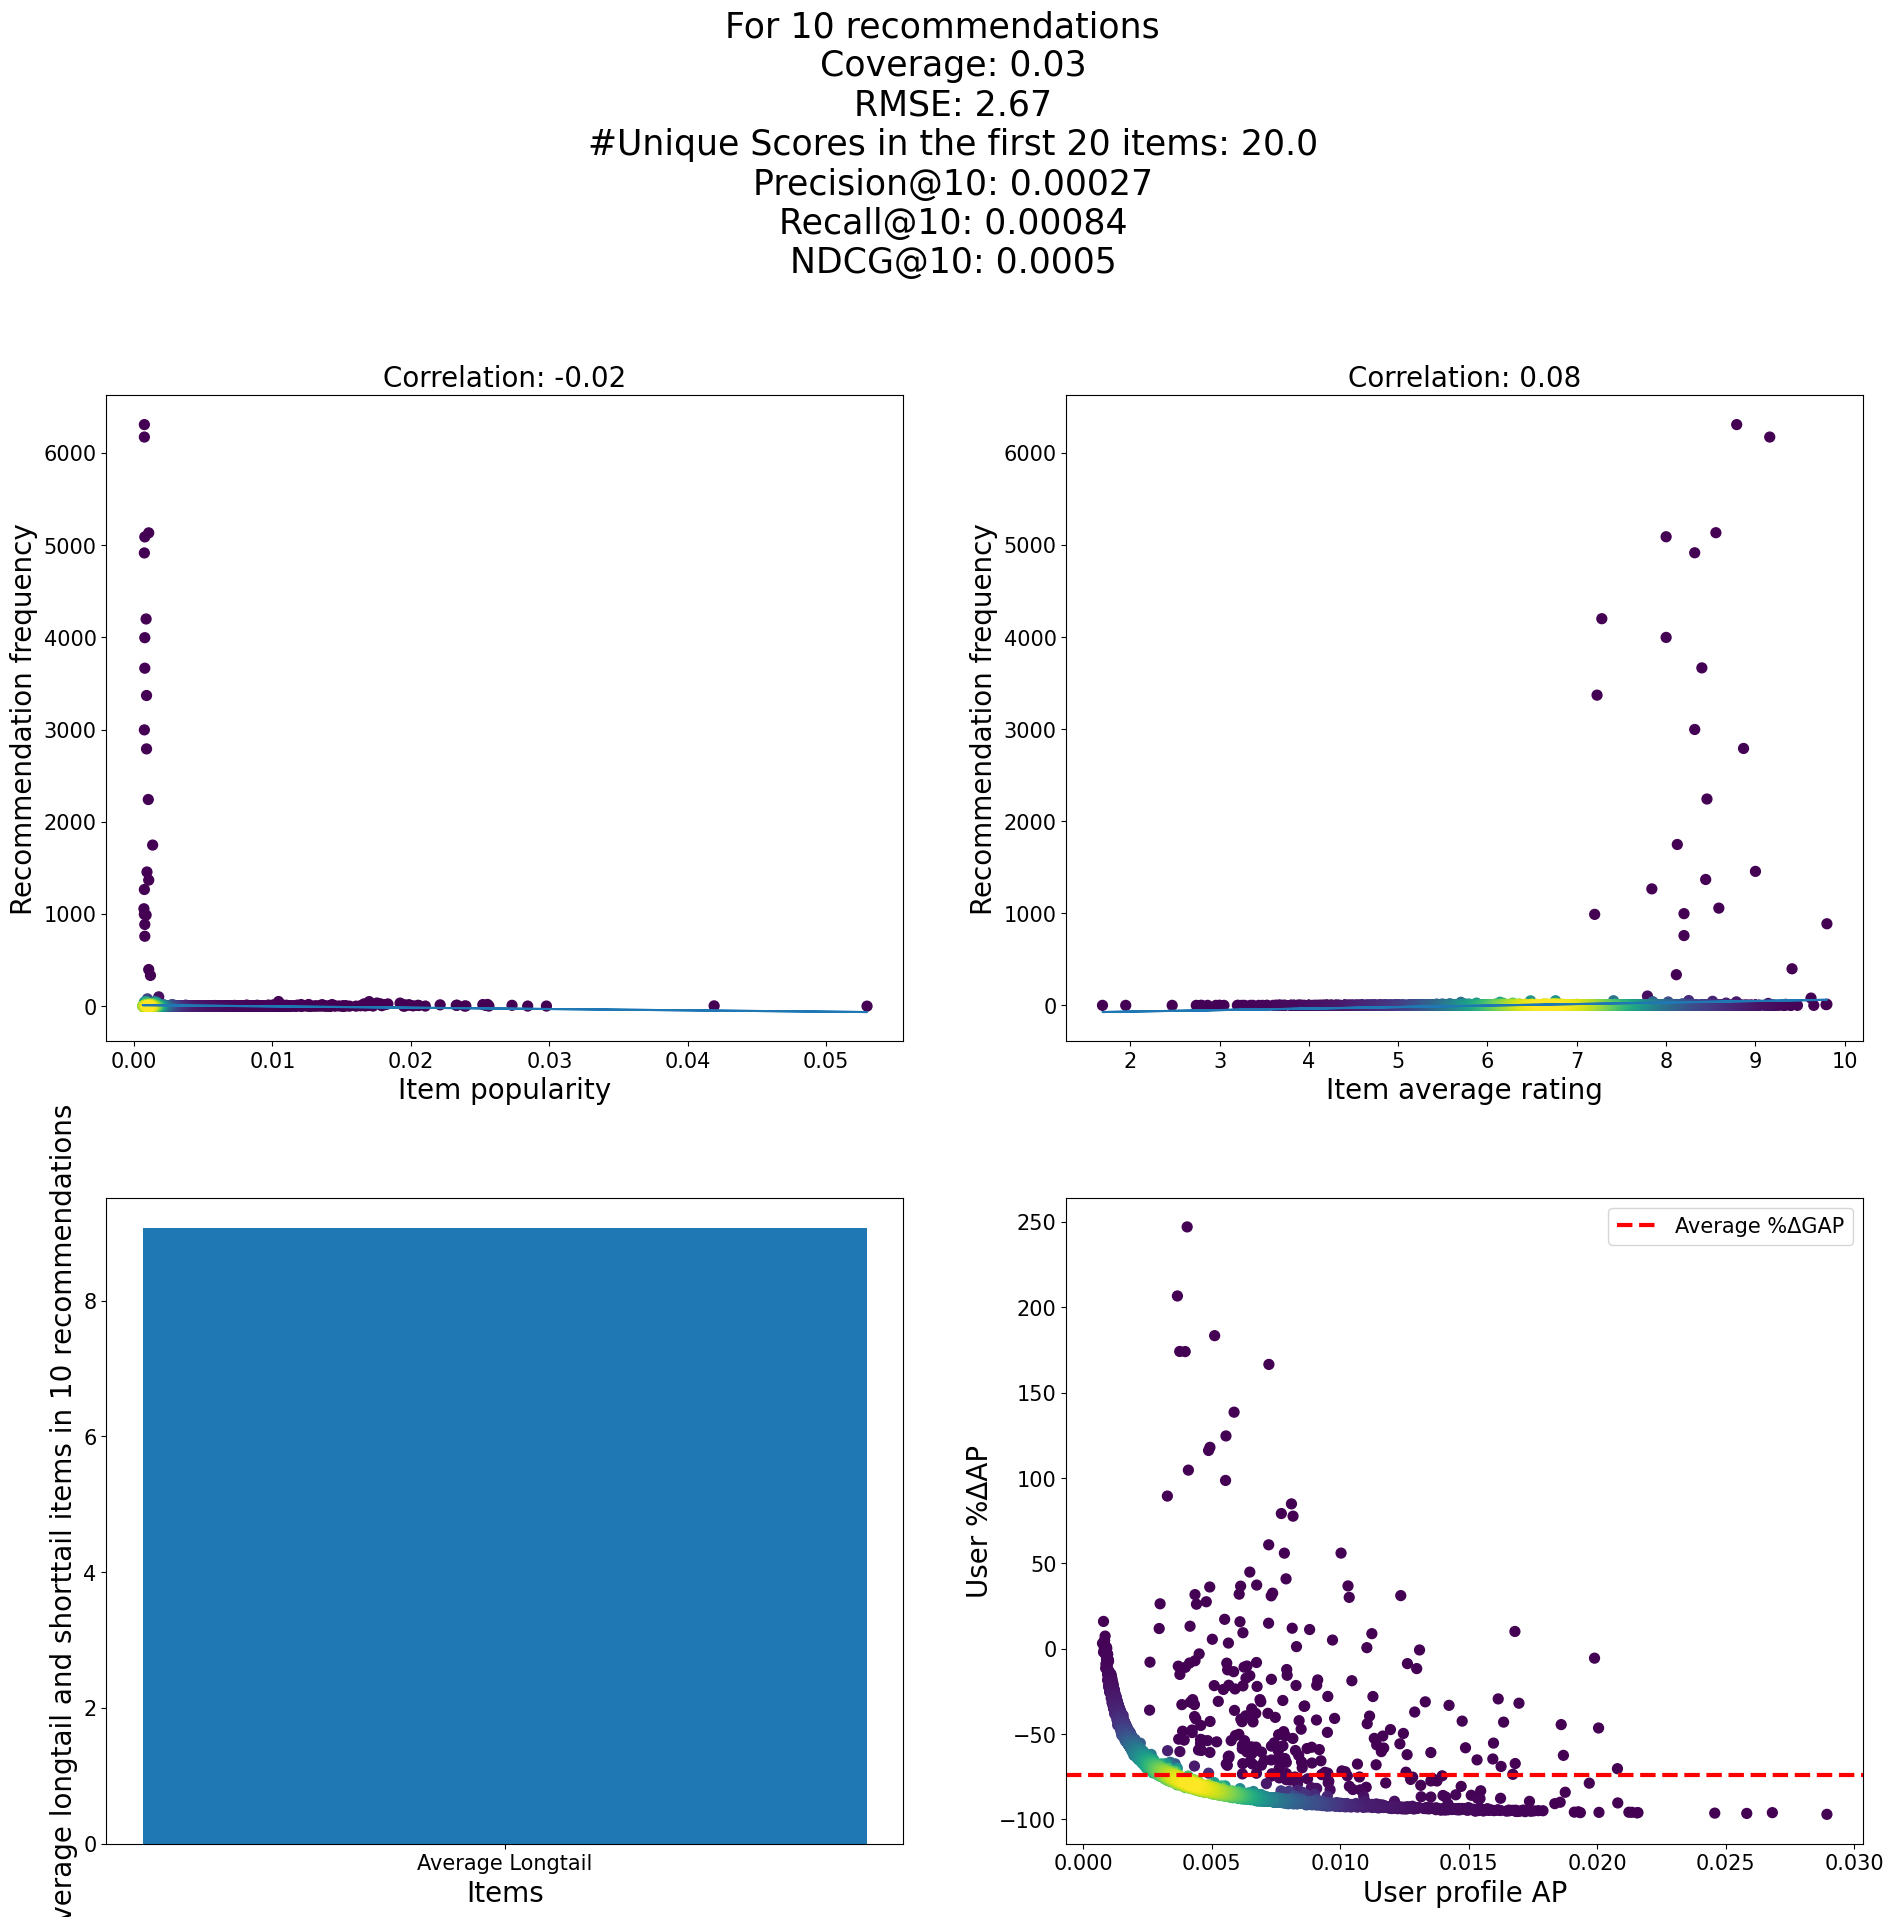

In [13]:
algorithm_cornac = MF
algo_name = "CornacMF"
versions = algo_versions[algo_name]

# for every data strategy
for i in range(len(data_strategies)):
    data_strategy = data_strategies[i]
    # generate the data
    ratings = generate_data(
        strategy=data_strategy, copying_dataset=fairbook_ratings, user_perc=0.2
    )
    # for every 'fixed' version of the algorithm
    for args in versions:
        print(data_strategy, args)


        p = "best_parameters/" + algo_name + "/" + data_strategy + "_" + str(args) + ".pkl"
        if os.path.isfile(p):
            print("We got them already")
            with open(p, "rb") as f:
                best_params = pickle.load(f)
        else:
            print("We have to compute them now")
            # optimize for this fixed version
            best_params = optimize_cornac(
                ratings=ratings, algorithm_name=algo_name, args=args, max_evals=20
            )
    
            # save the best parameters for this fixed version
    
            with open(
                "best_parameters/"
                + algo_name
                + "/"
                + data_strategy
                + "_"
                + str(args)
                + ".pkl",
                "wb",
            ) as f:
                pickle.dump(best_params, f)
                
        # # optimize for this fixed version
        # best_params = optimize_cornac(
        #     ratings=ratings, algorithm_name=algo_name, args=args, max_evals=20
        # )

        # # save the best parameters for this fixed version

        # with open(
        #     "best_parameters/"
        #     + algo_name
        #     + "/"
        #     + data_strategy
        #     + "_"
        #     + str(args)
        #     + ".pkl",
        #     "wb",
        # ) as f:
        #     pickle.dump(best_params, f)

        optimal_k = best_params["k"]
        optimal_reg = best_params["lambda_reg"]
        optimal_lr = best_params["learning_rate"]

        pop_biases_cornac, metrics_dict_cornac = modelling_mf.train_algorithm_cornac(
            algorithm=lambda: algorithm_cornac(
                k=optimal_k,
                use_bias=args["bias"],
                lambda_reg=optimal_reg,
                learning_rate=optimal_lr,
            ),
            algo_name=algo_name,
            ratings=ratings,
            evaluation_way=evaluation_way,
            verbose=verbose,
            n=nr_recs,
            sampling_strategy=sampling_strategy,
            partition_way=partition_way,
            plot=plot,
            data_strategy=data_strategy,
            args=args,
            save_plot=save_plot,
        )

        # Save metrics!
        with open(
            "experimental_results/"
            + algo_name
            + "/"
            + data_strategy
            + "_"
            + str(args)
            + ".pkl",
            "wb",
        ) as f:
            pickle.dump(metrics_dict_cornac, f)
        with open('experimental_results/'+algo_name+'/detailed_per_item_'+data_strategy+'_'+str(args)+'.pkl', 'wb') as f:
            pickle.dump(pop_biases_cornac, f)